# XGBOOST PIPELINE VERSION 2 

TODO: Explain the pipeline. 


**IMPORTS**

In [8]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit

**LOAD AND PREPARE DATA**

In [9]:
df_b = pd.read_parquet('../data/processed/burglaries.parquet')
df_burglaries = df_b.groupby(['Ward code', 'Month']).size().reset_index(name='Crime count')
display(df_burglaries.head())

df_c = pd.read_parquet('../data/processed/census_lsoa.parquet')
df_census = df_c.groupby('Ward code').sum(numeric_only=True).reset_index() # sum of LSOAs in each ward
display(df_census.head())

df_d = pd.read_parquet('../data/processed/deprivation_lsoa.parquet')
df_deprivation = df_d.groupby('Ward code').mean(numeric_only=True).reset_index() # average of LSOAs in each ward
display(df_deprivation)

# TODO: process stops in a better way (maybe include it with process_additional_datasets.py
df_stops = pd.read_csv('../data/processed/stop_counts_per_ward.csv')
display(df_stops)

# boundary data
gdf_ward_boundaries = gpd.read_file('../data/boundaries/ward boundaries 2024/london_wards_merged.shp')



,Ward code,Month,Crime count
0,E05009317,2022-04-01,8
1,E05009317,2022-05-01,17
2,E05009317,2022-06-01,7
3,E05009317,2022-07-01,10
4,E05009317,2022-08-01,10


,Ward code,Total population,Under 15 years,15 to 64 years,65 years and older,Total: All households,One-person household,One-person household: Aged 66 years and over,One-person household: Other,Single family household,Other household types,Detached whole house or bungalow,Semi-detached whole house or bungalow,Terraced whole house or bungalow,"Flat, maisonette or apartment",A caravan or other mobile or temporary structure,Total: All dwellings,Total: Occupied dwellings,Unoccupied dwellings
0,E05009317,23708,4456,17884,1368,8044.0,2260.0,454.0,1806.0,4283.0,1501.0,60.0,130.0,870.0,7410.0,0.0,8535,8030,490.0
1,E05009318,21615,3325,17514,776,9571.0,3491.0,245.0,3246.0,4708.0,1372.0,0.0,75.0,335.0,10925.0,80.0,11490,9545,1945.0
2,E05009319,19540,3228,15150,1162,8401.0,2721.0,492.0,2229.0,4398.0,1282.0,115.0,205.0,935.0,7700.0,0.0,8990,8405,580.0
3,E05009320,13708,2396,10173,1139,5277.0,1529.0,406.0,1123.0,2656.0,1092.0,50.0,165.0,1360.0,3980.0,0.0,5580,5275,305.0
4,E05009321,11567,2401,8465,701,4441.0,1418.0,208.0,1210.0,2326.0,697.0,45.0,105.0,350.0,4180.0,20.0,4725,4445,280.0


,Ward code,Index of Multiple Deprivation (IMD) Score,Index of Multiple Deprivation (IMD) Rank,Index of Multiple Deprivation (IMD) Decile,Income Score,Income Rank,Income Decile,Employment Score,Employment Rank,Employment Decile,...,Health Deprivation and Disability Decile,Crime Score,Crime Rank,Crime Decile,Barriers to Housing and Services Score,Barriers to Housing and Services Rank,Barriers to Housing and Services Decile,Living Environment Score,Living Environment Rank,Living Environment Decile
0,E05009317,29.618149,8591.484596,3.216929,0.202229,7069.749127,2.800262,0.111058,12027.812847,4.100524,...,4.300262,0.667665,8068.050580,3.150786,29.623605,7349.157218,2.616405,36.876296,6322.995315,2.449738
1,E05009318,18.023071,16578.071429,5.785714,0.109071,16913.357143,5.642857,0.057786,23493.785714,7.714286,...,5.857143,-0.327929,21006.857143,6.857143,31.674429,6185.071429,2.214286,35.877000,8329.000000,3.000000
2,E05009319,28.217091,9341.909091,3.363636,0.178818,9415.454545,3.090909,0.096455,15163.000000,5.090909,...,3.545455,0.667545,7742.181818,3.000000,31.129636,6525.272727,2.545455,36.264818,8681.636364,3.090909
3,E05009320,26.289714,10240.428571,3.714286,0.170143,9800.571429,3.571429,0.097000,14078.000000,4.714286,...,5.000000,1.017714,4709.000000,2.142857,26.295000,10085.714286,3.428571,34.832857,7237.000000,2.714286
4,E05009321,34.337286,6293.285714,2.571429,0.252143,4005.000000,1.714286,0.139286,7853.142857,2.857143,...,4.142857,0.837286,6704.142857,2.714286,30.805286,6611.428571,2.571429,29.484000,9706.000000,3.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,E05014116,19.240600,15450.200000,5.000000,0.118000,14961.000000,5.200000,0.078200,18283.000000,6.200000,...,6.400000,0.131000,14636.200000,5.000000,26.793600,9656.800000,3.400000,41.952800,4070.800000,1.600000
676,E05014117,29.338286,8884.000000,3.142857,0.166000,9948.428571,3.428571,0.107857,12572.285714,4.285714,...,4.285714,0.523857,9047.571429,3.285714,32.303143,5578.285714,2.142857,55.116714,1719.142857,1.142857
677,E05014118,20.963200,14518.600000,5.000000,0.099800,18307.400000,6.200000,0.063800,21093.000000,6.600000,...,4.800000,0.258600,13397.400000,4.400000,29.860800,7241.200000,2.600000,52.309000,2965.400000,1.400000
678,E05014119,20.499800,15804.800000,5.200000,0.121800,16304.200000,5.600000,0.084000,18486.200000,6.200000,...,6.800000,0.502600,9286.400000,3.400000,26.530800,10132.800000,3.800000,40.291600,4424.400000,1.800000


,Ward code,Ward name,stop_count
0,E05009317,Bethnal Green East,30
1,E05009318,Blackwall & Cubitt Town,41
2,E05009319,Bow East,45
3,E05009320,Bow West,27
4,E05009321,Bromley North,15
...,...,...,...
675,E05014116,Streatham Wells,29
676,E05014117,Vauxhall,32
677,E05014118,Waterloo & South Bank,68
678,E05014119,West Dulwich,25


In [10]:
# for deprivation, include only the 'Score' columns, and not rank and deciles
df_deprivation_filtered = df_deprivation.loc[:, df_deprivation.columns.str.contains('Score|Ward code')]
df_static = df_census.merge(df_deprivation_filtered, on="Ward code").merge(df_stops[["Ward code", "stop_count"]], on="Ward code")
display(df_static)


,Ward code,Total population,Under 15 years,15 to 64 years,65 years and older,Total: All households,One-person household,One-person household: Aged 66 years and over,One-person household: Other,Single family household,...,Unoccupied dwellings,Index of Multiple Deprivation (IMD) Score,Income Score,Employment Score,"Education, Skills and Training Score",Health Deprivation and Disability Score,Crime Score,Barriers to Housing and Services Score,Living Environment Score,stop_count
0,E05009317,23708,4456,17884,1368,8044.0,2260.0,454.0,1806.0,4283.0,...,490.0,29.618149,0.202229,0.111058,18.296646,0.238489,0.667665,29.623605,36.876296,30
1,E05009318,21615,3325,17514,776,9571.0,3491.0,245.0,3246.0,4708.0,...,1945.0,18.023071,0.109071,0.057786,11.314714,-0.059000,-0.327929,31.674429,35.877000,41
2,E05009319,19540,3228,15150,1162,8401.0,2721.0,492.0,2229.0,4398.0,...,580.0,28.217091,0.178818,0.096455,16.242182,0.445455,0.667545,31.129636,36.264818,45
3,E05009320,13708,2396,10173,1139,5277.0,1529.0,406.0,1123.0,2656.0,...,305.0,26.289714,0.170143,0.097000,14.066429,0.053714,1.017714,26.295000,34.832857,27
4,E05009321,11567,2401,8465,701,4441.0,1418.0,208.0,1210.0,2326.0,...,280.0,34.337286,0.252143,0.139286,21.247429,0.295000,0.837286,30.805286,29.484000,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,E05014116,9589,1568,7112,909,4022.0,1173.0,283.0,890.0,2228.0,...,290.0,19.240600,0.118000,0.078200,6.023000,-0.225000,0.131000,26.793600,41.952800,29
676,E05014117,10478,1067,8651,760,5056.0,2200.0,284.0,1916.0,2069.0,...,1560.0,29.338286,0.166000,0.107857,7.561143,0.329429,0.523857,32.303143,55.116714,32
677,E05014118,8566,816,6897,853,3716.0,1524.0,325.0,1199.0,1576.0,...,1385.0,20.963200,0.099800,0.063800,10.141800,0.104600,0.258600,29.860800,52.309000,68
678,E05014119,8429,1729,5555,1145,3440.0,988.0,386.0,602.0,2139.0,...,200.0,20.499800,0.121800,0.084000,7.038800,-0.232800,0.502600,26.530800,40.291600,25


In [11]:
# REMOVE THE CORRELATED FEATURES
selected_features = list(df_deprivation_filtered.columns) + ['Under 15 years', '15 to 64 years', '65 years and older', 'One-person household', 'One-person household: Aged 66 years and over', 'One-person household: Other', 'Single family household', 'Other household types', 'Detached whole house or bungalow', 'Semi-detached whole house or bungalow', 'Terraced whole house or bungalow', 'Flat, maisonette or apartment', 'A caravan or other mobile or temporary structure', 'Total: All dwellings', 'Unoccupied dwellings', 'stop_count']
df_static_selected = df_static[selected_features]
df_static_selected

,Ward code,Index of Multiple Deprivation (IMD) Score,Income Score,Employment Score,"Education, Skills and Training Score",Health Deprivation and Disability Score,Crime Score,Barriers to Housing and Services Score,Living Environment Score,Under 15 years,...,Single family household,Other household types,Detached whole house or bungalow,Semi-detached whole house or bungalow,Terraced whole house or bungalow,"Flat, maisonette or apartment",A caravan or other mobile or temporary structure,Total: All dwellings,Unoccupied dwellings,stop_count
0,E05009317,29.618149,0.202229,0.111058,18.296646,0.238489,0.667665,29.623605,36.876296,4456,...,4283.0,1501.0,60.0,130.0,870.0,7410.0,0.0,8535,490.0,30
1,E05009318,18.023071,0.109071,0.057786,11.314714,-0.059000,-0.327929,31.674429,35.877000,3325,...,4708.0,1372.0,0.0,75.0,335.0,10925.0,80.0,11490,1945.0,41
2,E05009319,28.217091,0.178818,0.096455,16.242182,0.445455,0.667545,31.129636,36.264818,3228,...,4398.0,1282.0,115.0,205.0,935.0,7700.0,0.0,8990,580.0,45
3,E05009320,26.289714,0.170143,0.097000,14.066429,0.053714,1.017714,26.295000,34.832857,2396,...,2656.0,1092.0,50.0,165.0,1360.0,3980.0,0.0,5580,305.0,27
4,E05009321,34.337286,0.252143,0.139286,21.247429,0.295000,0.837286,30.805286,29.484000,2401,...,2326.0,697.0,45.0,105.0,350.0,4180.0,20.0,4725,280.0,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,E05014116,19.240600,0.118000,0.078200,6.023000,-0.225000,0.131000,26.793600,41.952800,1568,...,2228.0,621.0,110.0,655.0,600.0,2945.0,0.0,4320,290.0,29
676,E05014117,29.338286,0.166000,0.107857,7.561143,0.329429,0.523857,32.303143,55.116714,1067,...,2069.0,787.0,0.0,65.0,205.0,6290.0,0.0,6600,1560.0,32
677,E05014118,20.963200,0.099800,0.063800,10.141800,0.104600,0.258600,29.860800,52.309000,816,...,1576.0,616.0,0.0,80.0,365.0,4630.0,0.0,5095,1385.0,68
678,E05014119,20.499800,0.121800,0.084000,7.038800,-0.232800,0.502600,26.530800,40.291600,1729,...,2139.0,313.0,95.0,615.0,1055.0,1850.0,0.0,3635,200.0,25


In [12]:
# some wards do not contain data for all available months. this will be considered in feature engineering
unique_months_per_ward = df_burglaries.groupby('Ward code').size().value_counts()
unique_months_per_ward


36    411
35    130
34     69
33     22
32     16
30     10
31     10
29      5
28      3
27      2
23      1
24      1
Name: count, dtype: int64

**FEATURE ENGINEERING**

In [13]:
def create_features(df_burglaries, df_static, max_horizon=4, lags=[1, 2, 3], rolling_windows=[2, 4, 6]):
    """
    Returns a dictionary with dataframe of created features and corresponding target for:
    - Nowcasting (predict current month crime count)
    - Forecast horizons 1 to max_horizon (predict future months crime count)
    
    Missing months per ward are filled with zero burglaries to ensure consistent
    lag and rolling calculations based on calendar months.
    """
    df = df_burglaries.copy()
    
    # Ensure datetime and sort
    df['Month'] = pd.to_datetime(df['Month'])
    df = df.sort_values(['Ward code', 'Month'])

    # Create a complete monthly date range covering all data
    all_months = pd.date_range(start=df['Month'].min(), end=df['Month'].max(), freq='MS')

    features = []
    for ward, group in df.groupby('Ward code'):
        group = group.set_index('Month').sort_index()
        # Reindex with full calendar months and fill missing months with 0 burglaries
        group = group.reindex(all_months, fill_value=0)
        group['Ward code'] = ward
        
        # Lag features
        for lag in lags:
            group[f'lag_{lag}'] = group['Crime count'].shift(lag)
        # Rolling mean features
        for window in rolling_windows:
            group[f'roll_mean_{window}'] = group['Crime count'].shift(1).rolling(window=window).mean()

        features.append(group.reset_index().rename(columns={'index': 'Month'}))

    df_features = pd.concat(features)

    # Cyclical time features for month
    df_features['month'] = df_features['Month'].dt.month
    df_features['month_sin'] = np.sin(2 * np.pi * df_features['month'] / 12)
    df_features['month_cos'] = np.cos(2 * np.pi * df_features['month'] / 12)
    df_features = df_features.drop(columns=['month'])  # keep only month_sin and month_cos

    # Merge static ward features
    df_features = df_features.merge(df_static, on='Ward code', how='left')
    
    horizon_datasets = {}

    # Nowcasting target: crime count at current month (no shift)
    df_nowcast = df_features.copy()
    df_nowcast['target_t'] = df_nowcast['Crime count']
    df_nowcast = df_nowcast.dropna() 
    df_nowcast['Ward code'] = df_nowcast['Ward code'].astype('category')
    horizon_datasets[0] = df_nowcast.reset_index(drop=True)

    # Forecasting targets: crime count shifted by -h for horizons 1 to max_horizon
    for h in range(1, max_horizon + 1):
        df_h = df_features.copy()
        df_h[f'target_t+{h}'] = df_h.groupby('Ward code')['Crime count'].shift(-h)
        df_h = df_h.dropna()  # drop rows with NaNs in features or target
        df_h['Ward code'] = df_h['Ward code'].astype('category')
        horizon_datasets[h] = df_h.reset_index(drop=True)


    # Drop original 'Crime count' after target creation
    for key in horizon_datasets:
        horizon_datasets[key] = horizon_datasets[key].drop(columns=['Crime count'])
        # Sort by month first: IMPORTANT for time series cross validation later
        horizon_datasets[key] = horizon_datasets[key].sort_values(by=['Month', 'Ward code']).reset_index(drop=True)

    return horizon_datasets


In [14]:
import numpy as np
import pandas as pd

def create_features_per_horizon(
    df_burglaries,
    df_static,
    max_horizon=4,
    lag_config=None,
    rolling_config=None
):
    df = df_burglaries.copy()
    df['Month'] = pd.to_datetime(df['Month'])
    df = df.sort_values(['Ward code', 'Month'])

    all_months = pd.date_range(start=df['Month'].min(), end=df['Month'].max(), freq='MS')
    horizon_datasets = {}

    # Default config if none provided
    if lag_config is None:
        lag_config = {h: [1, 2, 3] for h in range(max_horizon + 1)}
    if rolling_config is None:
        rolling_config = {h: [2, 4, 6] for h in range(max_horizon + 1)}

    # Group by ward first
    ward_groups = {
        ward: group.set_index('Month').reindex(all_months, fill_value=0).assign(**{'Ward code': ward})
        for ward, group in df.groupby('Ward code')
    }

    for h in range(max_horizon + 1):
        horizon_frames = []
        for ward, group in ward_groups.items():
            g = group.copy()
            g['Crime count'] = g['Crime count']

            # Lag features
            for lag in lag_config.get(h, []):
                g[f'lag_{lag}'] = g['Crime count'].shift(lag)
            # Rolling mean features
            for window in rolling_config.get(h, []):
                g[f'roll_mean_{window}'] = g['Crime count'].shift(1).rolling(window=window).mean()

            g = g.reset_index().rename(columns={'index': 'Month'})

            # Add month dummy variables
            g['month'] = g['Month'].dt.month
            month_dummies = pd.get_dummies(g['month'], prefix='month')
            g = pd.concat([g, month_dummies], axis=1)
            g = g.drop(columns=['month'])

            horizon_frames.append(g)

        df_h = pd.concat(horizon_frames)

        # Merge static data
        df_h = df_h.merge(df_static, on='Ward code', how='left')

        # Target
        if h == 0:
            df_h['target_t'] = df_h['Crime count']
        else:
            df_h[f'target_t+{h}'] = df_h.groupby('Ward code')['Crime count'].shift(-h)

        df_h = df_h.dropna()
        df_h = df_h.drop(columns=['Crime count'])
        df_h['Ward code'] = df_h['Ward code'].astype('category')
        df_h = df_h.sort_values(by=['Month', 'Ward code']).reset_index(drop=True)
        horizon_datasets[h] = df_h

    return horizon_datasets


In [15]:
def create_features_per_horizon(
    df_burglaries,
    df_static,
    max_horizon=4,
    lag_config=None,
    rolling_config=None
):
    df = df_burglaries.copy()
    df['Month'] = pd.to_datetime(df['Month'])
    df = df.sort_values(['Ward code', 'Month'])

    all_months = pd.date_range(start=df['Month'].min(), end=df['Month'].max(), freq='MS')
    horizon_datasets = {}

    # Default config if none provided
    if lag_config is None:
        lag_config = {h: [1, 2, 3] for h in range(max_horizon + 1)}
    if rolling_config is None:
        rolling_config = {h: [2, 4, 6] for h in range(max_horizon + 1)}

    # Group by ward first
    ward_groups = {ward: group.set_index('Month').reindex(all_months, fill_value=0).assign(**{'Ward code': ward})
                   for ward, group in df.groupby('Ward code')}

    for h in range(max_horizon + 1):
        horizon_frames = []
        for ward, group in ward_groups.items():
            g = group.copy()
            g['Crime count'] = g['Crime count']

            # Lag features
            for lag in lag_config.get(h, []):
                g[f'lag_{lag}'] = g['Crime count'].shift(lag)
            # Rolling mean features
            for window in rolling_config.get(h, []):
                g[f'roll_mean_{window}'] = g['Crime count'].shift(1).rolling(window=window).mean()

            g = g.reset_index().rename(columns={'index': 'Month'})
            horizon_frames.append(g)

        df_h = pd.concat(horizon_frames)

        # Add cyclical time features
        df_h['month'] = df_h['Month'].dt.month
        df_h['month_sin'] = np.sin(2 * np.pi * df_h['month'] / 12)
        df_h['month_cos'] = np.cos(2 * np.pi * df_h['month'] / 12)
        df_h = df_h.drop(columns=['month'])

        # Merge static data
        df_h = df_h.merge(df_static, on='Ward code', how='left')

        # Target
        if h == 0:
            df_h['target_t'] = df_h['Crime count']
        else:
            df_h[f'target_t+{h}'] = df_h.groupby('Ward code')['Crime count'].shift(-h)

        df_h = df_h.dropna()
        df_h = df_h.drop(columns=['Crime count'])
        df_h['Ward code'] = df_h['Ward code'].astype('category')
        df_h = df_h.sort_values(by=['Month', 'Ward code']).reset_index(drop=True)
        horizon_datasets[h] = df_h

    return horizon_datasets

In [17]:
lag_config = {
    0: [1, 2, 3],        # nowcasting
    1: [1, 2, 3],
    2: [1, 2, 3],
    3: [1, 2, 3],
    4: [1, 2, 3]
}
rolling_config = {
    0: [3],
    1: [3],
    2: [3],
    3: [3],
    4: [3]
}

horizon_datasets = create_features_per_horizon(
    df_burglaries, df_static, max_horizon=4,
    lag_config=lag_config, rolling_config=rolling_config
)


**TRAIN-TEST SPLIT**

In [18]:
def temporal_train_test_split(horizon_datasets, test_months=6, gap=0):
    """
    Splits each horizon dataset into train/test sets based on the last `test_months` unique months.

    Parameters:
    - horizon_datasets: dict of {horizon: dataframe}, output from create_features
    - test_months: int, number of unique months to include in the test set
    - date_col: str, name of the datetime column
    - gap: int, number of months to exclude between train and test sets to prevent leakage

    Returns:
    - dict of {horizon: {'train': df_train, 'test': df_test}}
    """
    from pandas.tseries.offsets import MonthEnd

    split_results = {}

    for horizon, df in horizon_datasets.items():
        df = df.copy()
        df['Month'] = pd.to_datetime(df['Month'])

        # Ensure we only use rows with valid targets
        target_col = f"target_t+{horizon}" if horizon > 0 else "target_t"
        df = df[df[target_col].notna()]

        # Get sorted unique months
        unique_months = df['Month'].sort_values().dt.to_period("M").unique()
        if len(unique_months) < test_months + gap:
            raise ValueError(f"Not enough unique months for horizon {horizon} with gap={gap} and test_months={test_months}")

        split_month = unique_months[-(test_months + gap)]  # split point is right before test + gap
        split_month = split_month.to_timestamp() + MonthEnd(1)  # convert to timestamp end-of-month

        df_train = df[df['Month'] < split_month]
        df_test = df[df['Month'] >= split_month + pd.DateOffset(months=gap)]

        split_results[horizon] = {
            'train': df_train.reset_index(drop=True),
            'test': df_test.reset_index(drop=True)
        }

    return split_results


In [19]:
# TRAIN AND TEST SPLIT
splits = temporal_train_test_split(horizon_datasets, test_months=5, gap=0)

for h in range(5):
    train_df = splits[h]['train']
    test_df = splits[h]['test']
    print(f"Horizon {h}: Train = {train_df.shape}, Test = {test_df.shape}")


Horizon 0: Train = (19720, 36), Test = (2720, 36)
Horizon 1: Train = (19040, 36), Test = (2720, 36)
Horizon 2: Train = (18360, 36), Test = (2720, 36)
Horizon 3: Train = (17680, 36), Test = (2720, 36)
Horizon 4: Train = (17000, 36), Test = (2720, 36)


In [20]:
def visualize_split_presence(train_df, test_df, date_col='Month', label='Horizon', gap=True):
    """
    Marks each month as 'train', 'gap', 'test', or 'none' for timeline presence only.
    """
    train_df = train_df.copy()
    test_df = test_df.copy()
    full_df = df_burglaries.copy()

    # All unique months in the full data
    all_months = pd.date_range(
        start=full_df[date_col].min(),
        end=full_df[date_col].max(),
        freq='MS'
    )

    # Set labels
    timeline = pd.DataFrame({date_col: all_months})
    timeline['Set'] = 'none'
    timeline.loc[timeline[date_col].isin(train_df[date_col].unique()), 'Set'] = 'train'
    timeline.loc[timeline[date_col].isin(test_df[date_col].unique()), 'Set'] = 'test'

    if gap:
        last_train = train_df[date_col].max()
        first_test = test_df[date_col].min()
        gap_months = pd.date_range(
            last_train + pd.DateOffset(months=1),
            first_test - pd.DateOffset(months=1),
            freq='MS'
        )
        timeline.loc[timeline[date_col].isin(gap_months), 'Set'] = 'gap'

    # Plotting
    timeline['month'] = timeline[date_col].dt.to_period('M').astype(str)
    timeline['Set'] = pd.Categorical(timeline['Set'], categories=['none', 'train', 'gap', 'test'], ordered=True)
    timeline['Presence'] = 1  # constant height

    plt.figure(figsize=(12, 3))
    sns.barplot(data=timeline, x='month', y='Presence', hue='Set',
                palette={'train': 'skyblue', 'gap': 'gray', 'test': 'salmon', 'none': 'lightgrey'}, dodge=False)

    plt.xticks(rotation=45)
    plt.title(f'Train/Test Split by Month (Presence Only) — {label}')
    plt.xlabel('Month')
    plt.ylabel('')
    plt.yticks([])
    plt.legend(title='Set')
    plt.tight_layout()
    plt.show()


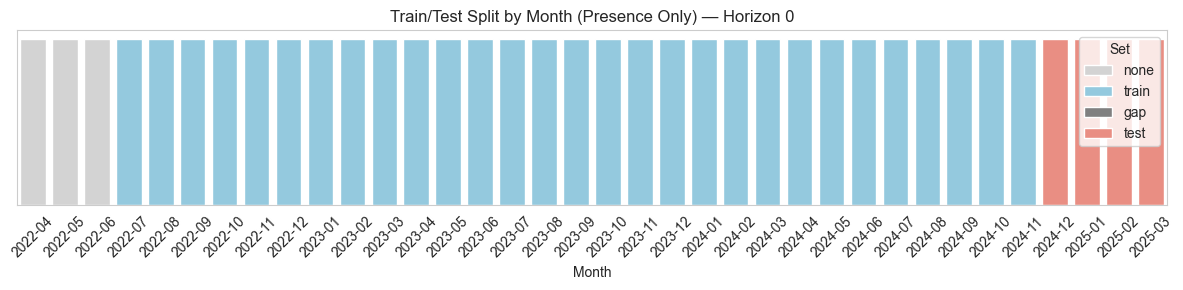

In [21]:
visualize_split_presence(splits[0]['train'], 
                         splits[0]['test'], label='Horizon 0')

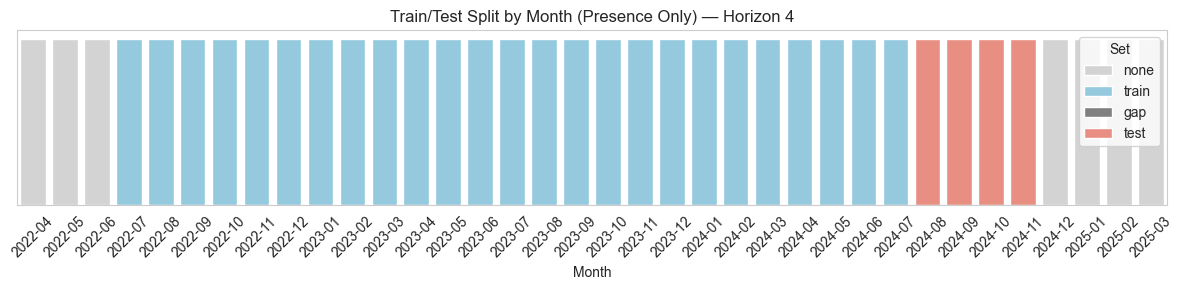

In [22]:
visualize_split_presence(splits[4]['train'], 
                         splits[4]['test'], label='Horizon 4')

**TIME SERIES CROSS VALIDATION**

In [23]:
N_SPLITS = 5
TEST_SIZE = 2

In [24]:
def plot_months_per_fold(df, n_splits=5, test_size=2, gap=0):
    # Ensure months are datetime for sorting and plotting
    df['Month'] = pd.to_datetime(df['Month'])
    
    months = df['Month']
    unique_months = sorted(months.unique())

    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size*680, gap=680*gap)
    
    # Map months to integers for plotting
    month_to_num = {m: i for i, m in enumerate(unique_months)}
    num_to_month = {i: m.strftime("%Y-%m") for i, m in enumerate(unique_months)}

    # Prepare plot
    fig, ax = plt.subplots(figsize=(14, 2 * n_splits))

    for fold, (train_idx, test_idx) in enumerate(tscv.split(months)):
        train_months = months.iloc[train_idx].unique()
        test_months = months.iloc[test_idx].unique()
        
        for m in train_months:
            ax.barh(fold, 1, left=month_to_num[m], color='skyblue')
        for m in test_months:
            ax.barh(fold, 1, left=month_to_num[m], color='salmon')

    # Formatting
    ax.set_yticks(range(n_splits))
    ax.set_yticklabels([f'Fold {i+1}' for i in range(n_splits)])
    ax.set_xticks(range(len(unique_months)))
    ax.set_xticklabels([num_to_month[i] for i in range(len(unique_months))], rotation=45, ha='right')
    ax.set_xlabel("Month")
    ax.set_title("Train (blue) and Test (red) Months per Fold")
    plt.tight_layout()
    plt.show()


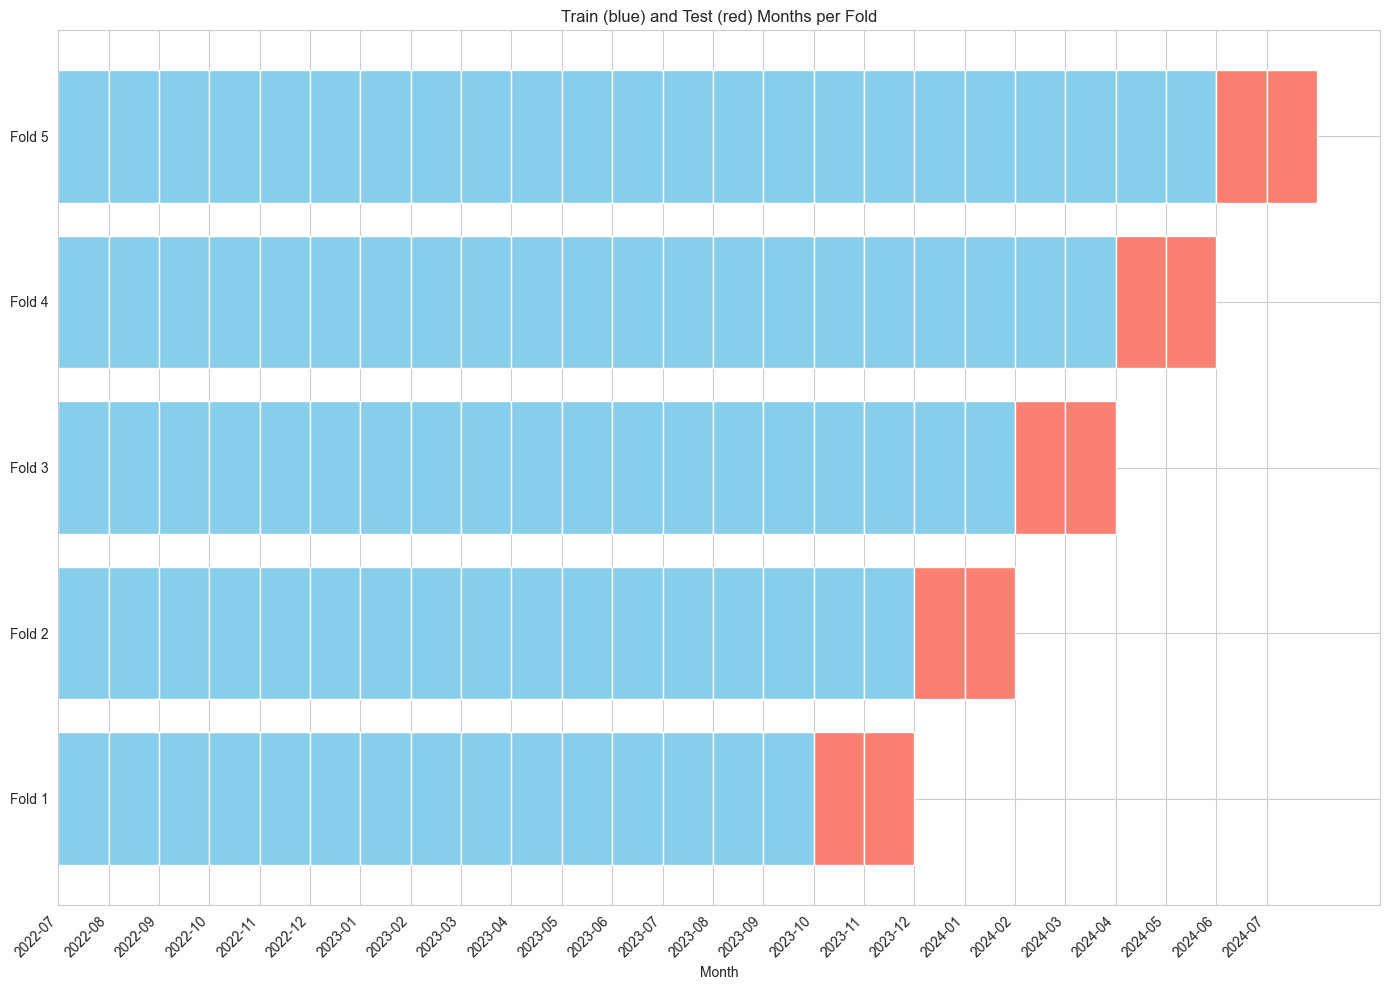

In [25]:
plot_months_per_fold(splits[4]['train'], n_splits=5, test_size=2, gap=0)


In [26]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from xgboost import XGBRegressor

def run_time_series_cv(
    df, 
    feature_cols, 
    target_col, 
    params=None, 
    n_splits=5, 
    test_size=2,
    gap=0, 
    verbose=True,
    return_model=False
):
    """
    Run time series cross-validation using XGBoost on panel time series data.

    Returns:
    - (mae, rmse) if return_model=False
    - (last_model, mean_rmse) if return_model=True
    """
    df_sorted = df.sort_values(by=['Month', 'Ward code']).reset_index(drop=True)

    X = df_sorted[feature_cols].copy()
    y = df_sorted[target_col].copy()

    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size*680, gap=gap*680)
    
    mae_list = []
    rmse_list = []
    last_model = None

    if verbose:
        print("\nModel parameters:")
        print(params or "Default")
        print("\nFeature columns:")
        print(feature_cols)

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

        model = XGBRegressor(enable_categorical=True, **(params or {}), random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = root_mean_squared_error(y_test, y_pred)

        mae_list.append(mae)
        rmse_list.append(rmse)

        if verbose:
            print(f"Fold {fold + 1}: MAE={mae:.4f}, RMSE={rmse:.4f}")

        last_model = model

    mean_mae = np.mean(mae_list)
    mean_rmse = np.mean(rmse_list)

    if verbose:
        print("\nAverage CV Performance:")
        print(f"Mean MAE:  {mean_mae:.4f}")
        print(f"Mean RMSE: {mean_rmse:.4f}")

    if return_model:
        return last_model, float(mean_rmse)
    else:
        return float(mean_mae), float(mean_rmse)


**MODEL WITH ONLY TEMPORAL FEATURES**

This basic model will include only the features from burglaries time series. 

In [27]:
df_train_h0 = splits[0]['train']
df_test_h0 = splits[0]['test']

In [28]:
df_train_h0.columns

Index(['Month', 'Ward code', 'lag_1', 'lag_2', 'lag_3', 'roll_mean_3',
       'month_sin', 'month_cos', 'Total population', 'Under 15 years',
       '15 to 64 years', '65 years and older', 'Total: All households',
       'One-person household', 'One-person household: Aged 66 years and over',
       'One-person household: Other', 'Single family household',
       'Other household types', 'Detached whole house or bungalow',
       'Semi-detached whole house or bungalow',
       'Terraced whole house or bungalow', 'Flat, maisonette or apartment',
       'A caravan or other mobile or temporary structure',
       'Total: All dwellings', 'Total: Occupied dwellings',
       'Unoccupied dwellings', 'Index of Multiple Deprivation (IMD) Score',
       'Income Score', 'Employment Score',
       'Education, Skills and Training Score',
       'Health Deprivation and Disability Score', 'Crime Score',
       'Barriers to Housing and Services Score', 'Living Environment Score',
       'stop_count', 't

In [29]:
feature_cols_time = [col for col in df_train_h0.columns if col.startswith(("lag_", "roll_", "month_", "Ward code"))]

results_base = run_time_series_cv(
    df=df_train_h0,
    feature_cols=feature_cols_time,
    target_col='target_t',
    n_splits=N_SPLITS,
    test_size=TEST_SIZE,
    gap=0,
    verbose=True
)


Model parameters:
Default

Feature columns:
['Ward code', 'lag_1', 'lag_2', 'lag_3', 'roll_mean_3', 'month_sin', 'month_cos']
Fold 1: MAE=3.0449, RMSE=4.0917
Fold 2: MAE=2.7840, RMSE=3.8500
Fold 3: MAE=2.8723, RMSE=3.8947
Fold 4: MAE=2.7972, RMSE=3.7853
Fold 5: MAE=2.8026, RMSE=3.7218

Average CV Performance:
Mean MAE:  2.8602
Mean RMSE: 3.8687


**MODEL WITH ONLY STATIC FEATURES**

This basic model will only include additional static features. 

In [30]:
features_cols_static = list(df_static_selected.columns)

results_static = run_time_series_cv(
    df=df_train_h0,
    feature_cols=features_cols_static,
    target_col='target_t',
    n_splits=N_SPLITS,
    test_size=TEST_SIZE,
    gap=0,
    verbose=True
)




Model parameters:
Default

Feature columns:
['Ward code', 'Index of Multiple Deprivation (IMD) Score', 'Income Score', 'Employment Score', 'Education, Skills and Training Score', 'Health Deprivation and Disability Score', 'Crime Score', 'Barriers to Housing and Services Score', 'Living Environment Score', 'Under 15 years', '15 to 64 years', '65 years and older', 'One-person household', 'One-person household: Aged 66 years and over', 'One-person household: Other', 'Single family household', 'Other household types', 'Detached whole house or bungalow', 'Semi-detached whole house or bungalow', 'Terraced whole house or bungalow', 'Flat, maisonette or apartment', 'A caravan or other mobile or temporary structure', 'Total: All dwellings', 'Unoccupied dwellings', 'stop_count']
Fold 1: MAE=2.6164, RMSE=3.5019
Fold 2: MAE=2.5408, RMSE=3.3788
Fold 3: MAE=2.5606, RMSE=3.3717
Fold 4: MAE=2.5585, RMSE=3.3685
Fold 5: MAE=2.5014, RMSE=3.3411

Average CV Performance:
Mean MAE:  2.5555
Mean RMSE: 3.392

**MODEL WITH ALL FEATURES**

In [31]:
features_cols_all = [col for col in df_train_h0.columns if col.startswith(("lag_", "roll_", "month_"))] + list(df_static_selected.columns)

results_all = run_time_series_cv(
    df=df_train_h0,
    feature_cols=features_cols_all,
    target_col='target_t',
    n_splits=5,
    gap=0,
    verbose=True
)




Model parameters:
Default

Feature columns:
['lag_1', 'lag_2', 'lag_3', 'roll_mean_3', 'month_sin', 'month_cos', 'Ward code', 'Index of Multiple Deprivation (IMD) Score', 'Income Score', 'Employment Score', 'Education, Skills and Training Score', 'Health Deprivation and Disability Score', 'Crime Score', 'Barriers to Housing and Services Score', 'Living Environment Score', 'Under 15 years', '15 to 64 years', '65 years and older', 'One-person household', 'One-person household: Aged 66 years and over', 'One-person household: Other', 'Single family household', 'Other household types', 'Detached whole house or bungalow', 'Semi-detached whole house or bungalow', 'Terraced whole house or bungalow', 'Flat, maisonette or apartment', 'A caravan or other mobile or temporary structure', 'Total: All dwellings', 'Unoccupied dwellings', 'stop_count']
Fold 1: MAE=3.0786, RMSE=4.1540
Fold 2: MAE=2.7520, RMSE=3.8309
Fold 3: MAE=2.9035, RMSE=3.9360
Fold 4: MAE=2.8787, RMSE=3.8333
Fold 5: MAE=2.7902, RMS

**FEATURE PRUNING AND PARAMETER TUNING**

In [32]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import numpy as np

def tune_time_series(df, param_dist, feature_cols, target_col,
                             n_splits=5, test_size=2, n_iter=10):
    """
    Tunes XGBoost hyperparameters using time series cross-validation (RandomizedSearchCV).

    Returns:
        best_model: Trained best XGBRegressor model.
        best_params: Best hyperparameters.
        mean_rmse: Mean RMSE across all CV folds.
    """
    
    # Sort by time and ward (IMPORTANT) / assumption is that it is already sorted, but just to make sure
    df_sorted = df.sort_values(by=['Month', 'Ward code']).reset_index(drop=True)

    X = df_sorted[feature_cols].copy()
    y = df_sorted[target_col].copy()

    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size*680)

    xgb_model = XGBRegressor(random_state=42, enable_categorical=True)

    search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=tscv,
        scoring='neg_mean_squared_error',
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    search.fit(X, y)

    best_model = search.best_estimator_
    best_params = search.best_params_
    mean_rmse = (-search.best_score_)**0.5
    
    print(f"\n Best model parameters: {best_params}")

    print(f"\nMean RMSE: {mean_rmse:.4f}")

    return best_model, best_params, mean_rmse


In [33]:
param_dist = {
    "n_estimators": [100, 300, 500, 700],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5],
    "gamma": [0, 0.1, 0.3, 0.5],
    "reg_alpha": [0, 0.01, 0.1],
    "reg_lambda": [0.5, 1.0, 2.0]
}

In [34]:
best_model_h0, best_params_h0, mean_rmse_h0 = tune_time_series(
    df=df_train_h0,
    param_dist=param_dist,
    feature_cols=features_cols_all,
    target_col='target_t',
    n_splits=5,
    test_size=2,
    n_iter=1
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits

 Best model parameters: {'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0.1, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 1.0}

Mean RMSE: 3.9194


In [35]:
import xgboost as xgb
import matplotlib.pyplot as plt

def plot_feature_importance(model, max_num_features=20):
    """
    Plot feature importance from an XGBoost model.
    """
    fig, ax = plt.subplots(figsize=(10, max_num_features/2))
    xgb.plot_importance(model, importance_type='gain', max_num_features=max_num_features, ax=ax)
    plt.title("XGBoost Feature Importance (Gain)")
    plt.show()


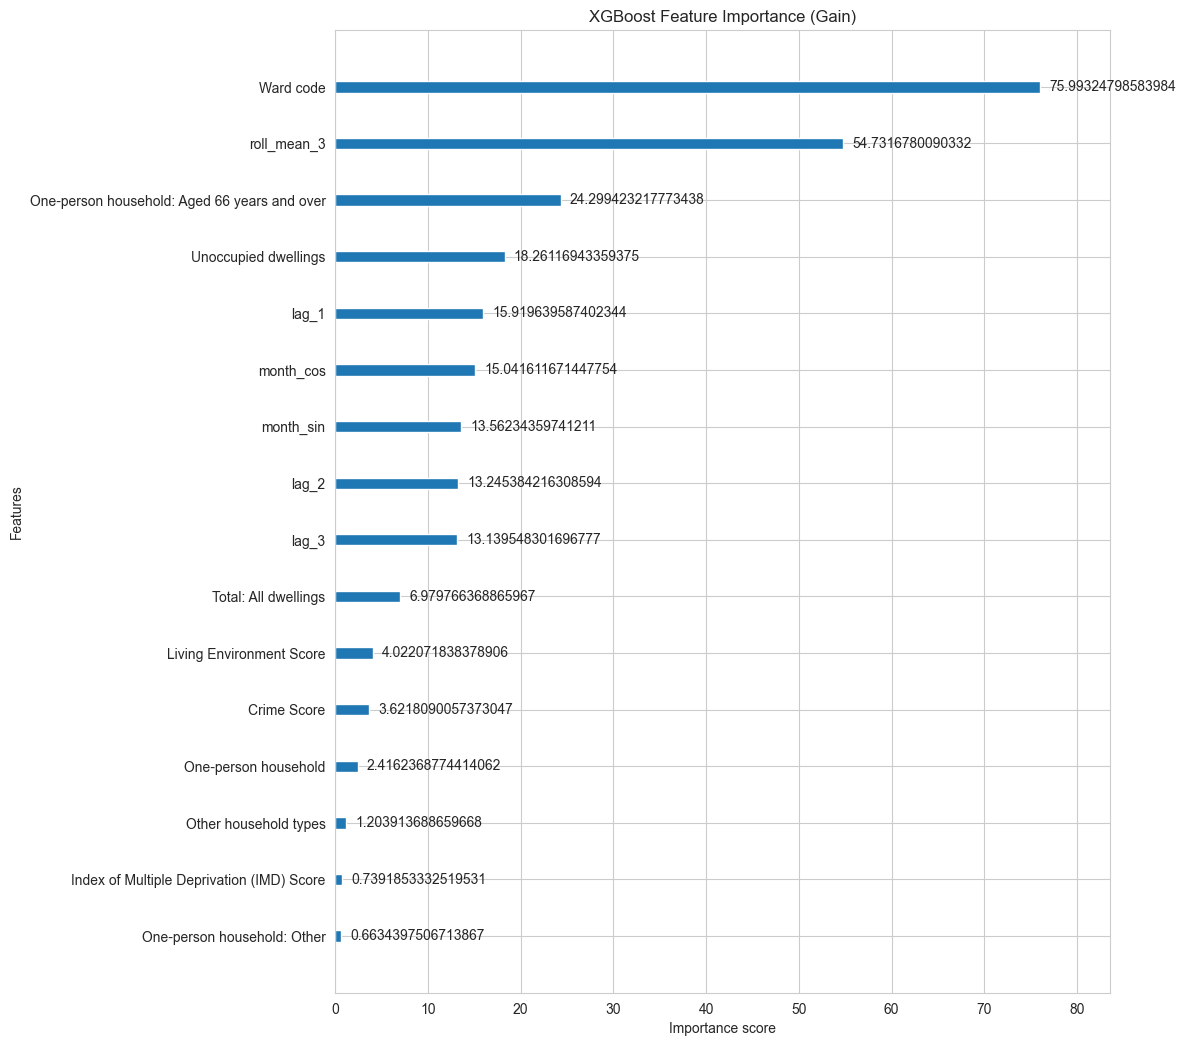

In [36]:
plot_feature_importance(best_model_h0, max_num_features=25)

In [37]:
def feature_pruning_by_importance(model, feature_names, threshold=0.01, return_scores=False):
    booster = model.get_booster()
    importance_dict = booster.get_score(importance_type='gain')
    total_gain = sum(importance_dict.values())
    importance_norm = {k: v / total_gain for k, v in importance_dict.items()}
    retained_features = [f for f in feature_names if importance_norm.get(f, 0) >= threshold]
    pruned_count = len(feature_names) - len(retained_features)

    print(f"Pruned {pruned_count} features below gain threshold {threshold}")

    if return_scores:
        return retained_features, importance_norm
    return retained_features


In [38]:
threshold=0.01
pruned_features = feature_pruning_by_importance(best_model_h0, features_cols_all)

print(f"Selected {len(pruned_features)} features with importance >= {threshold}")
print(pruned_features)


Pruned 19 features below gain threshold 0.01
Selected 12 features with importance >= 0.01
['lag_1', 'lag_2', 'lag_3', 'roll_mean_3', 'month_sin', 'month_cos', 'Ward code', 'Crime Score', 'Living Environment Score', 'One-person household: Aged 66 years and over', 'Total: All dwellings', 'Unoccupied dwellings']


In [109]:
def feature_pruning_top_k(model, feature_names, top_k=6, return_scores=False):
    booster = model.get_booster()
    importance_dict = booster.get_score(importance_type='gain')
    
    # Fallback for features with zero importance
    for f in feature_names:
        importance_dict.setdefault(f, 0.0)

    sorted_feats = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
    retained_features = [feat for feat, _ in sorted_feats[:top_k]]

    pruned_count = len(feature_names) - len(retained_features)
    print(f"Pruned {pruned_count} features, retained top {top_k} by gain.")

    if return_scores:
        total_gain = sum(importance_dict.values())
        importance_norm = {k: v / total_gain if total_gain > 0 else 0.0 for k, v in importance_dict.items()}
        return retained_features, importance_norm
    return retained_features


In [39]:
run_time_series_cv(df_train_h0, feature_cols=pruned_features, target_col='target_t', params=best_params_h0, verbose=False)

(2.9288450717926025, 3.9368778228759767)

In [40]:
final_model_h0, final_params_h0, final_rmse_h0 = tune_time_series(
    df=df_train_h0,
    param_dist=param_dist,
    feature_cols=pruned_features,
    target_col='target_t',
    n_splits=5,
    n_iter=2
)

Fitting 5 folds for each of 2 candidates, totalling 10 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.3335


**TRAIN SEPARATE MODELS PER FORECAST HORIZON (UP TO 4 MONTHS)**

In [148]:
N_SPLITS = 5
N_TEST_SIZE = 2
N_ITER_INITIAL = 2
N_ITER_FINAL = 4


# very low for now

In [149]:
forecast_models_summary = {
    0: {},
    1: {},
    2: {},
    3: {},
    4: {}
}


In [150]:
# INCLUDE TEST_SIZE

def full_pipeline_per_horizon(
    df_train,
    horizon_label,
    feature_cols_all,
    target_col,
    param_dist,
    n_splits=5,
    tscv_gap=0,
    pruning_threshold=0.01,
    tuning_iter_initial=5,
    tuning_iter_final=5,
    verbose=True, 
    test_size=2
):
    print(f"\n{'='*30}\nHORIZON {horizon_label}\n{'='*30}")

    # Step 1: Initial CV evaluation with all features
    print("\n▶ Initial CV with all features:")
    run_time_series_cv(
        df=df_train,
        feature_cols=feature_cols_all,
        target_col=target_col,
        n_splits=n_splits,
        gap=tscv_gap,
        verbose=verbose, 
        test_size=test_size
    )

    # Step 2: Hyperparameter tuning with all features
    print("\n▶ Tuning hyperparameters (all features):")
    model_all, params_all, rmse_all = tune_time_series(
        df=df_train,
        param_dist=param_dist,
        feature_cols=feature_cols_all,
        target_col=target_col,
        n_splits=n_splits,
        n_iter=tuning_iter_initial, 
        test_size=test_size
    )

    # Step 3: Feature pruning
    print("\n▶ Pruning features based on importance:")
    pruned_features = feature_pruning_by_importance(model_all, feature_cols_all, threshold=pruning_threshold)
    print(f"Selected {len(pruned_features)} features with importance >= {pruning_threshold}\n")

    plot_feature_importance(model_all, max_num_features=25)

    # Step 4: Final tuning with pruned features
    print("\n▶ Tuning with pruned features:")
    final_model, final_params, final_rmse = tune_time_series(
        df=df_train,
        param_dist=param_dist,
        feature_cols=pruned_features,
        target_col=target_col,
        n_splits=n_splits,
        n_iter=tuning_iter_final, 
        test_size=test_size
    )

    # Store final results
    forecast_models_summary[horizon_label]['model'] = final_model
    forecast_models_summary[horizon_label]['params'] = final_params
    forecast_models_summary[horizon_label]['rmse'] = final_rmse
    forecast_models_summary[horizon_label]['features'] = pruned_features


In [159]:
def full_pipeline_per_horizon(
    df_train,
    horizon_label,
    feature_cols_all,
    target_col,
    param_dist,
    n_splits=5,
    tscv_gap=0,
    pruning_threshold=0.01,
    top_k=5,
    pruning_method="threshold",  # "threshold" or "topk"
    tuning_iter_initial=5,
    tuning_iter_final=5,
    verbose=True,
    test_size=2,
    tune=False,
    prune=False,
    experiments_df=None,
    include_static=True
):
    from xgboost import XGBRegressor
    from copy import deepcopy
    import pandas as pd

    print(f"\n{'='*30}\nHORIZON {horizon_label}\n{'='*30}")

    print("\n▶ Initial CV with all features:")
    run_time_series_cv(
        df=df_train,
        feature_cols=feature_cols_all,
        target_col=target_col,
        n_splits=n_splits,
        gap=tscv_gap,
        verbose=verbose,
        test_size=test_size
    )

    if tune:
        print("\n▶ Tuning hyperparameters (all features):")
        model_all, params_all, rmse_all = tune_time_series(
            df=df_train,
            param_dist=param_dist,
            feature_cols=feature_cols_all,
            target_col=target_col,
            n_splits=n_splits,
            n_iter=tuning_iter_initial,
            test_size=test_size
        )
        selected_features = feature_cols_all
        model_to_store = model_all
        final_params_to_store = params_all
        final_rmse_to_store = rmse_all

        if prune:
            print(f"\n▶ Pruning features using method: {pruning_method}")
            if pruning_method == "threshold":
                pruned_features = feature_pruning_by_importance(model_all, feature_cols_all, threshold=pruning_threshold)
            elif pruning_method == "topk":
                pruned_features = feature_pruning_top_k(model_all, feature_cols_all, top_k=top_k)
            else:
                raise ValueError("pruning_method must be either 'threshold' or 'topk'")

            print(f"Selected {len(pruned_features)} features")
            plot_feature_importance(model_all, max_num_features=25)

            print("\n▶ Final tuning with pruned features:")
            final_model, final_params, final_rmse = tune_time_series(
                df=df_train,
                param_dist=param_dist,
                feature_cols=pruned_features,
                target_col=target_col,
                n_splits=n_splits,
                n_iter=tuning_iter_final,
                test_size=test_size
            )
            selected_features = pruned_features
            model_to_store = final_model
            final_params_to_store = final_params
            final_rmse_to_store = final_rmse

    else:
        print("\n▶ Skipping tuning — evaluating with time series CV:")

        if any(isinstance(v, list) for v in param_dist.values()):
            print("⚠️ Detected search space in param_dist. Using XGBoost defaults instead.")
            model_params = {}
        else:
            model_params = deepcopy(param_dist)

        model_to_store, final_rmse_to_store = run_time_series_cv(
            df=df_train,
            feature_cols=feature_cols_all,
            target_col=target_col,
            params=model_params,
            n_splits=n_splits,
            gap=tscv_gap,
            test_size=test_size,
            verbose=verbose,
            return_model=True
        )
        selected_features = feature_cols_all
        final_params_to_store = model_params

        if prune:
            print(f"\n▶ Pruning features using method: {pruning_method}")
            if pruning_method == "threshold":
                pruned_features = feature_pruning_by_importance(model_to_store, feature_cols_all, threshold=pruning_threshold)
            elif pruning_method == "topk":
                pruned_features = feature_pruning_top_k(model_to_store, feature_cols_all, top_k=top_k)
            else:
                raise ValueError("pruning_method must be either 'threshold' or 'topk'")

            print(f"Selected {len(pruned_features)} features")
            plot_feature_importance(model_to_store, max_num_features=25)

            model_to_store, final_rmse_to_store = run_time_series_cv(
                df=df_train,
                feature_cols=pruned_features,
                target_col=target_col,
                params=model_params,
                n_splits=n_splits,
                gap=tscv_gap,
                test_size=test_size,
                verbose=verbose,
                return_model=True
            )
            selected_features = pruned_features

    forecast_models_summary[horizon_label]['model'] = model_to_store
    forecast_models_summary[horizon_label]['params'] = final_params_to_store
    forecast_models_summary[horizon_label]['rmse'] = final_rmse_to_store
    forecast_models_summary[horizon_label]['features'] = selected_features

    if experiments_df is not None:
        experiments_df.loc[len(experiments_df)] = {
            'horizon': horizon_label,
            'rmse': final_rmse_to_store,
            'n_features': len(selected_features),
            'tuned': tune,
            'pruned': prune,
            'pruning_method': pruning_method, 
            'include_static': include_static
        }


In [160]:
# # XGBOOST
# param_dist = {
#     'n_estimators': 300,          # More trees (boost rounds) for stability
#     'learning_rate': 0.07,        # Lower learning rate = slower, more generalizable learning
#     'max_depth': 5,               # Shallow trees to reduce variance (avoid overfitting)
#     'subsample': 0.9,             # Use 80% of samples per tree (adds randomness)
#     'colsample_bytree': 0.9,      # Use 80% of features per tree (reduces correlation)
#     'reg_alpha': 0.2,             # L1 regularization (sparsity)
#     'reg_lambda': 1.0,            # L2 regularization (shrinkage)
#     'min_child_weight': 3,        # Minimum sum of instance weight (hessian) needed in a child
#     'gamma': 0.1,                 # Minimum loss reduction to split (prevents over-splitting)
# }



HORIZON 0

▶ Initial CV with all features:

▶ Tuning hyperparameters (all features):
Fitting 5 folds for each of 2 candidates, totalling 10 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.3327

▶ Pruning features using method: threshold
Pruned 28 features below gain threshold 0.1
Selected 3 features


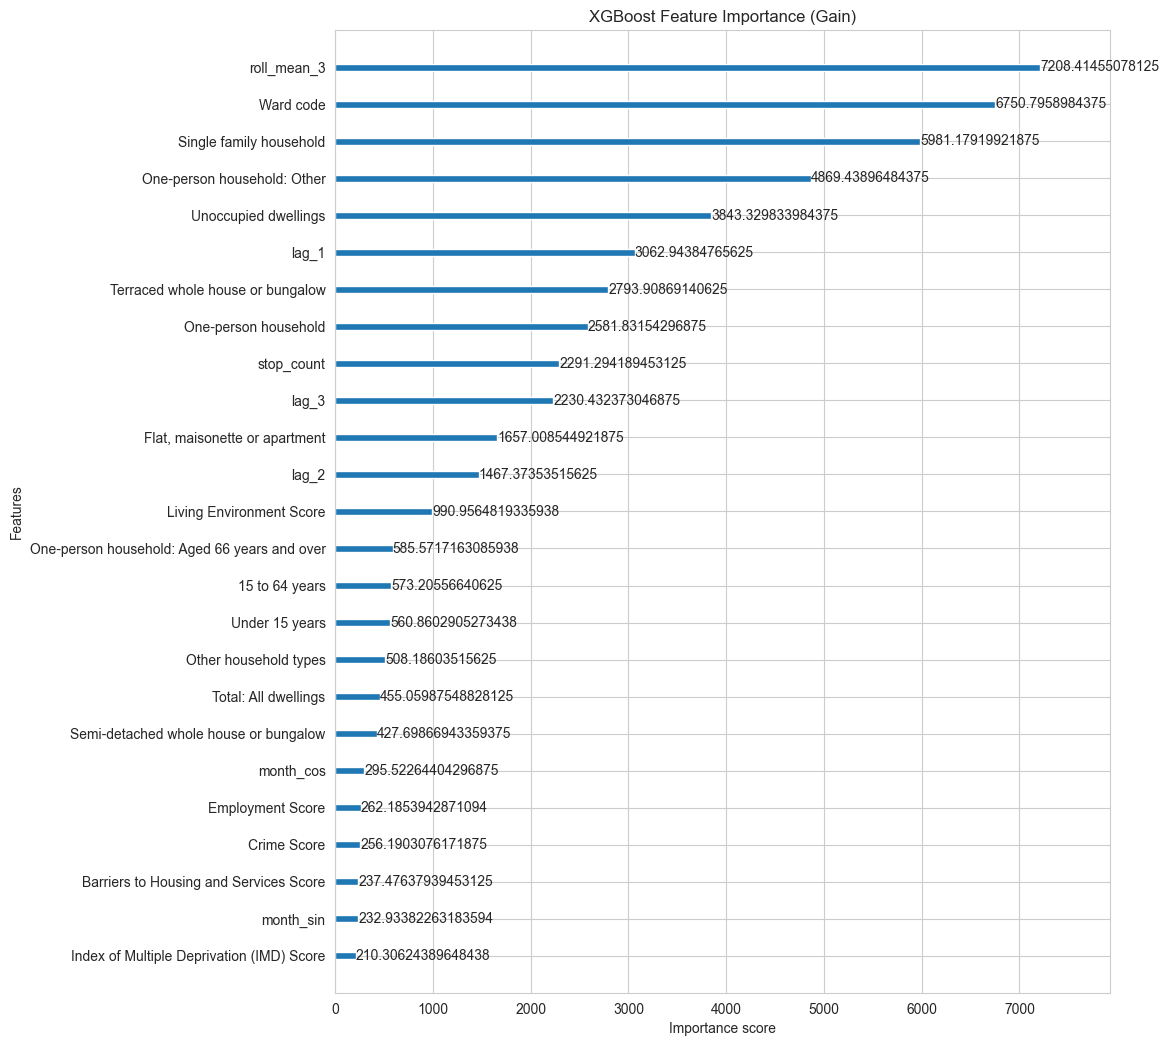


▶ Final tuning with pruned features:
Fitting 5 folds for each of 4 candidates, totalling 20 fits

 Best model parameters: {'subsample': 1.0, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'n_estimators': 700, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.6}

Mean RMSE: 3.3459

HORIZON 1

▶ Initial CV with all features:

▶ Tuning hyperparameters (all features):
Fitting 5 folds for each of 2 candidates, totalling 10 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.3837

▶ Pruning features using method: threshold
Pruned 28 features below gain threshold 0.1
Selected 3 features


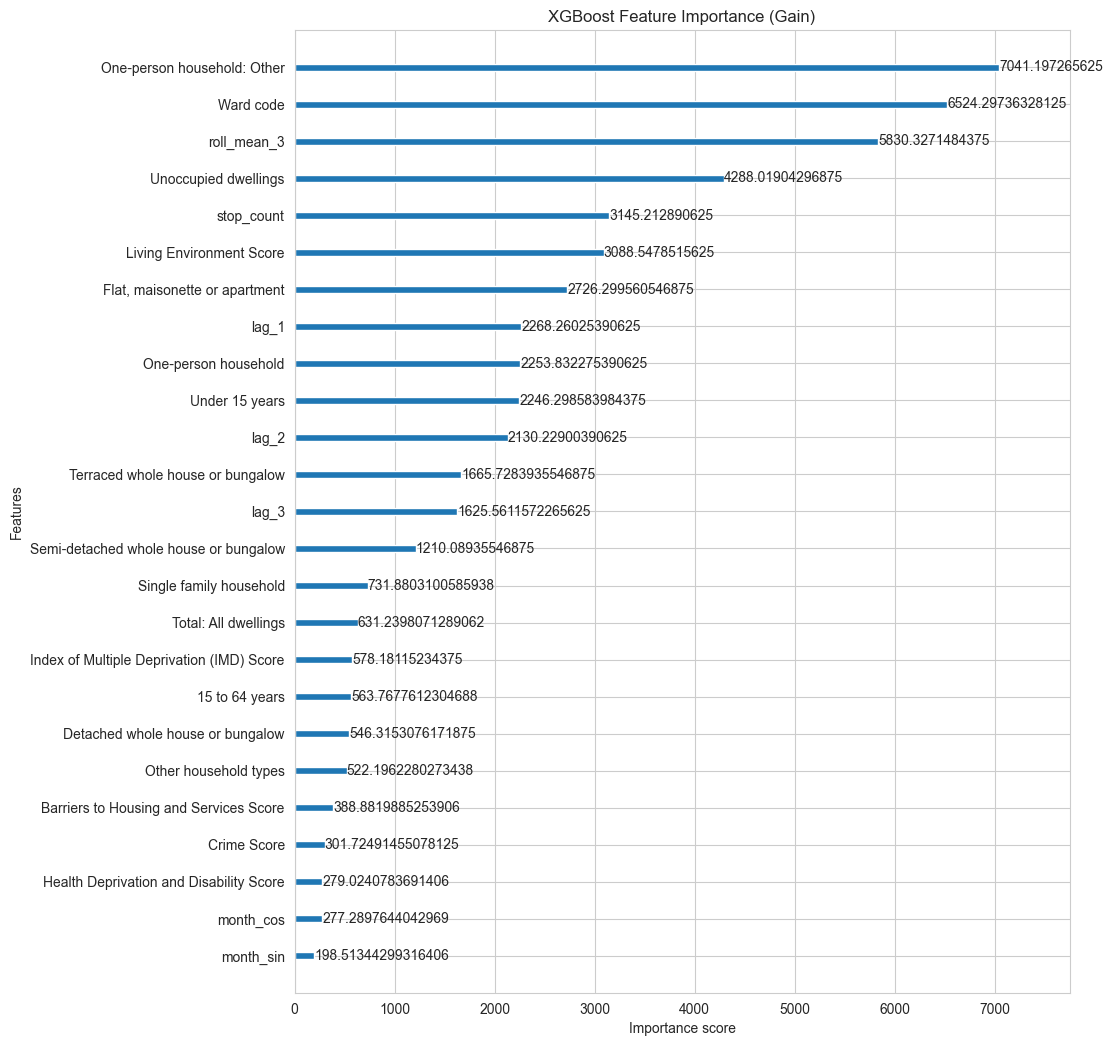


▶ Final tuning with pruned features:
Fitting 5 folds for each of 4 candidates, totalling 20 fits

 Best model parameters: {'subsample': 1.0, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'n_estimators': 700, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.6}

Mean RMSE: 3.3962

HORIZON 2

▶ Initial CV with all features:

▶ Tuning hyperparameters (all features):
Fitting 5 folds for each of 2 candidates, totalling 10 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.3951

▶ Pruning features using method: threshold
Pruned 28 features below gain threshold 0.1
Selected 3 features


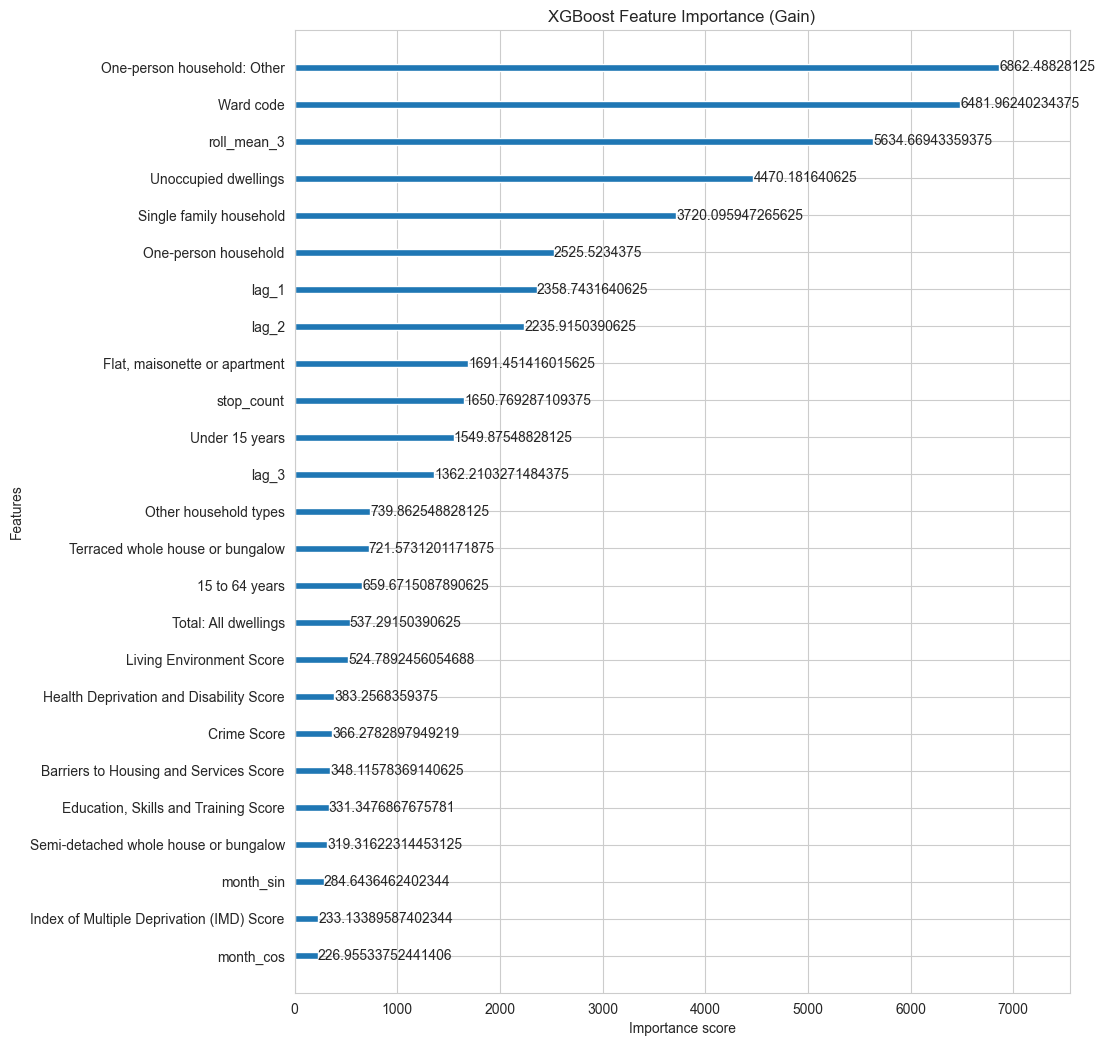


▶ Final tuning with pruned features:
Fitting 5 folds for each of 4 candidates, totalling 20 fits

 Best model parameters: {'subsample': 1.0, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'n_estimators': 700, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.6}

Mean RMSE: 3.4187

HORIZON 3

▶ Initial CV with all features:

▶ Tuning hyperparameters (all features):
Fitting 5 folds for each of 2 candidates, totalling 10 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.4056

▶ Pruning features using method: threshold
Pruned 28 features below gain threshold 0.1
Selected 3 features


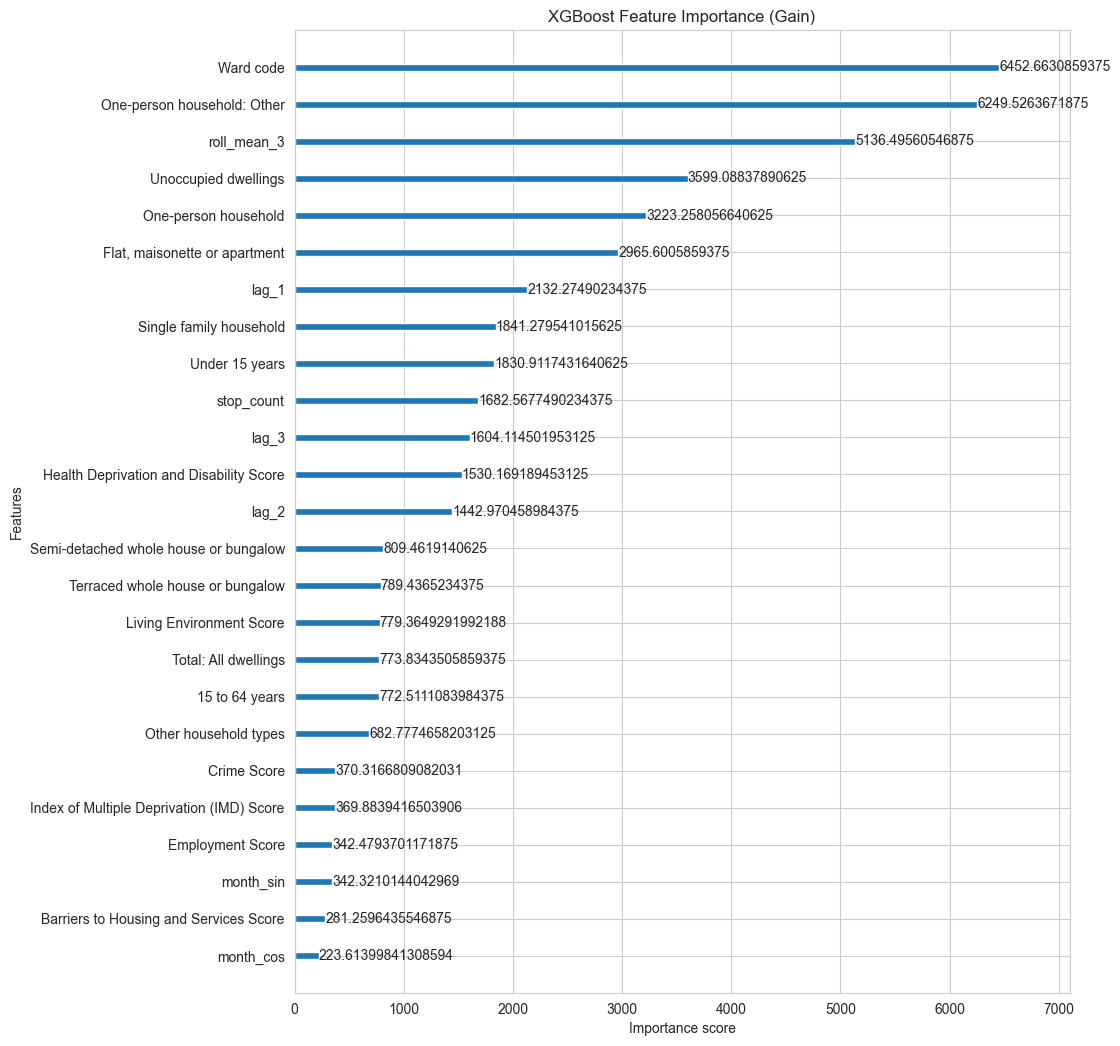


▶ Final tuning with pruned features:
Fitting 5 folds for each of 4 candidates, totalling 20 fits

 Best model parameters: {'subsample': 1.0, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'n_estimators': 700, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.6}

Mean RMSE: 3.4439

HORIZON 4

▶ Initial CV with all features:

▶ Tuning hyperparameters (all features):
Fitting 5 folds for each of 2 candidates, totalling 10 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.4127

▶ Pruning features using method: threshold
Pruned 28 features below gain threshold 0.1
Selected 3 features


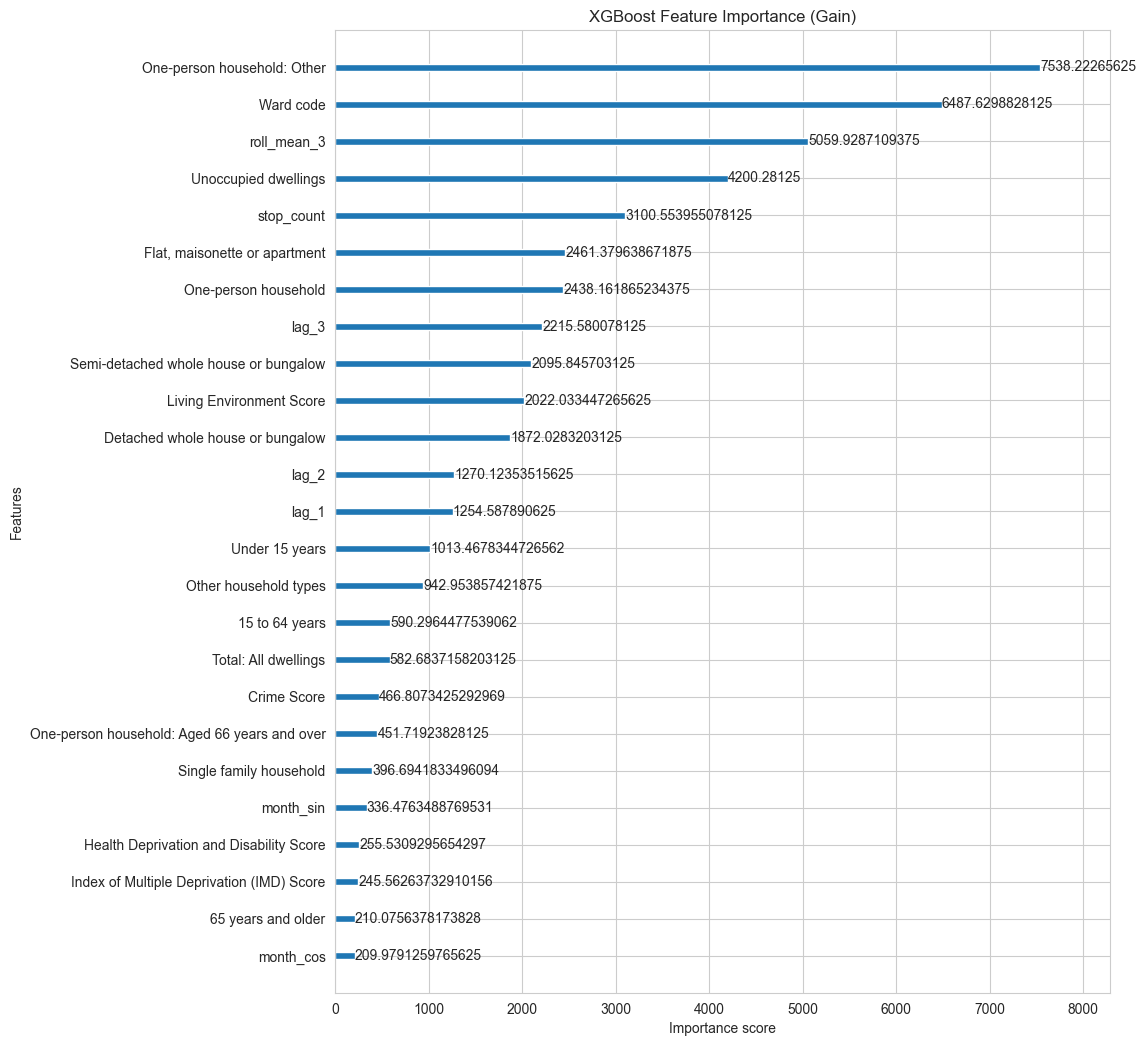


▶ Final tuning with pruned features:
Fitting 5 folds for each of 4 candidates, totalling 20 fits

 Best model parameters: {'subsample': 0.8, 'reg_lambda': 2.0, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 0.8}

Mean RMSE: 3.4675

HORIZON 0

▶ Initial CV with all features:

▶ Tuning hyperparameters (all features):
Fitting 5 folds for each of 2 candidates, totalling 10 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.3327

▶ Pruning features using method: topk
Pruned 26 features, retained top 5 by gain.
Selected 5 features


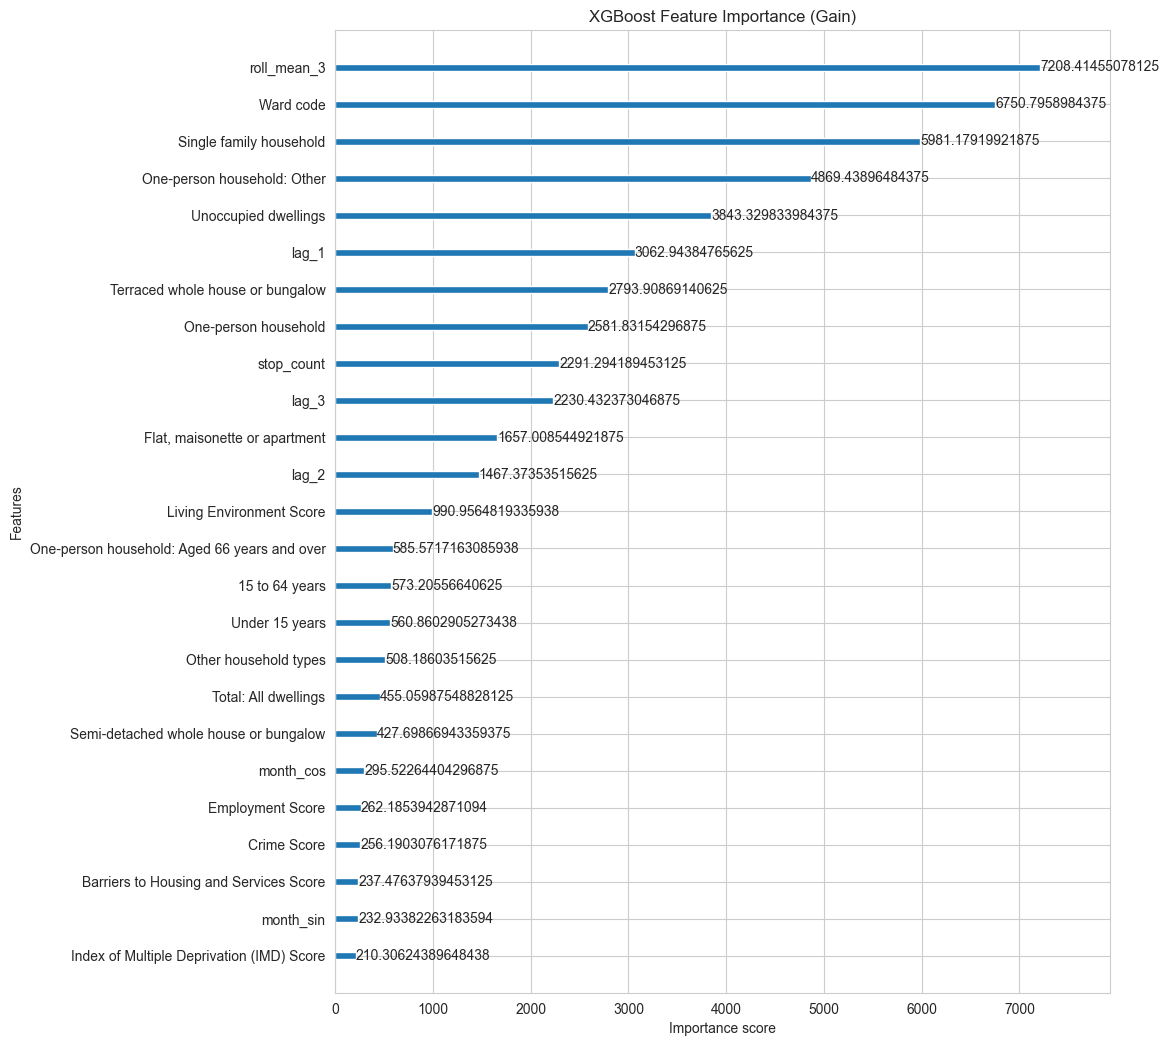


▶ Final tuning with pruned features:
Fitting 5 folds for each of 4 candidates, totalling 20 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.3440

HORIZON 1

▶ Initial CV with all features:

▶ Tuning hyperparameters (all features):
Fitting 5 folds for each of 2 candidates, totalling 10 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.3837

▶ Pruning features using method: topk
Pruned 26 features, retained top 5 by gain.
Selected 5 features


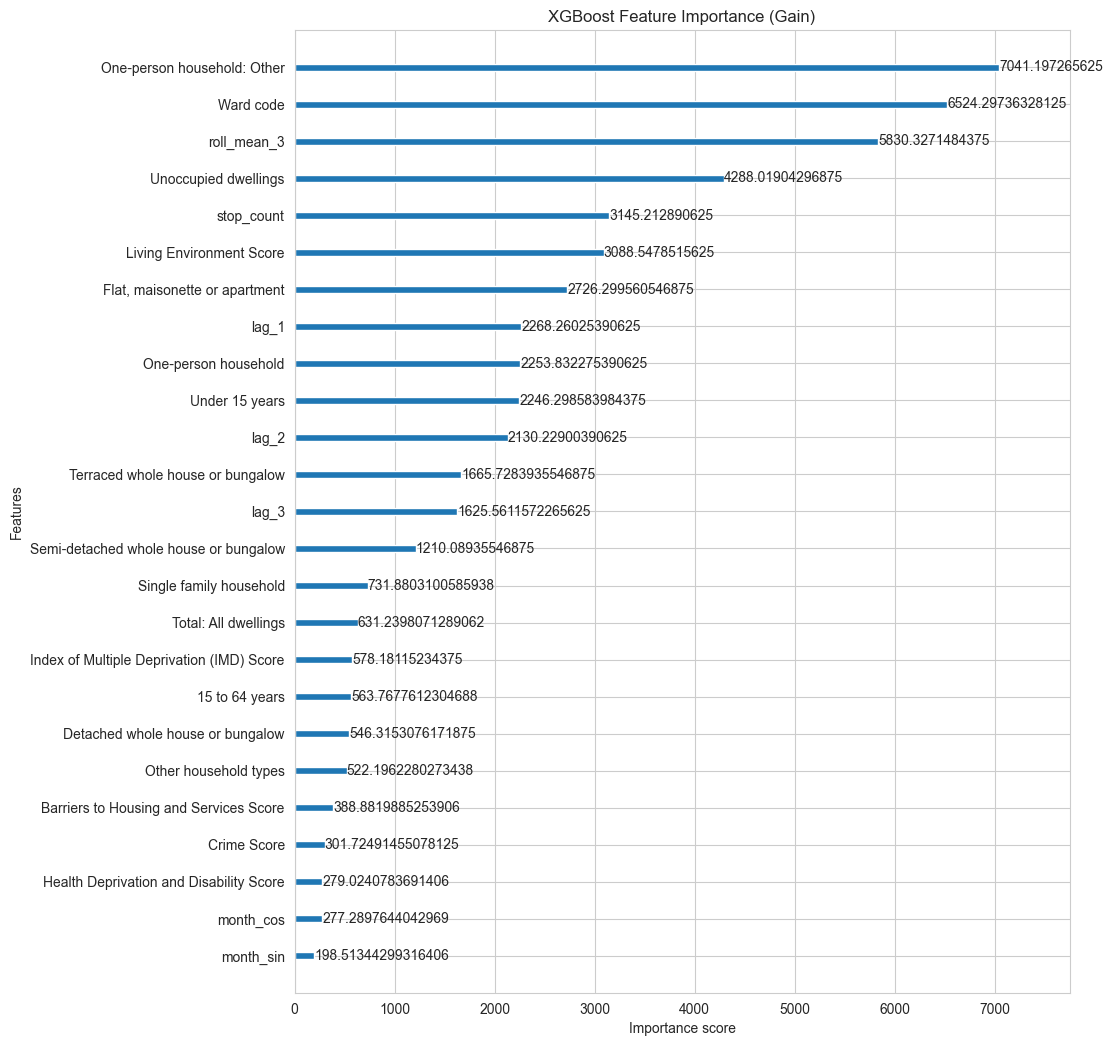


▶ Final tuning with pruned features:
Fitting 5 folds for each of 4 candidates, totalling 20 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.3862

HORIZON 2

▶ Initial CV with all features:

▶ Tuning hyperparameters (all features):
Fitting 5 folds for each of 2 candidates, totalling 10 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.3951

▶ Pruning features using method: topk
Pruned 26 features, retained top 5 by gain.
Selected 5 features


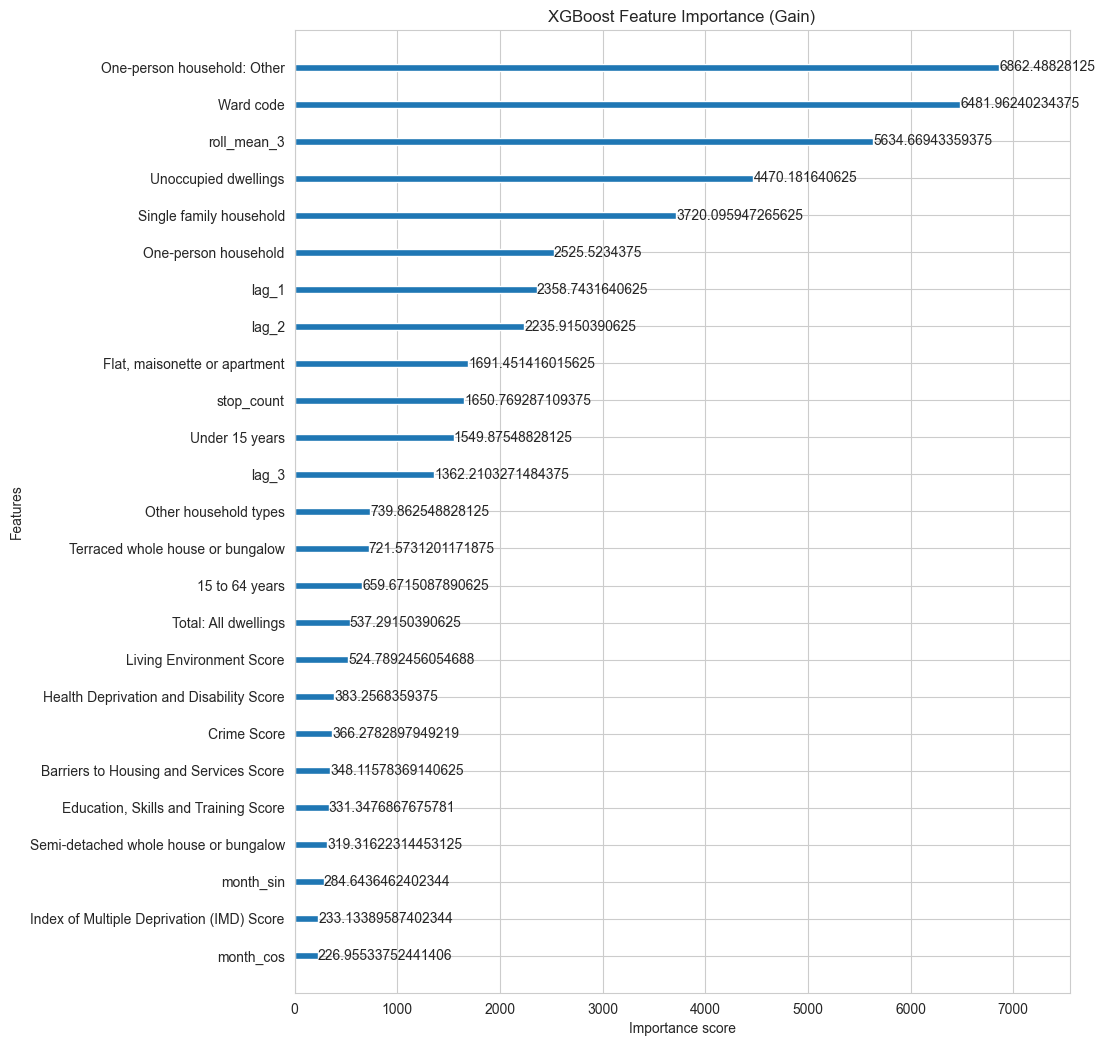


▶ Final tuning with pruned features:
Fitting 5 folds for each of 4 candidates, totalling 20 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.3989

HORIZON 3

▶ Initial CV with all features:

▶ Tuning hyperparameters (all features):
Fitting 5 folds for each of 2 candidates, totalling 10 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.4056

▶ Pruning features using method: topk
Pruned 26 features, retained top 5 by gain.
Selected 5 features


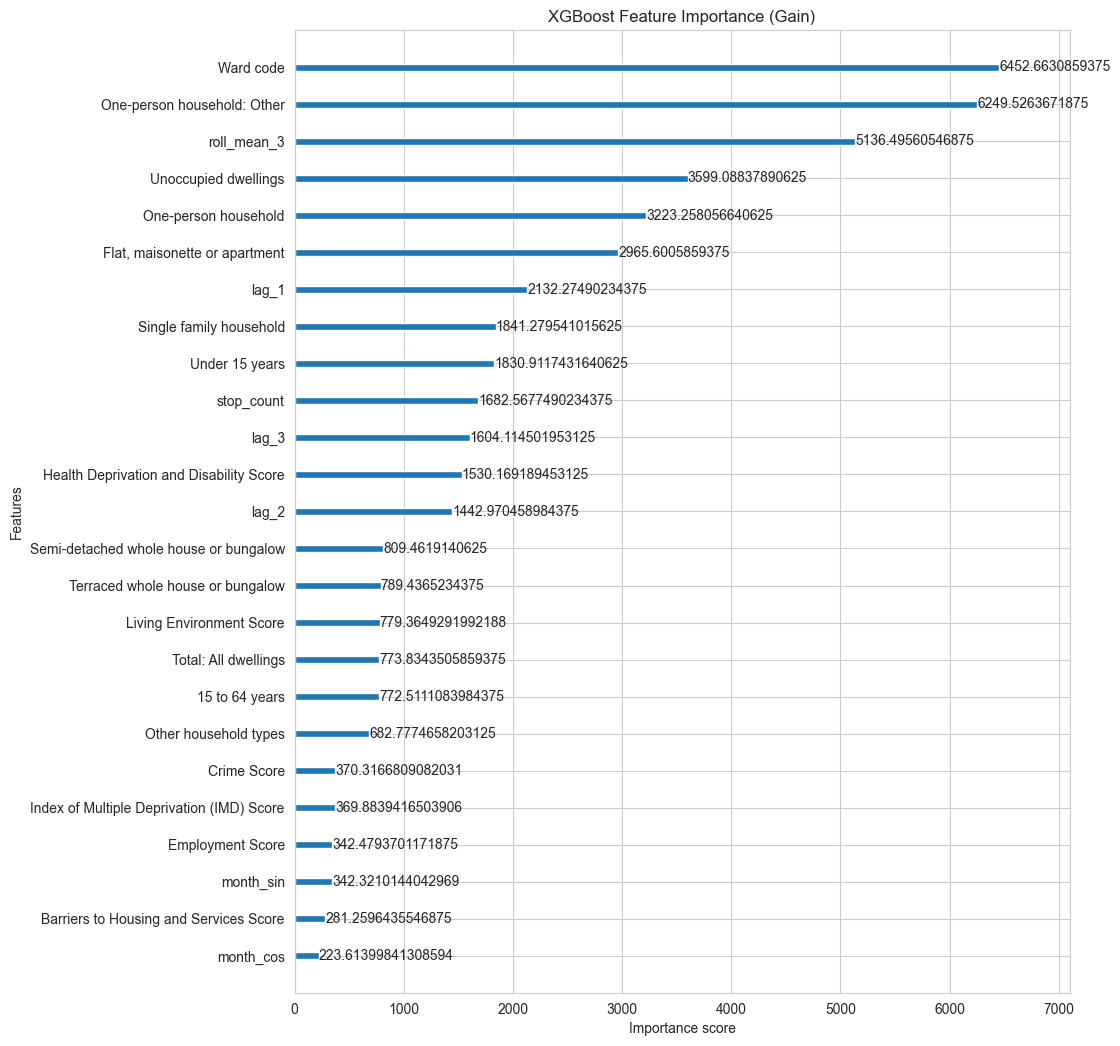


▶ Final tuning with pruned features:
Fitting 5 folds for each of 4 candidates, totalling 20 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.4216

HORIZON 4

▶ Initial CV with all features:

▶ Tuning hyperparameters (all features):
Fitting 5 folds for each of 2 candidates, totalling 10 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.4127

▶ Pruning features using method: topk
Pruned 26 features, retained top 5 by gain.
Selected 5 features


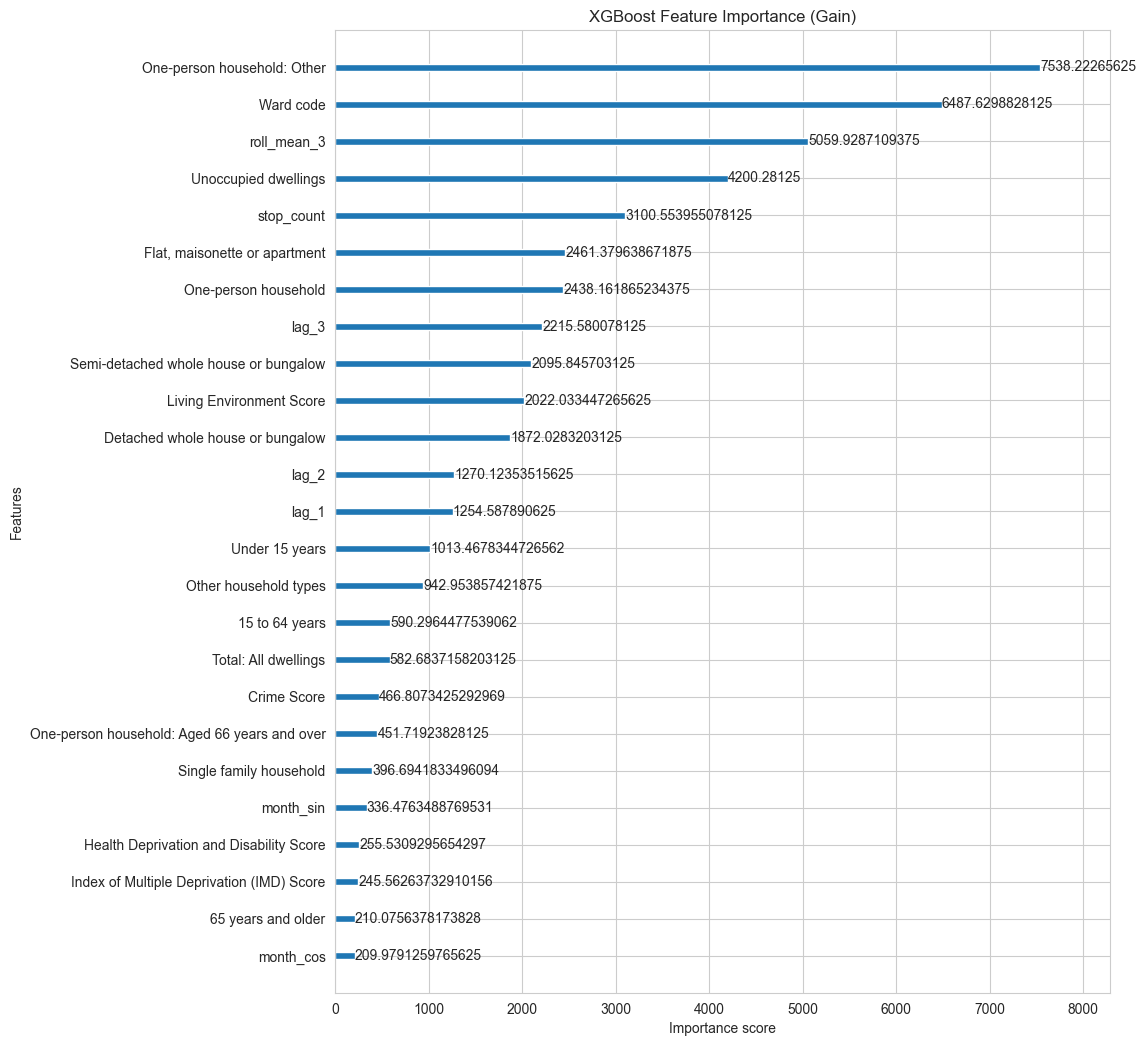


▶ Final tuning with pruned features:
Fitting 5 folds for each of 4 candidates, totalling 20 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.4289

HORIZON 0

▶ Initial CV with all features:

▶ Tuning hyperparameters (all features):
Fitting 5 folds for each of 2 candidates, totalling 10 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.5285

▶ Pruning features using method: threshold
Pruned 2 features below gain threshold 0.1
Selected 4 features


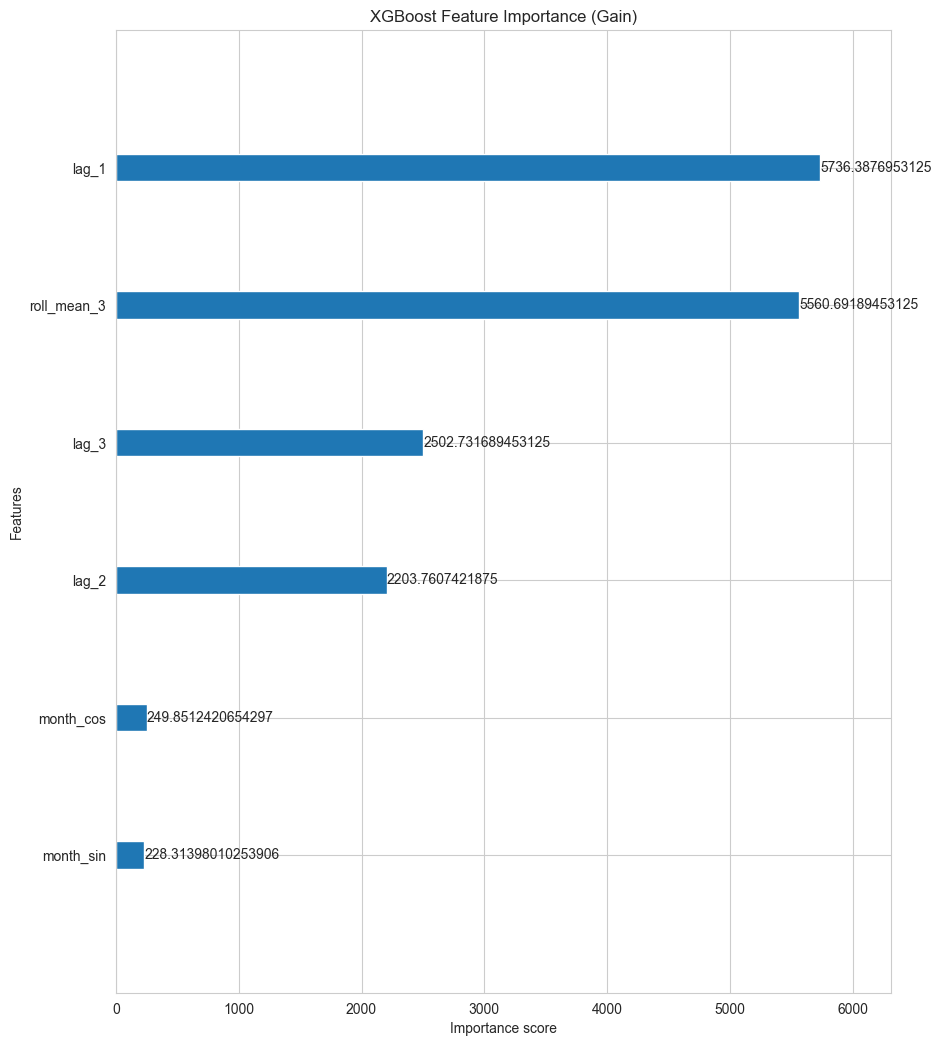


▶ Final tuning with pruned features:
Fitting 5 folds for each of 4 candidates, totalling 20 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.5351

HORIZON 1

▶ Initial CV with all features:

▶ Tuning hyperparameters (all features):
Fitting 5 folds for each of 2 candidates, totalling 10 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.6475

▶ Pruning features using method: threshold
Pruned 2 features below gain threshold 0.1
Selected 4 features


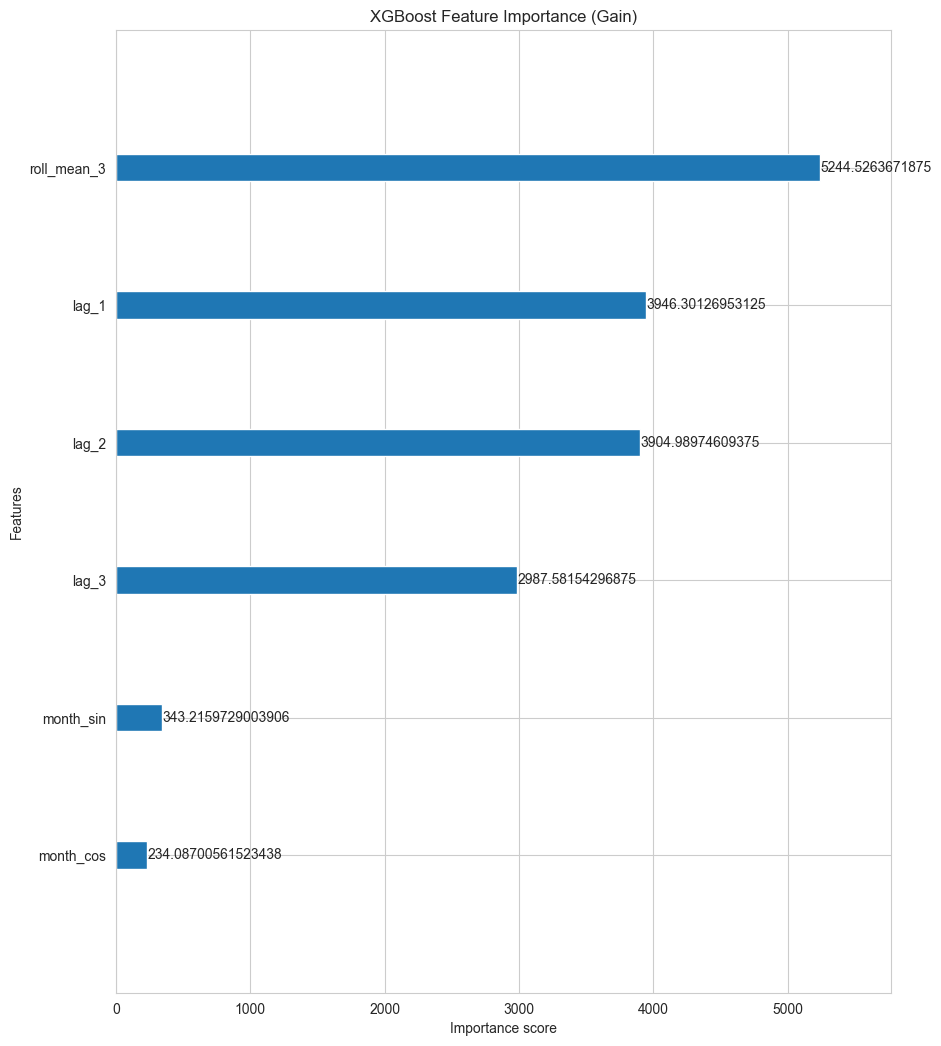


▶ Final tuning with pruned features:
Fitting 5 folds for each of 4 candidates, totalling 20 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.6604

HORIZON 2

▶ Initial CV with all features:

▶ Tuning hyperparameters (all features):
Fitting 5 folds for each of 2 candidates, totalling 10 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.6698

▶ Pruning features using method: threshold
Pruned 2 features below gain threshold 0.1
Selected 4 features


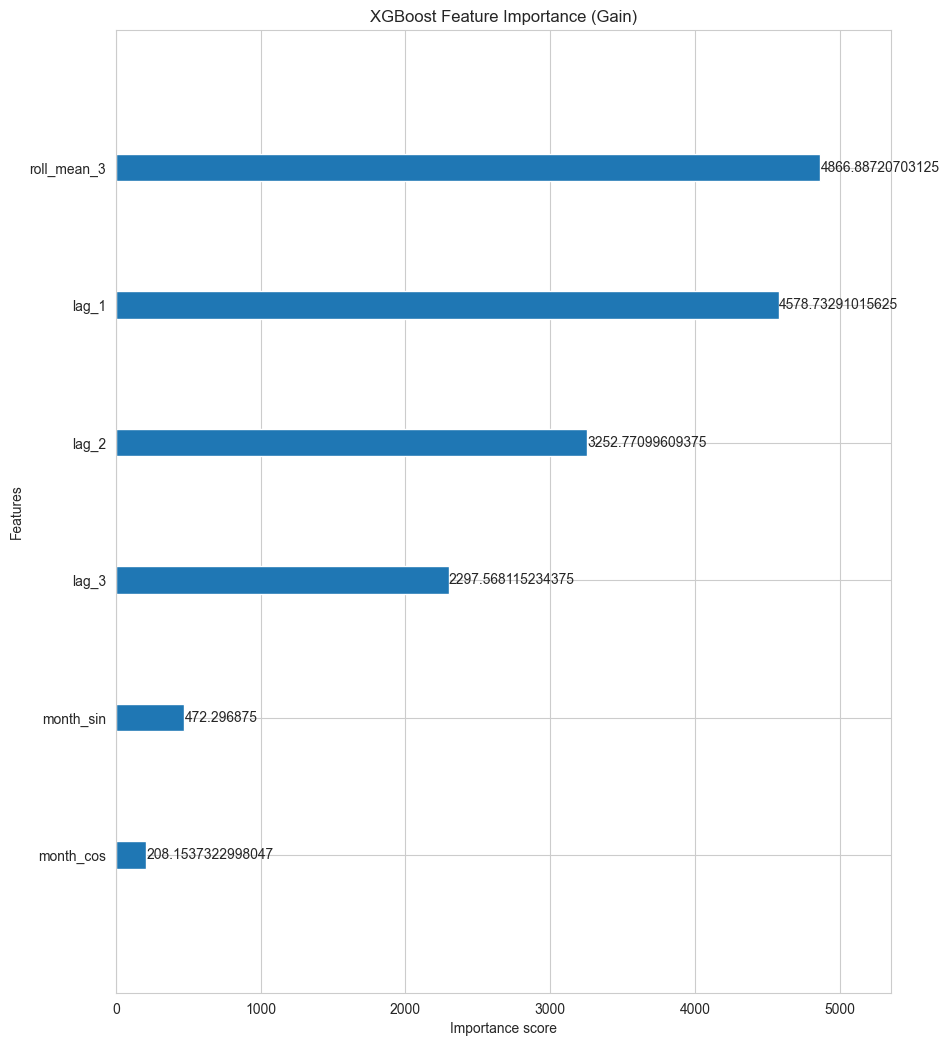


▶ Final tuning with pruned features:
Fitting 5 folds for each of 4 candidates, totalling 20 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.6960

HORIZON 3

▶ Initial CV with all features:

▶ Tuning hyperparameters (all features):
Fitting 5 folds for each of 2 candidates, totalling 10 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.7142

▶ Pruning features using method: threshold
Pruned 2 features below gain threshold 0.1
Selected 4 features


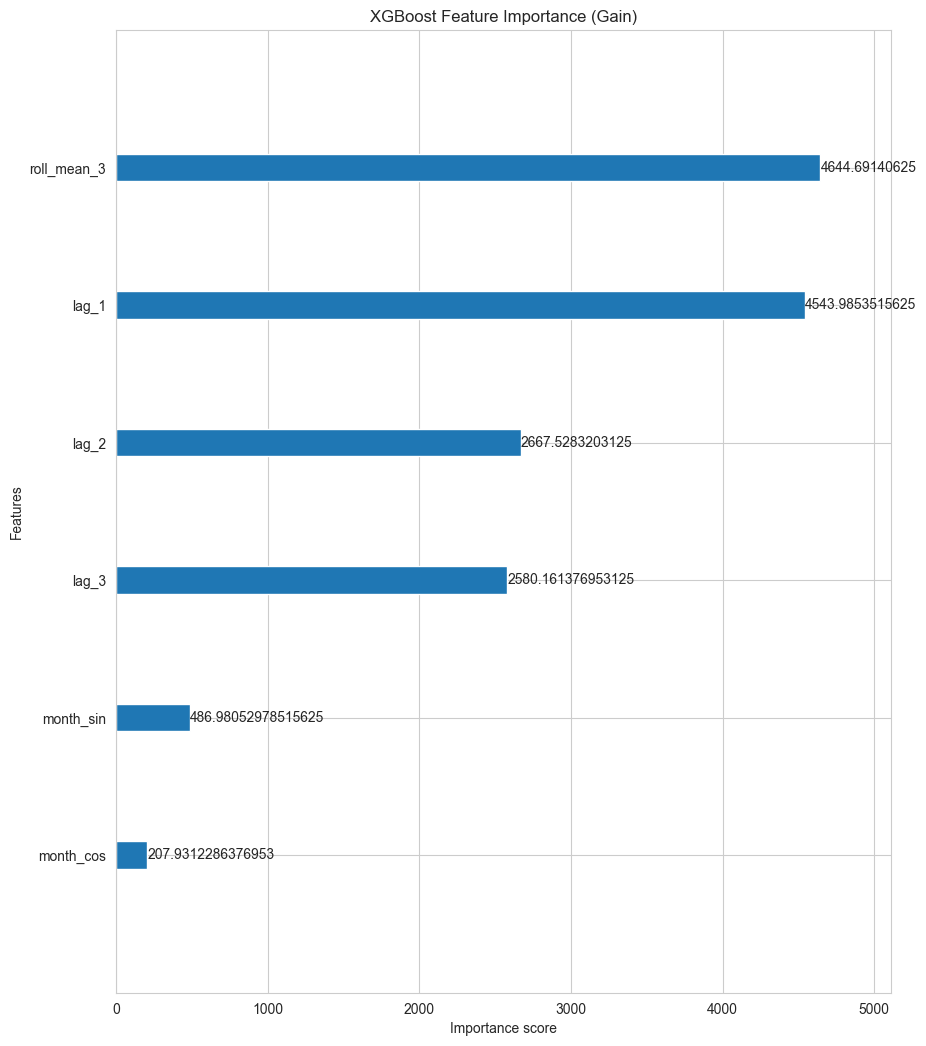


▶ Final tuning with pruned features:
Fitting 5 folds for each of 4 candidates, totalling 20 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.7410

HORIZON 4

▶ Initial CV with all features:

▶ Tuning hyperparameters (all features):
Fitting 5 folds for each of 2 candidates, totalling 10 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.7381

▶ Pruning features using method: threshold
Pruned 2 features below gain threshold 0.1
Selected 4 features


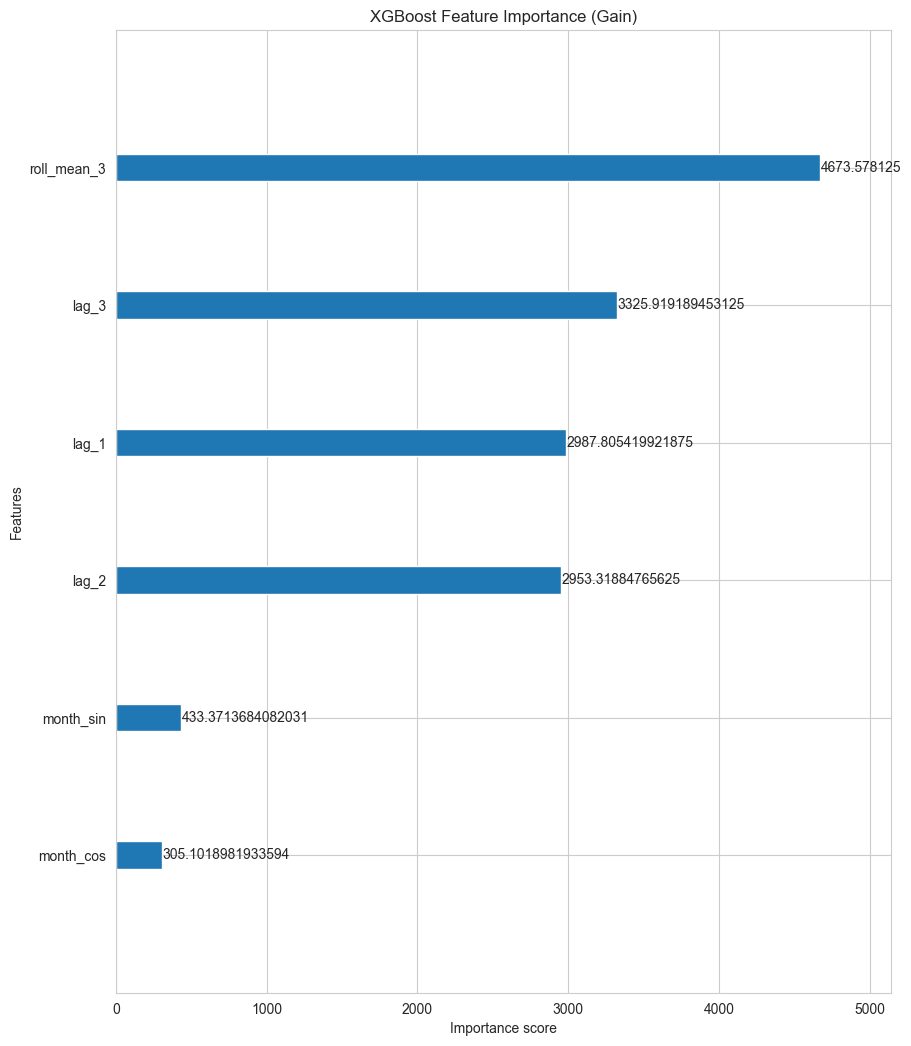


▶ Final tuning with pruned features:
Fitting 5 folds for each of 4 candidates, totalling 20 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.7637

HORIZON 0

▶ Initial CV with all features:

▶ Tuning hyperparameters (all features):
Fitting 5 folds for each of 2 candidates, totalling 10 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.5285

▶ Pruning features using method: topk
Pruned 1 features, retained top 5 by gain.
Selected 5 features


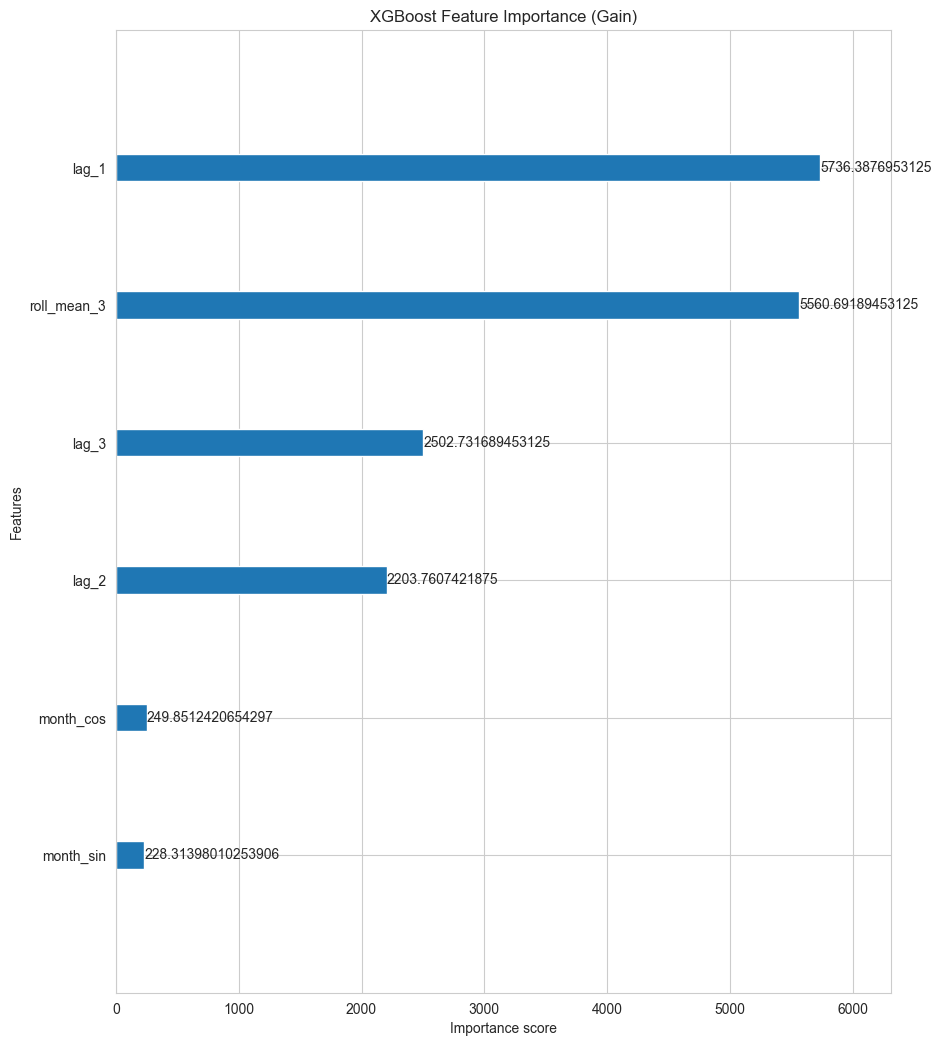


▶ Final tuning with pruned features:
Fitting 5 folds for each of 4 candidates, totalling 20 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.5303

HORIZON 1

▶ Initial CV with all features:

▶ Tuning hyperparameters (all features):
Fitting 5 folds for each of 2 candidates, totalling 10 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.6475

▶ Pruning features using method: topk
Pruned 1 features, retained top 5 by gain.
Selected 5 features


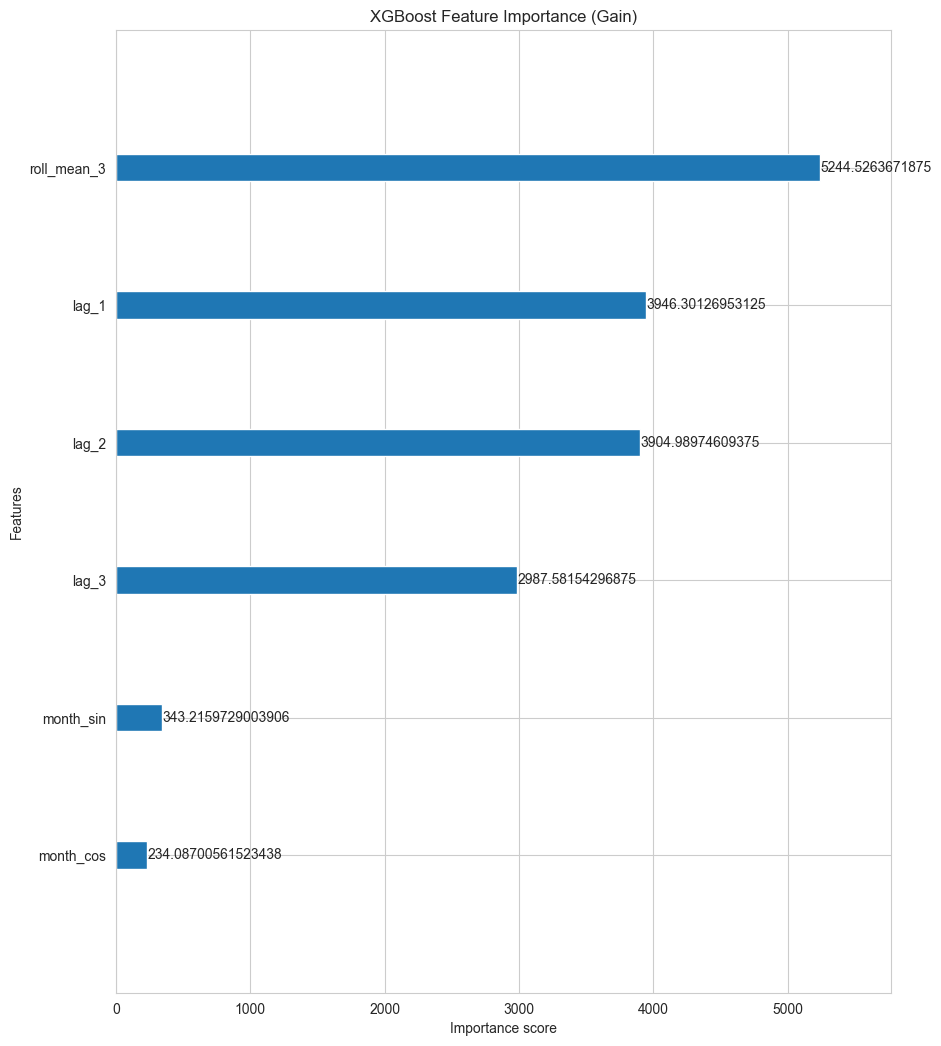


▶ Final tuning with pruned features:
Fitting 5 folds for each of 4 candidates, totalling 20 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.6458

HORIZON 2

▶ Initial CV with all features:

▶ Tuning hyperparameters (all features):
Fitting 5 folds for each of 2 candidates, totalling 10 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.6698

▶ Pruning features using method: topk
Pruned 1 features, retained top 5 by gain.
Selected 5 features


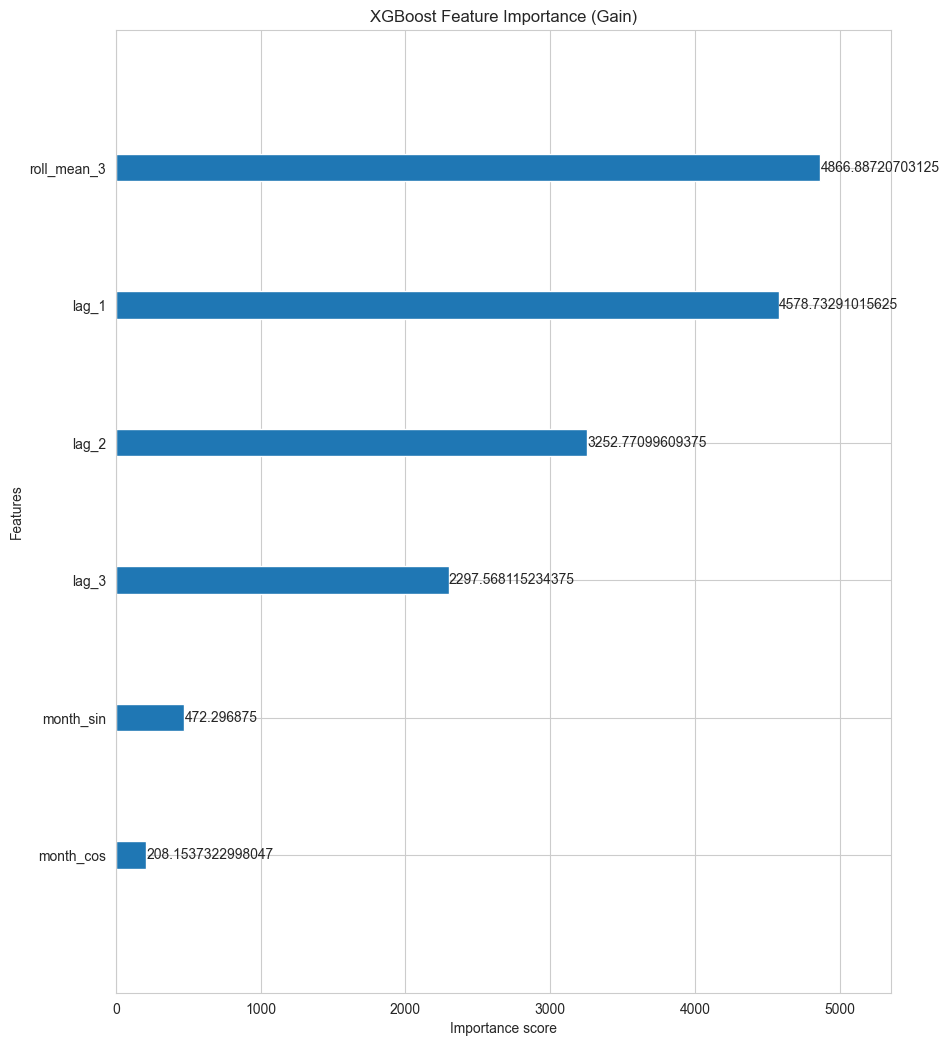


▶ Final tuning with pruned features:
Fitting 5 folds for each of 4 candidates, totalling 20 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.6685

HORIZON 3

▶ Initial CV with all features:

▶ Tuning hyperparameters (all features):
Fitting 5 folds for each of 2 candidates, totalling 10 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.7142

▶ Pruning features using method: topk
Pruned 1 features, retained top 5 by gain.
Selected 5 features


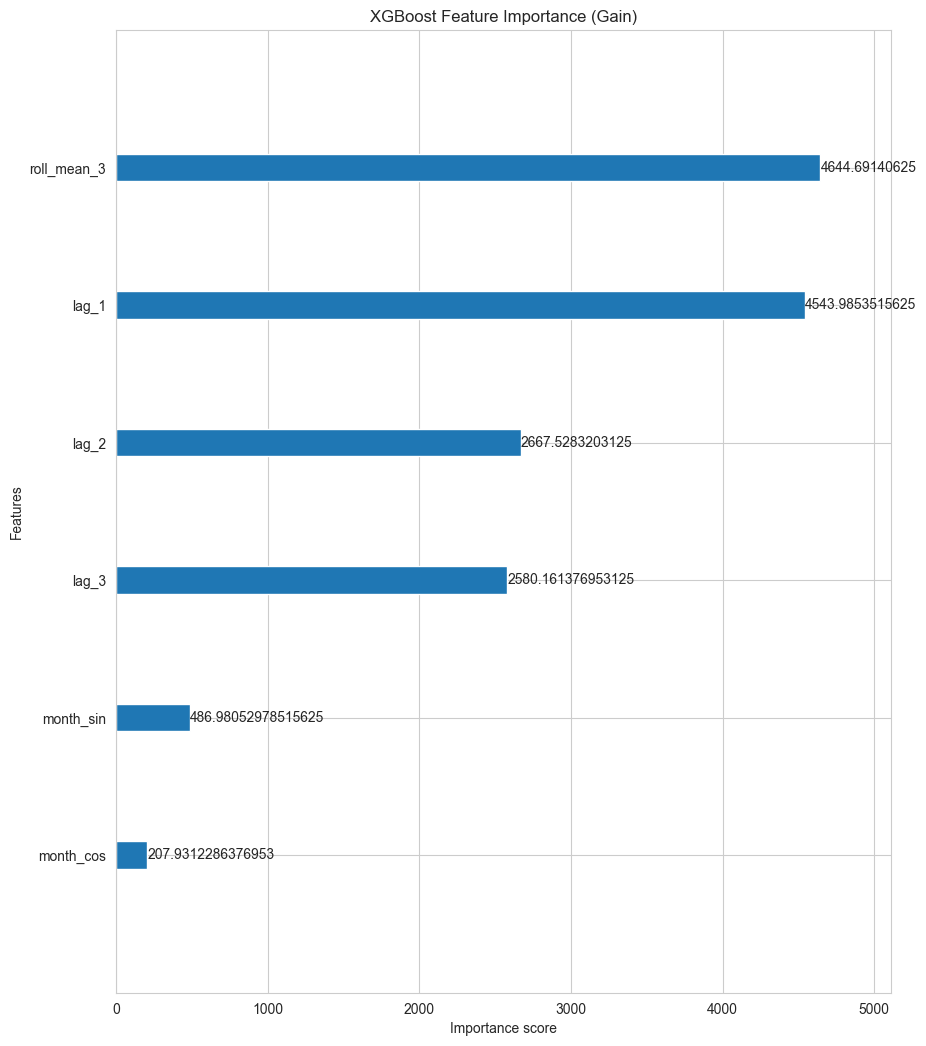


▶ Final tuning with pruned features:
Fitting 5 folds for each of 4 candidates, totalling 20 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.7108

HORIZON 4

▶ Initial CV with all features:

▶ Tuning hyperparameters (all features):
Fitting 5 folds for each of 2 candidates, totalling 10 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.7381

▶ Pruning features using method: topk
Pruned 1 features, retained top 5 by gain.
Selected 5 features


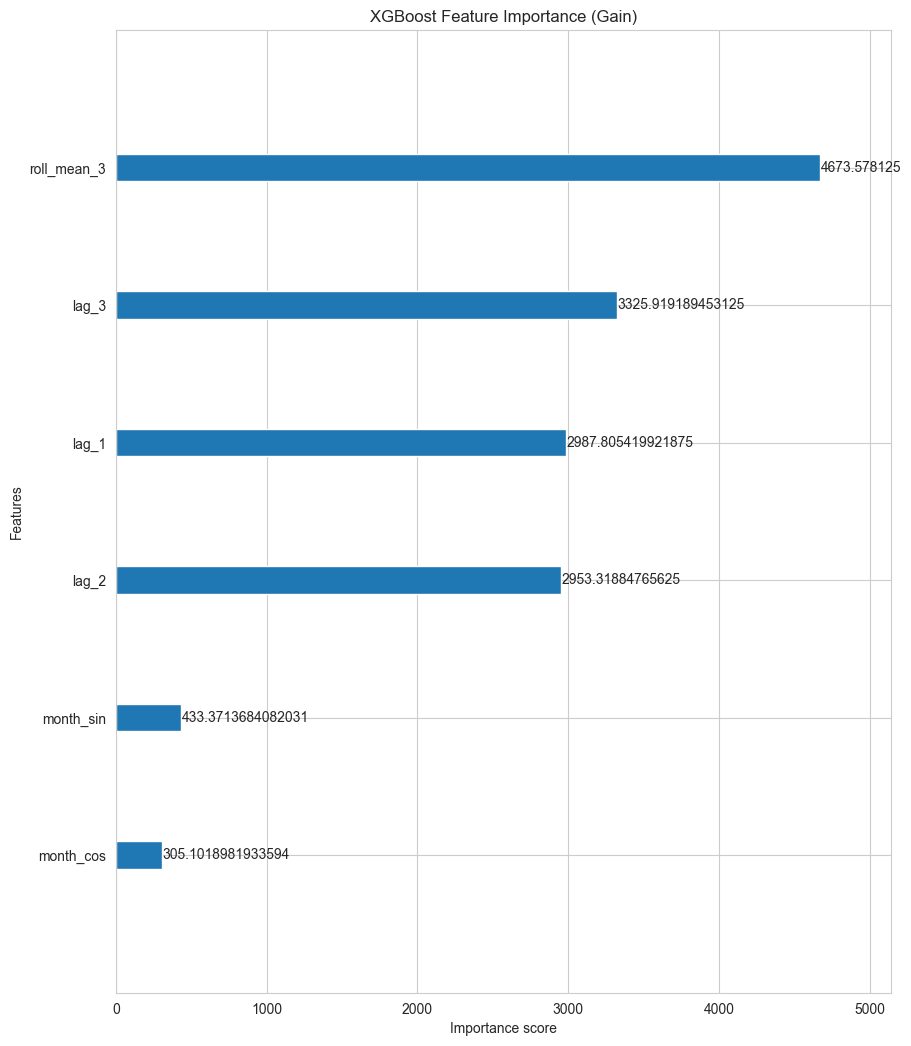


▶ Final tuning with pruned features:
Fitting 5 folds for each of 4 candidates, totalling 20 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.7384

HORIZON 0

▶ Initial CV with all features:

▶ Tuning hyperparameters (all features):
Fitting 5 folds for each of 2 candidates, totalling 10 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mean RMSE: 3.3327

HORIZON 1

▶ Initial CV with all features:

▶ Tuning hyperparameters (all features):
Fitting 5 folds for each of 2 candidates, totalling 10 fits

 Best model parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma':

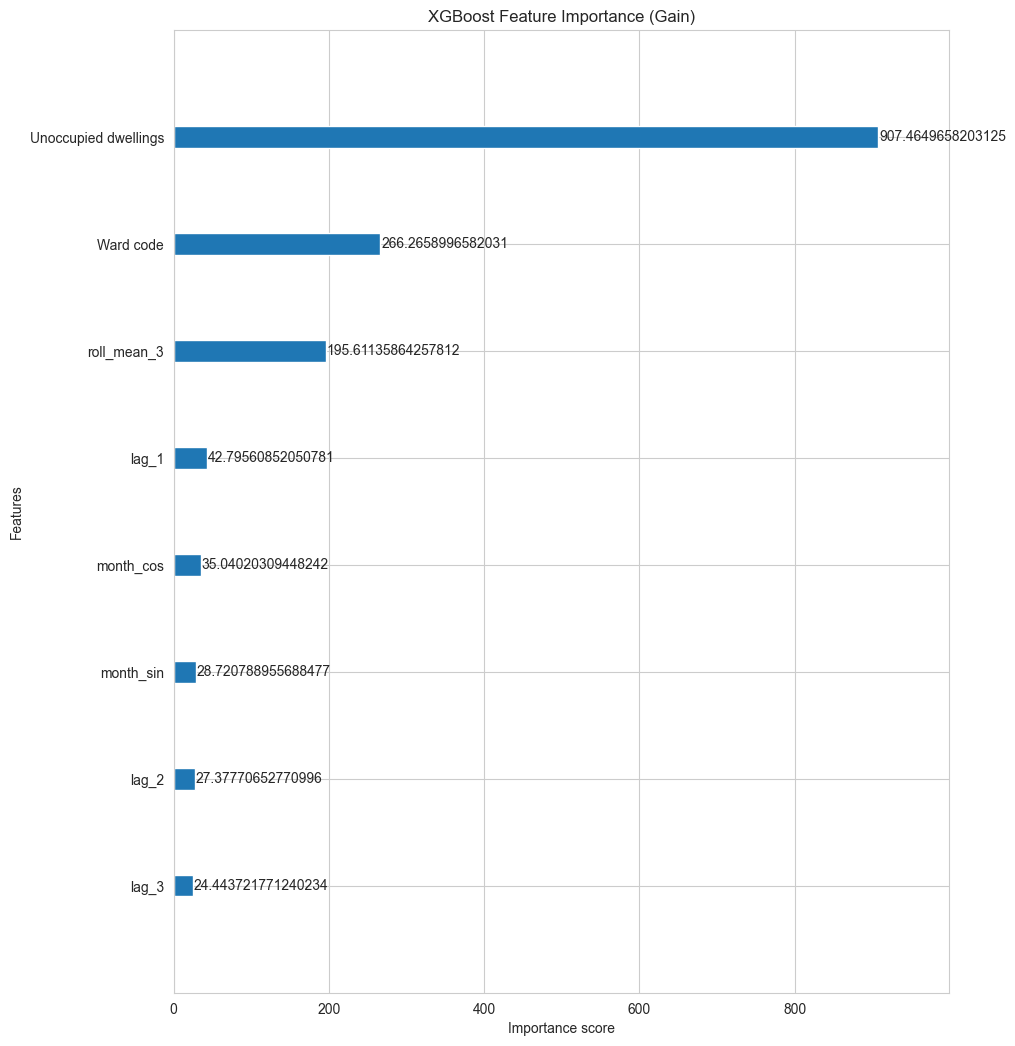


HORIZON 1

▶ Initial CV with all features:

▶ Skipping tuning — evaluating with time series CV:
⚠️ Detected search space in param_dist. Using XGBoost defaults instead.

▶ Pruning features using method: threshold
Pruned 29 features below gain threshold 0.1
Selected 2 features


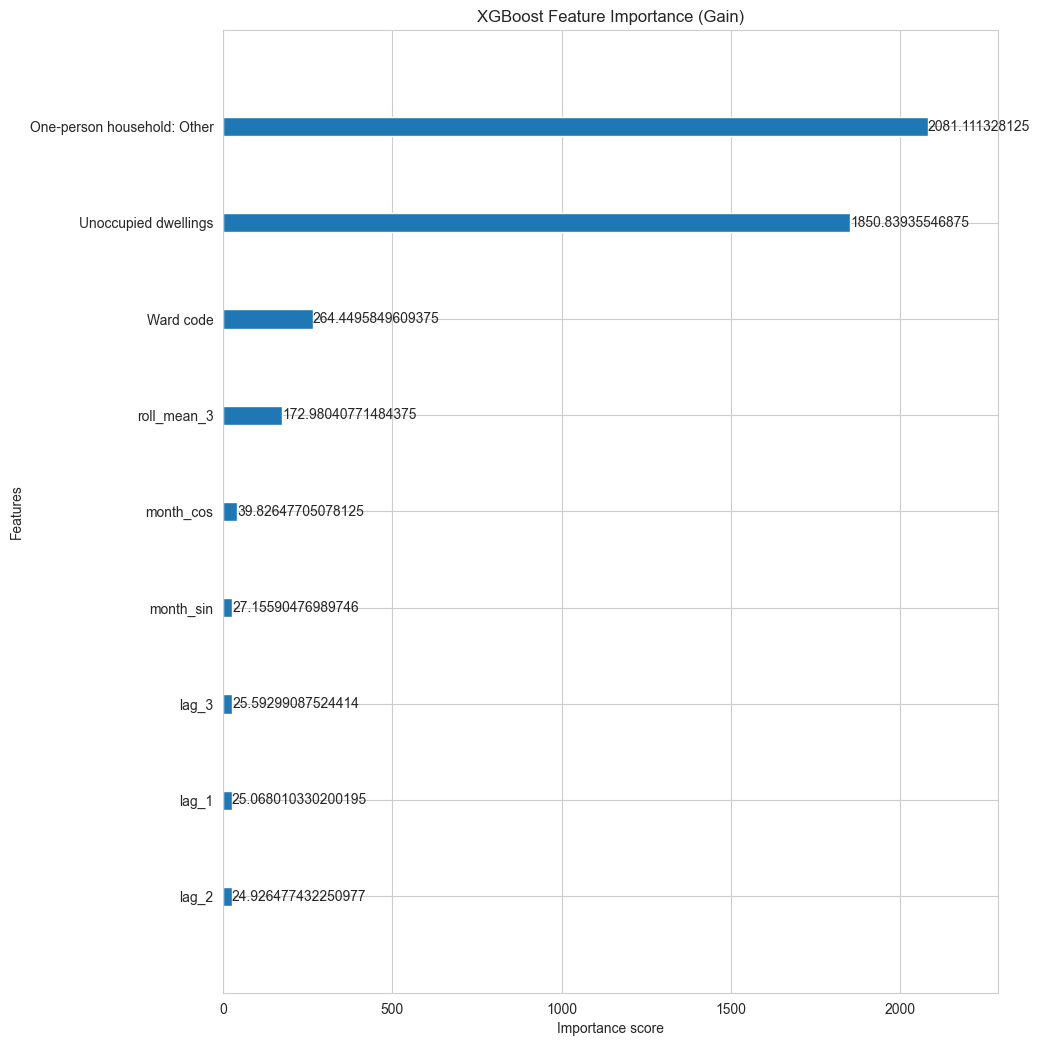


HORIZON 2

▶ Initial CV with all features:

▶ Skipping tuning — evaluating with time series CV:
⚠️ Detected search space in param_dist. Using XGBoost defaults instead.

▶ Pruning features using method: threshold
Pruned 29 features below gain threshold 0.1
Selected 2 features


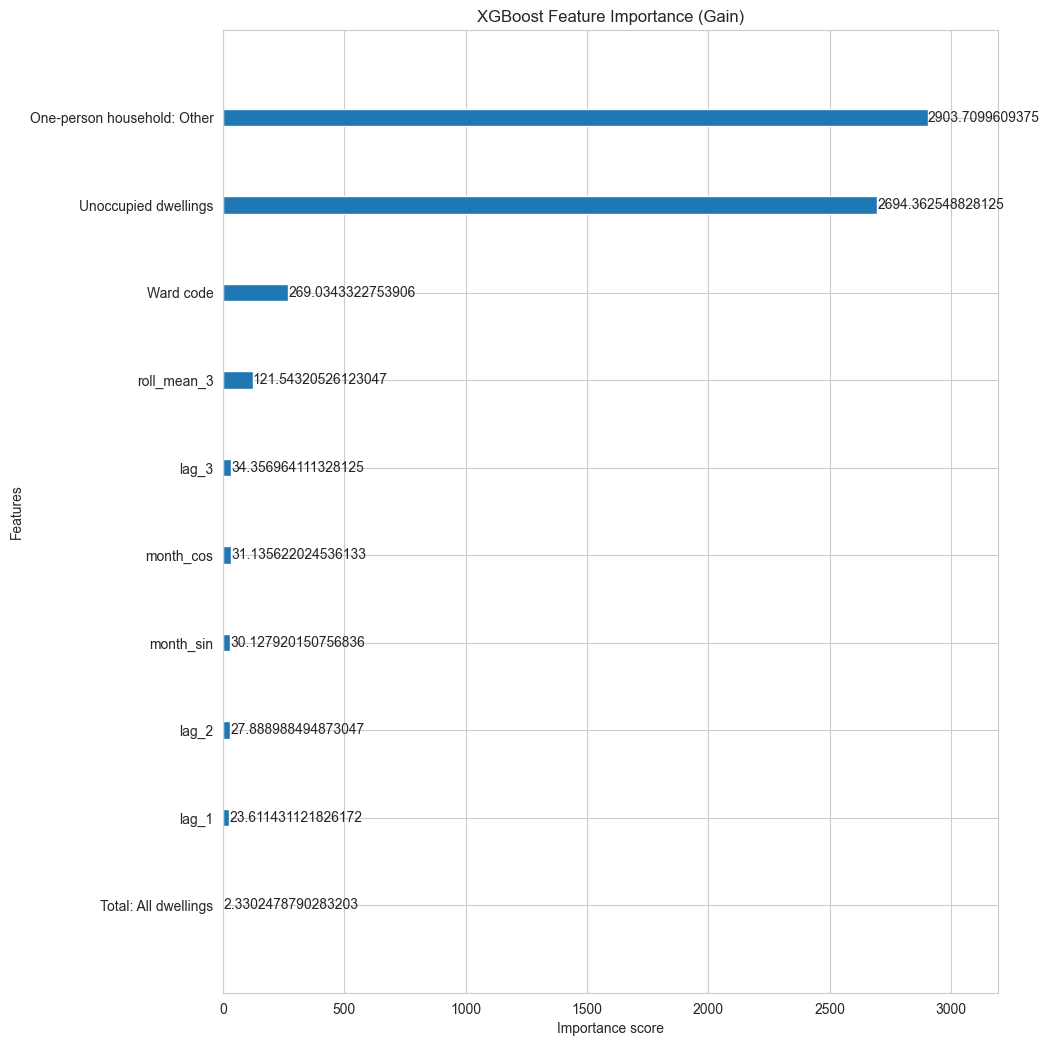


HORIZON 3

▶ Initial CV with all features:

▶ Skipping tuning — evaluating with time series CV:
⚠️ Detected search space in param_dist. Using XGBoost defaults instead.

▶ Pruning features using method: threshold
Pruned 29 features below gain threshold 0.1
Selected 2 features


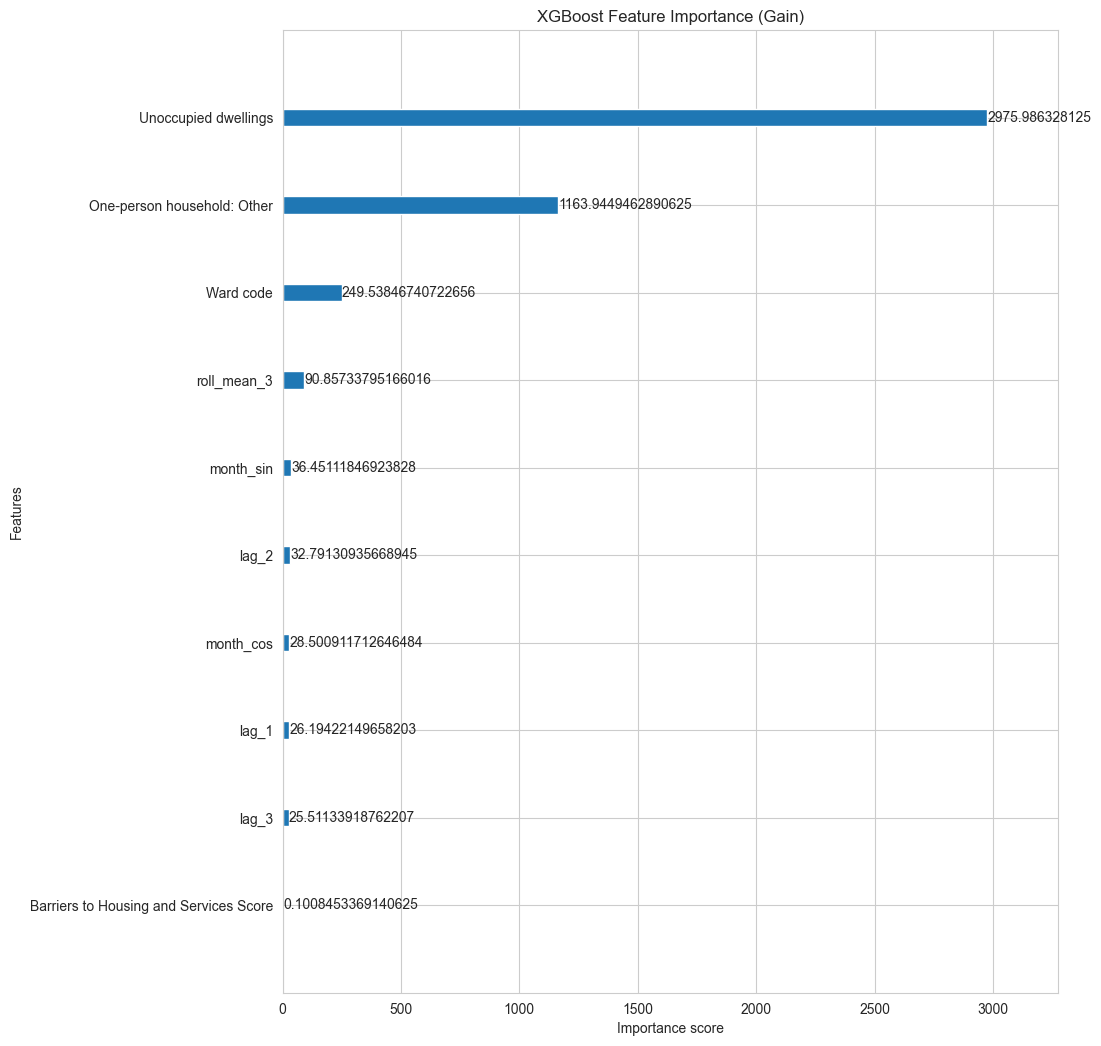


HORIZON 4

▶ Initial CV with all features:

▶ Skipping tuning — evaluating with time series CV:
⚠️ Detected search space in param_dist. Using XGBoost defaults instead.

▶ Pruning features using method: threshold
Pruned 29 features below gain threshold 0.1
Selected 2 features


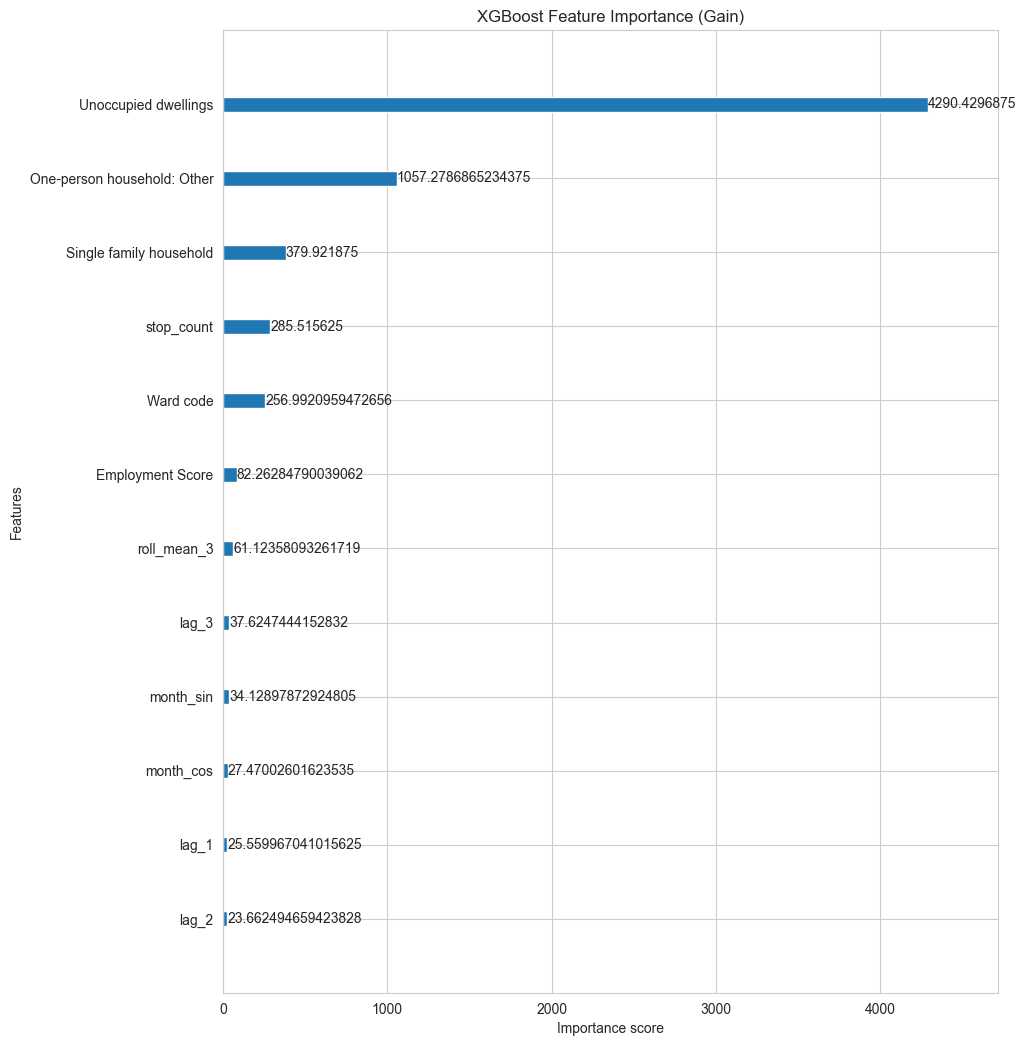


HORIZON 0

▶ Initial CV with all features:

▶ Skipping tuning — evaluating with time series CV:
⚠️ Detected search space in param_dist. Using XGBoost defaults instead.

▶ Pruning features using method: topk
Pruned 26 features, retained top 5 by gain.
Selected 5 features


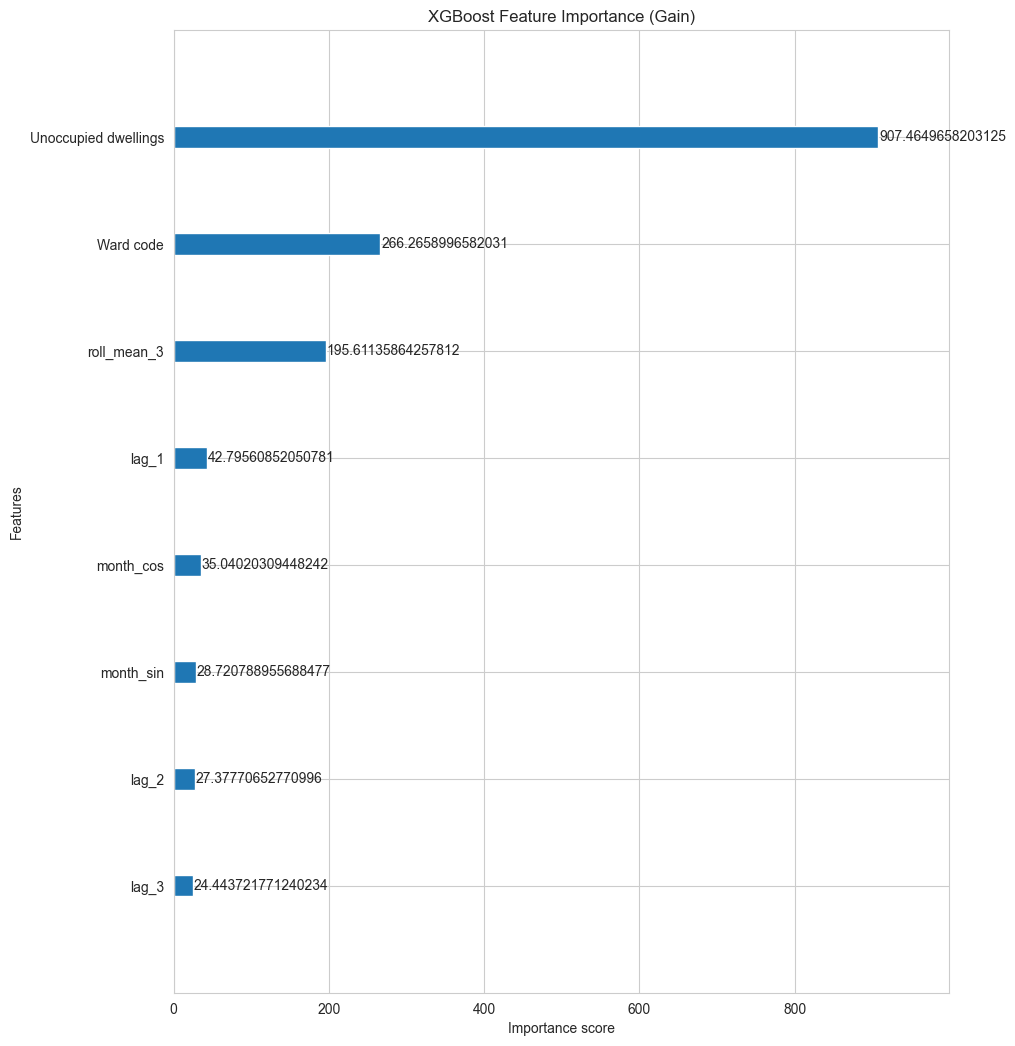


HORIZON 1

▶ Initial CV with all features:

▶ Skipping tuning — evaluating with time series CV:
⚠️ Detected search space in param_dist. Using XGBoost defaults instead.

▶ Pruning features using method: topk
Pruned 26 features, retained top 5 by gain.
Selected 5 features


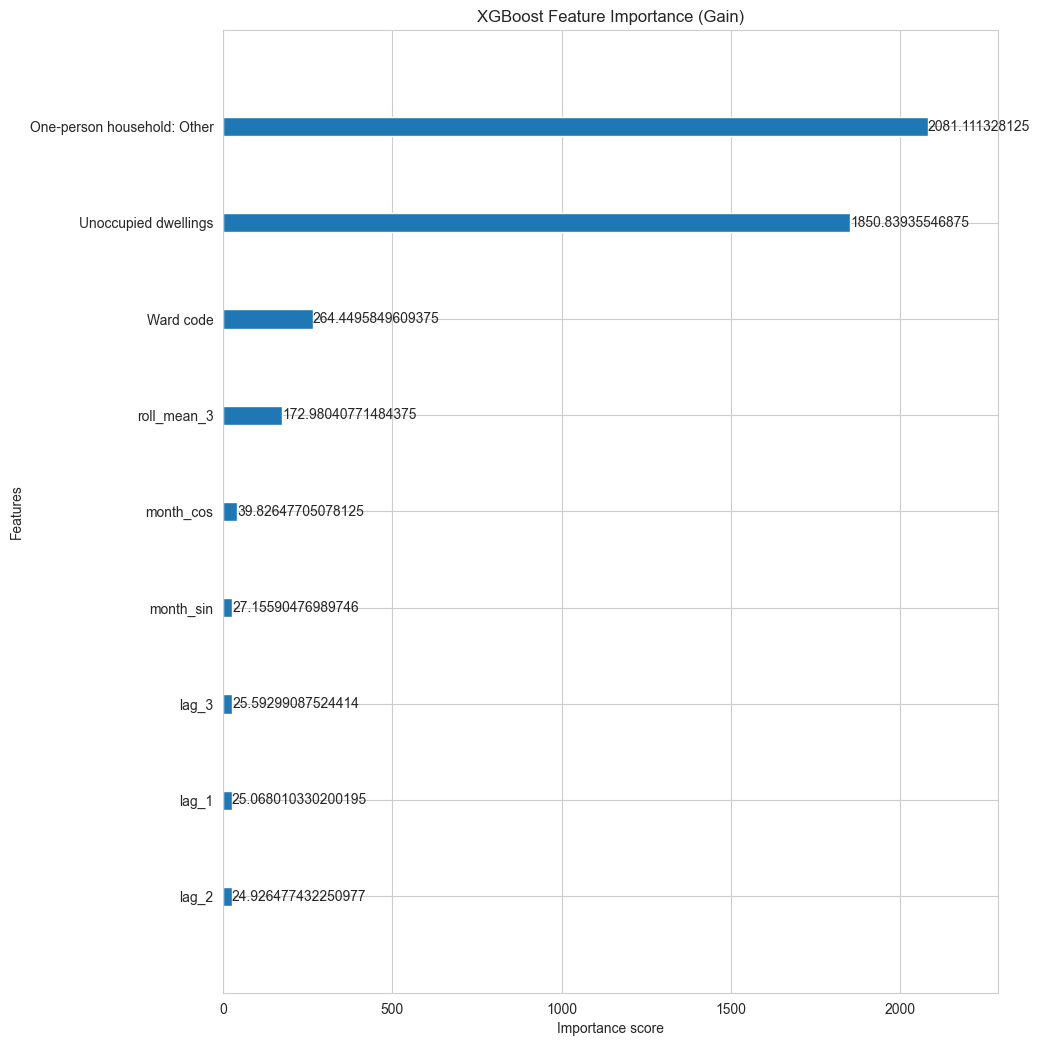


HORIZON 2

▶ Initial CV with all features:

▶ Skipping tuning — evaluating with time series CV:
⚠️ Detected search space in param_dist. Using XGBoost defaults instead.

▶ Pruning features using method: topk
Pruned 26 features, retained top 5 by gain.
Selected 5 features


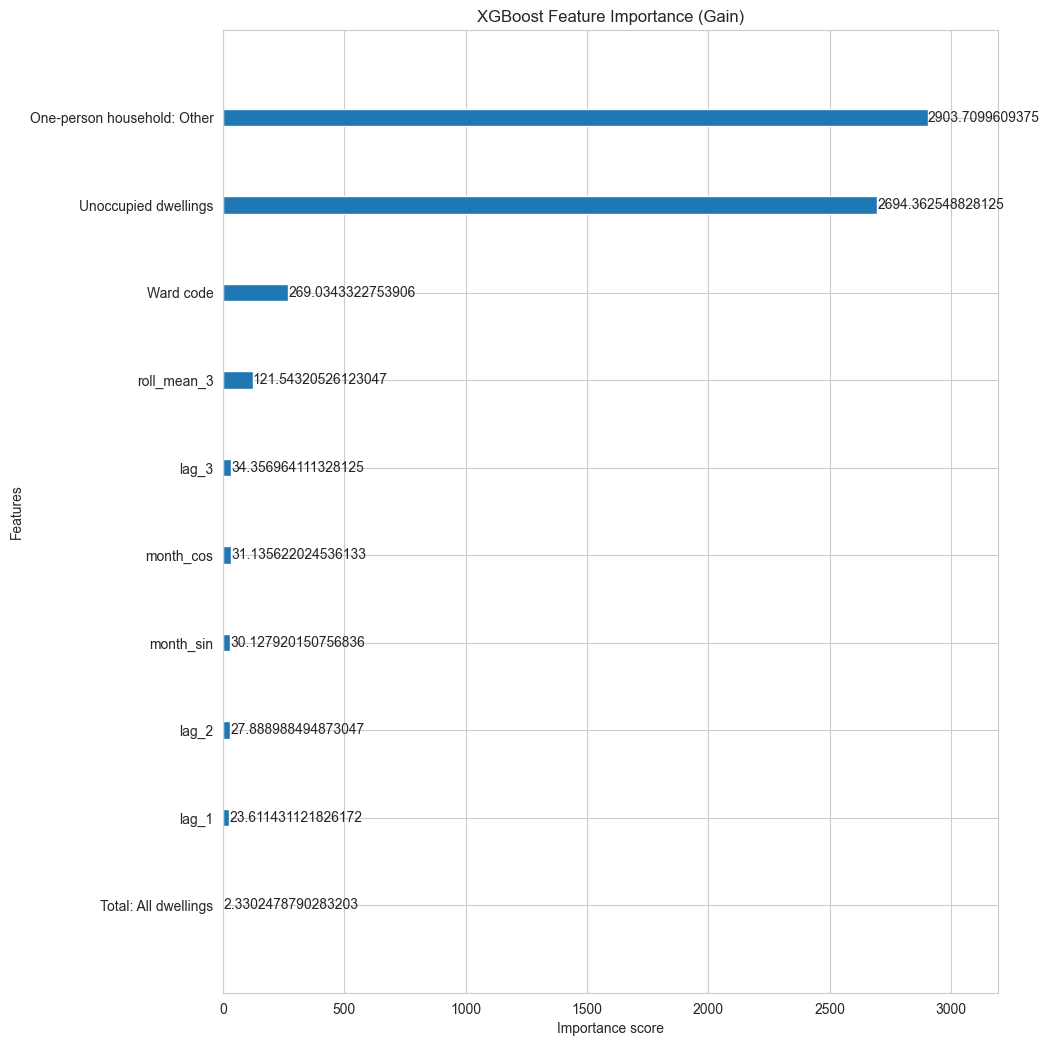


HORIZON 3

▶ Initial CV with all features:

▶ Skipping tuning — evaluating with time series CV:
⚠️ Detected search space in param_dist. Using XGBoost defaults instead.

▶ Pruning features using method: topk
Pruned 26 features, retained top 5 by gain.
Selected 5 features


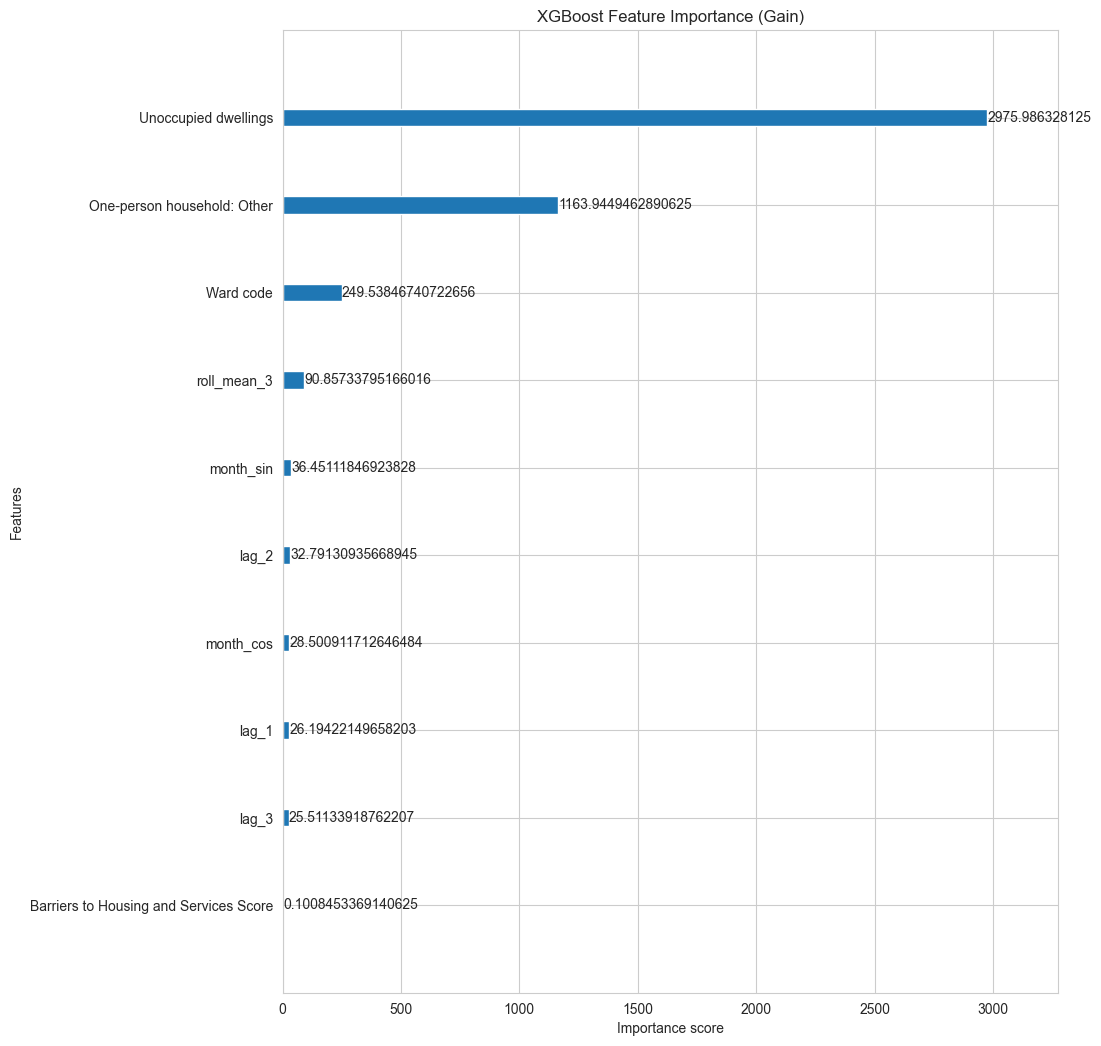


HORIZON 4

▶ Initial CV with all features:

▶ Skipping tuning — evaluating with time series CV:
⚠️ Detected search space in param_dist. Using XGBoost defaults instead.

▶ Pruning features using method: topk
Pruned 26 features, retained top 5 by gain.
Selected 5 features


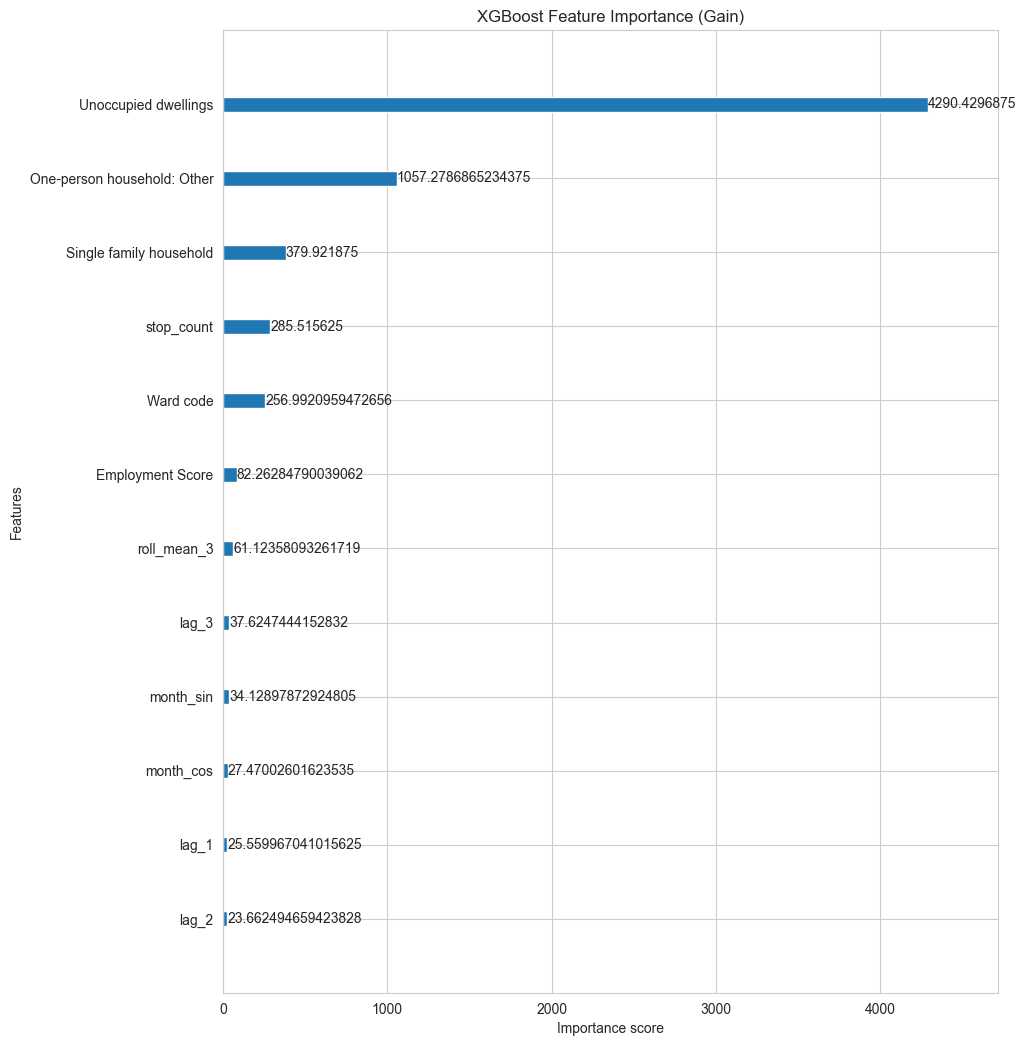


HORIZON 0

▶ Initial CV with all features:

▶ Skipping tuning — evaluating with time series CV:
⚠️ Detected search space in param_dist. Using XGBoost defaults instead.

▶ Pruning features using method: threshold
Pruned 5 features below gain threshold 0.1
Selected 1 features


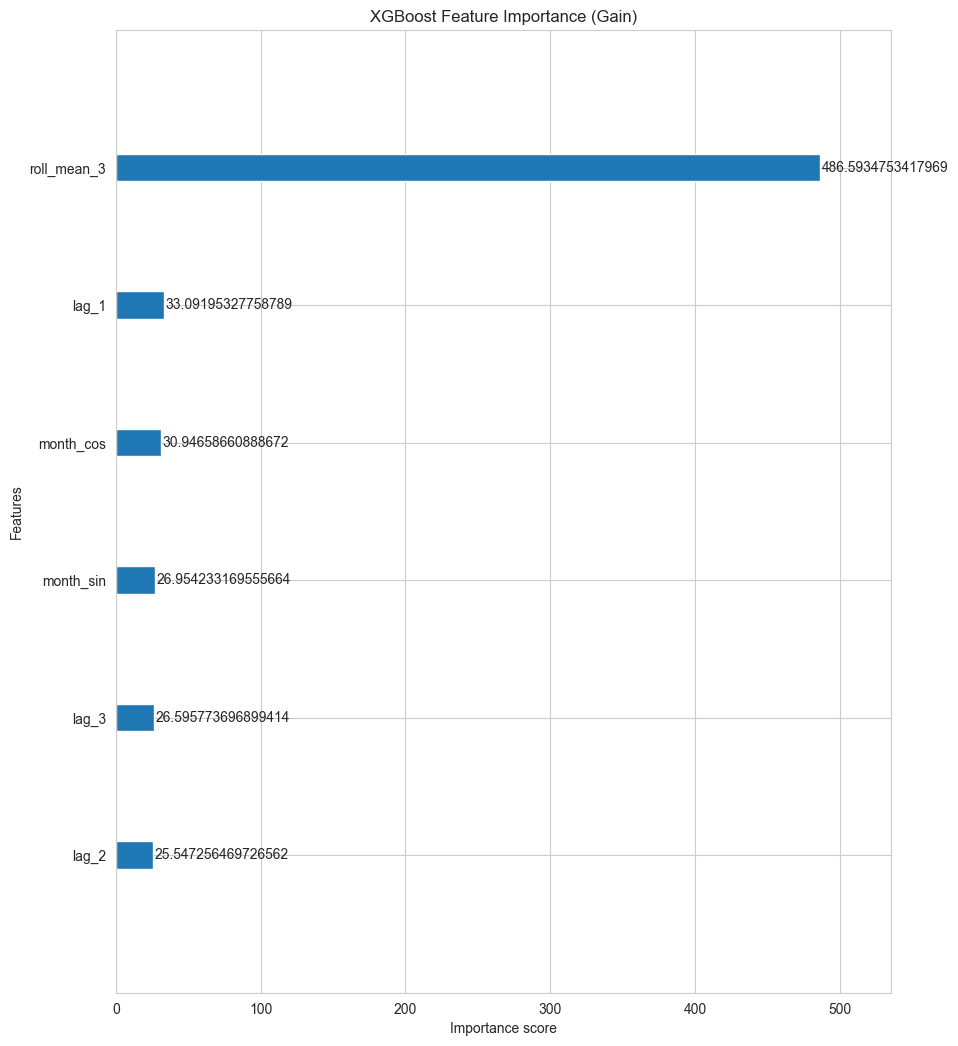


HORIZON 1

▶ Initial CV with all features:

▶ Skipping tuning — evaluating with time series CV:
⚠️ Detected search space in param_dist. Using XGBoost defaults instead.

▶ Pruning features using method: threshold
Pruned 5 features below gain threshold 0.1
Selected 1 features


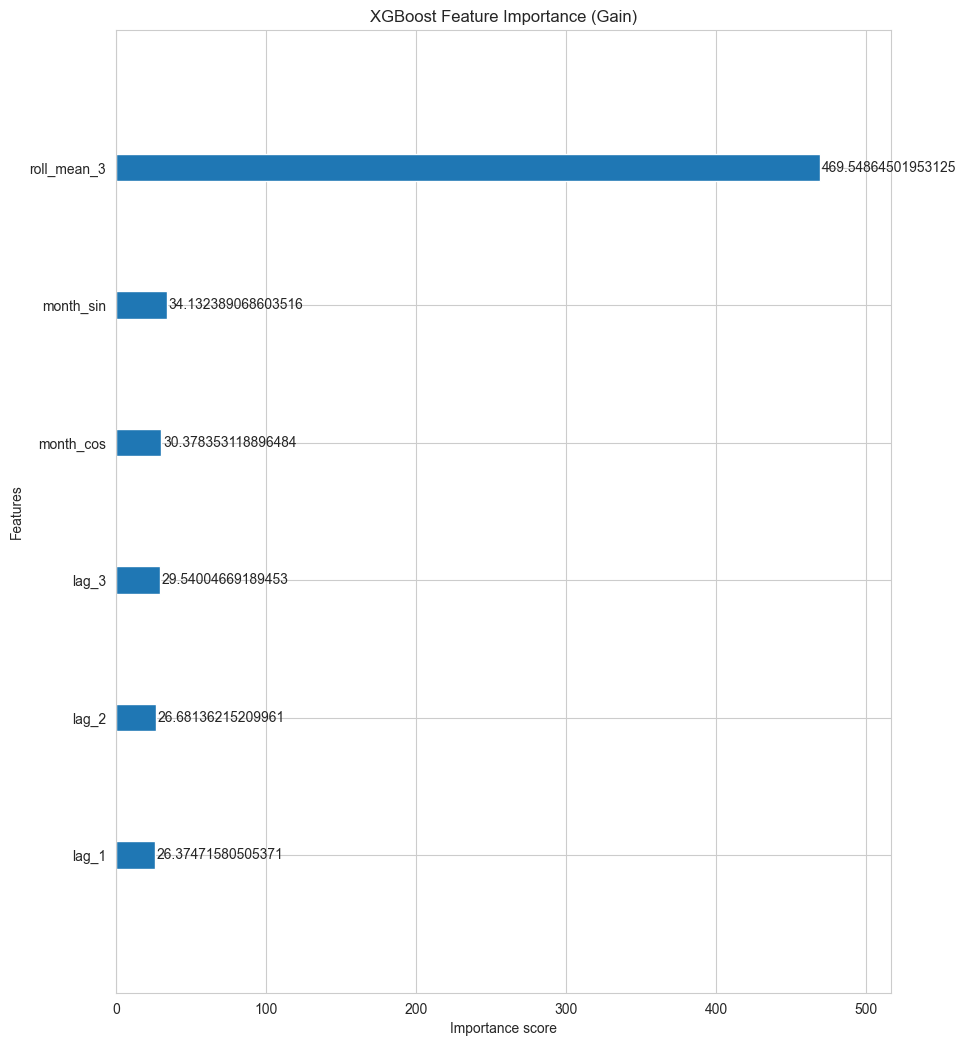


HORIZON 2

▶ Initial CV with all features:

▶ Skipping tuning — evaluating with time series CV:
⚠️ Detected search space in param_dist. Using XGBoost defaults instead.

▶ Pruning features using method: threshold
Pruned 5 features below gain threshold 0.1
Selected 1 features


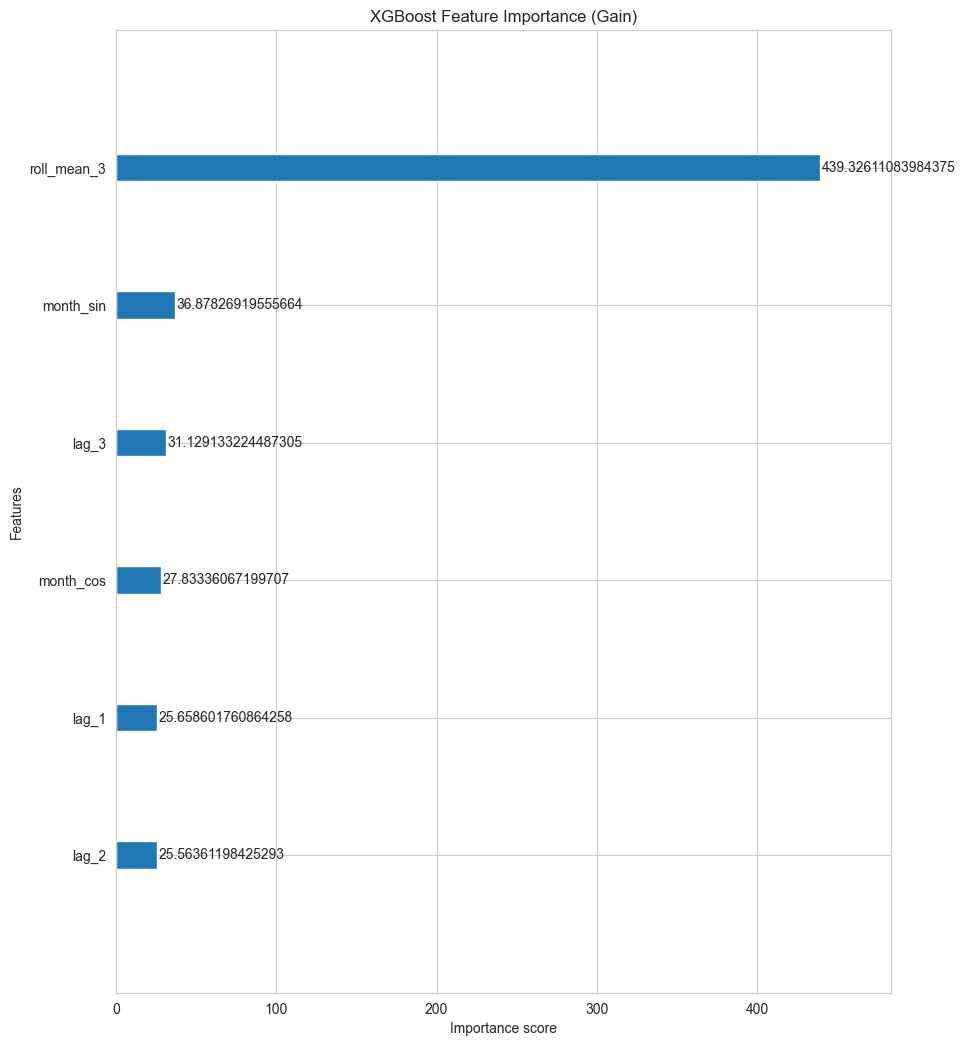


HORIZON 3

▶ Initial CV with all features:

▶ Skipping tuning — evaluating with time series CV:
⚠️ Detected search space in param_dist. Using XGBoost defaults instead.

▶ Pruning features using method: threshold
Pruned 5 features below gain threshold 0.1
Selected 1 features


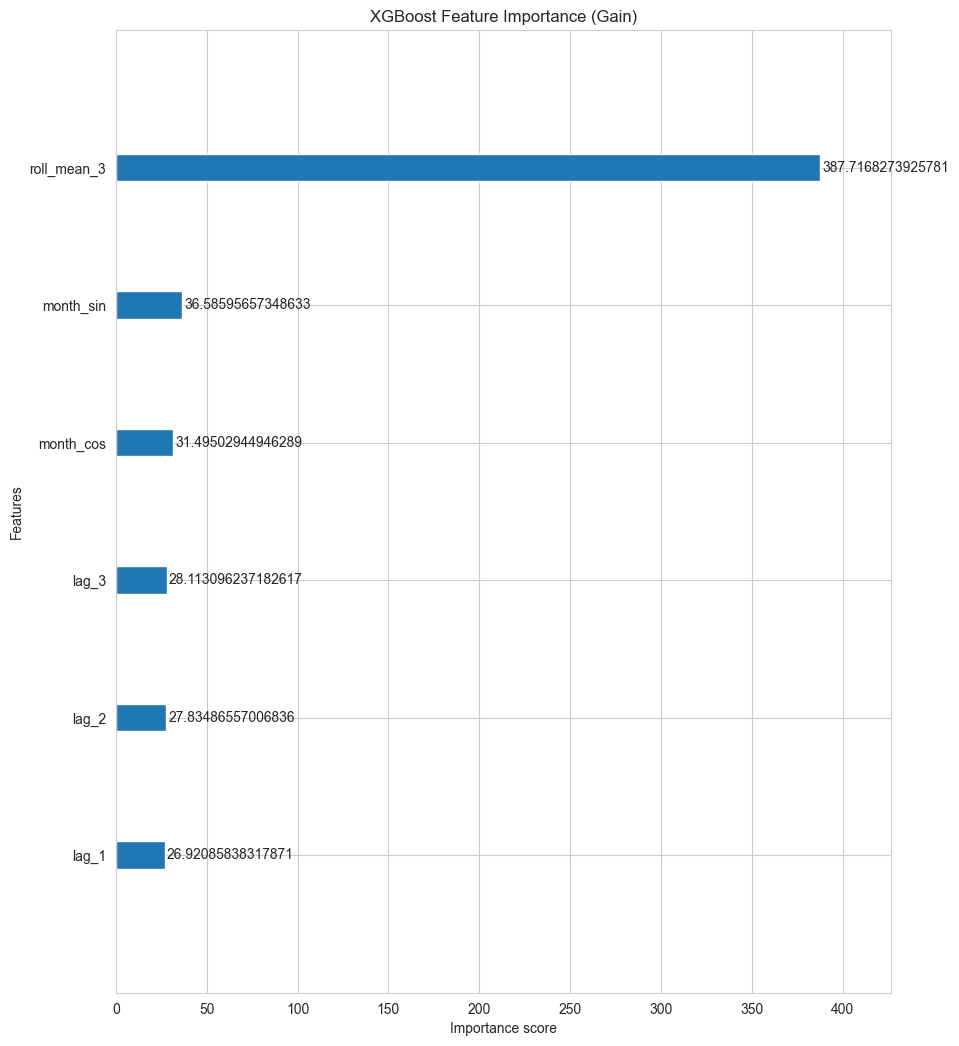


HORIZON 4

▶ Initial CV with all features:

▶ Skipping tuning — evaluating with time series CV:
⚠️ Detected search space in param_dist. Using XGBoost defaults instead.

▶ Pruning features using method: threshold
Pruned 5 features below gain threshold 0.1
Selected 1 features


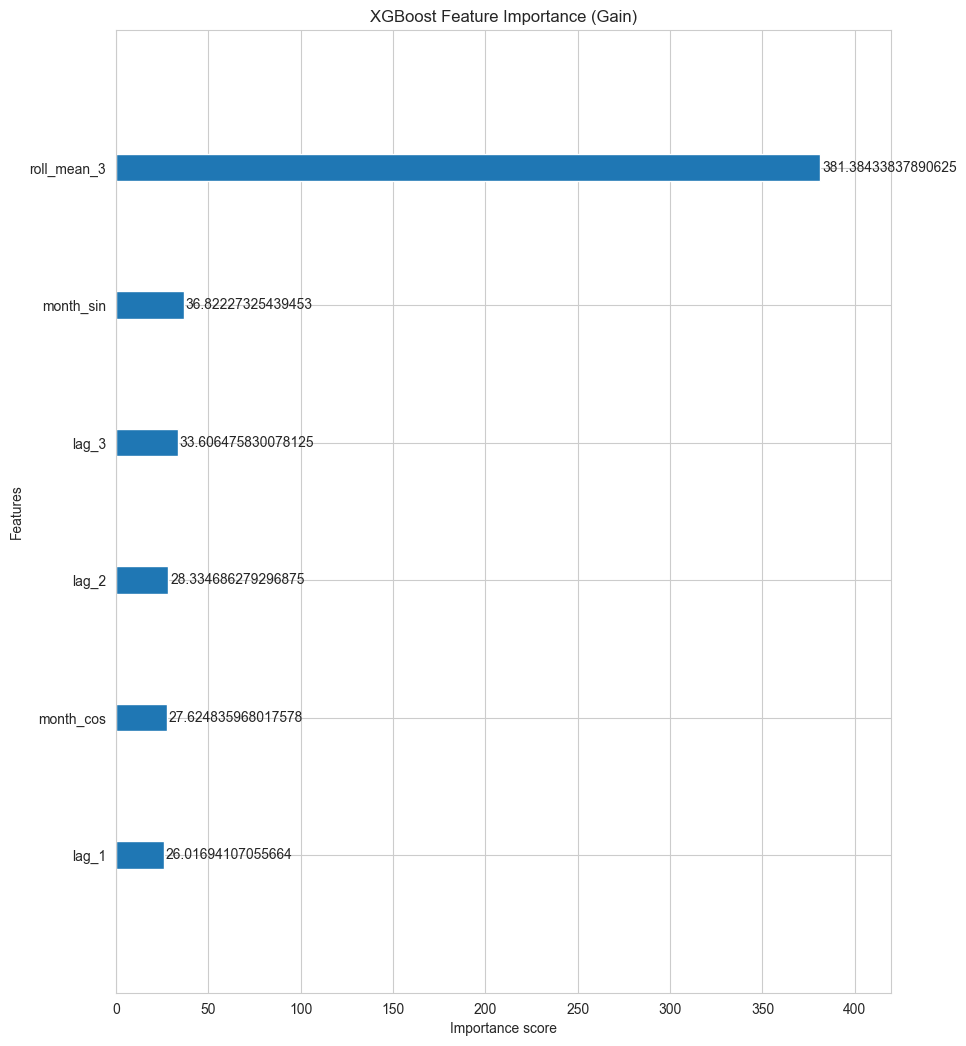


HORIZON 0

▶ Initial CV with all features:

▶ Skipping tuning — evaluating with time series CV:
⚠️ Detected search space in param_dist. Using XGBoost defaults instead.

▶ Pruning features using method: topk
Pruned 1 features, retained top 5 by gain.
Selected 5 features


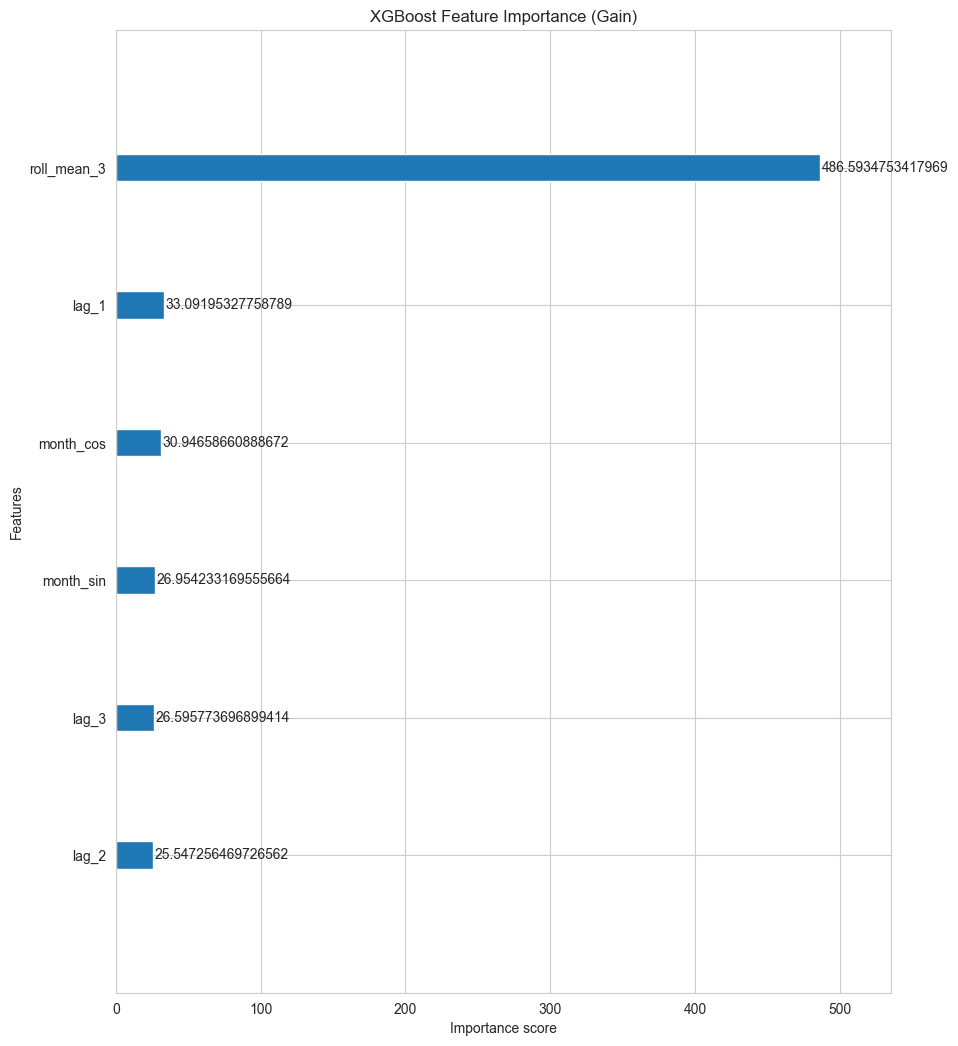


HORIZON 1

▶ Initial CV with all features:

▶ Skipping tuning — evaluating with time series CV:
⚠️ Detected search space in param_dist. Using XGBoost defaults instead.

▶ Pruning features using method: topk
Pruned 1 features, retained top 5 by gain.
Selected 5 features


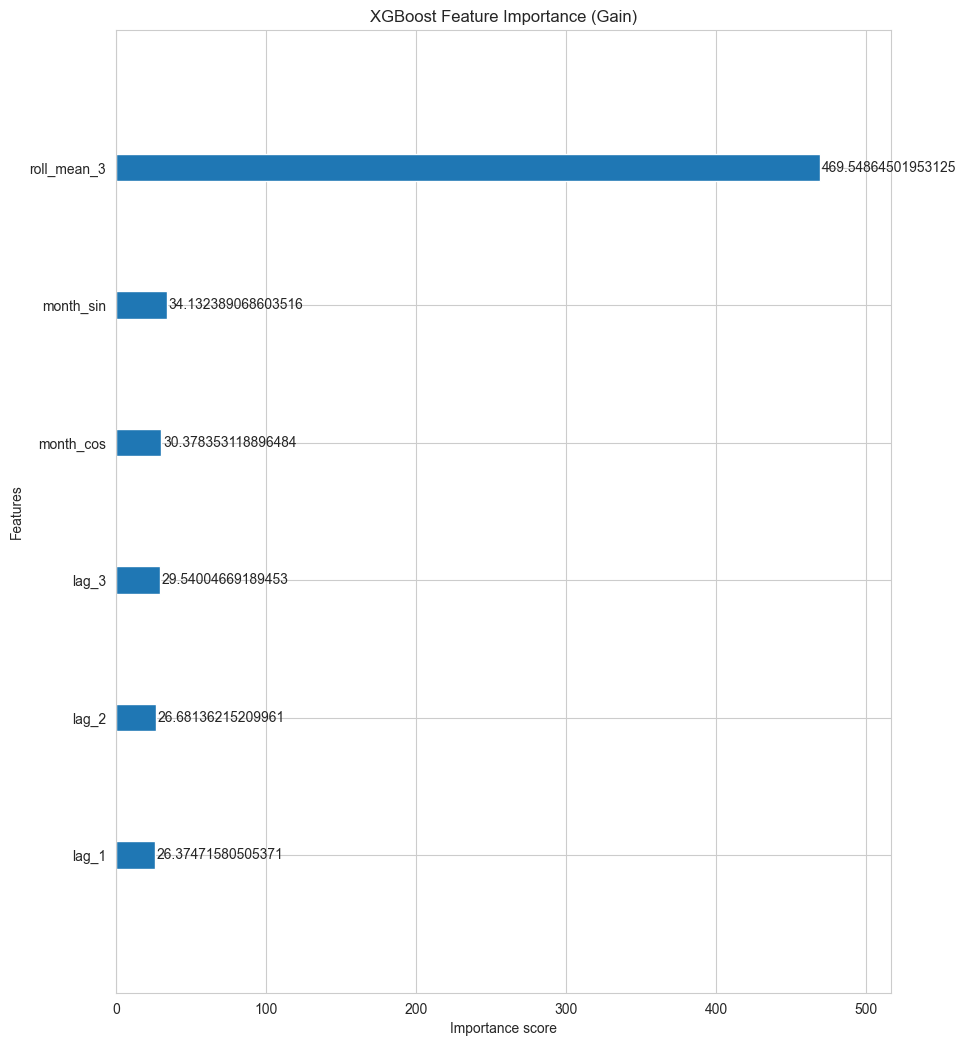


HORIZON 2

▶ Initial CV with all features:

▶ Skipping tuning — evaluating with time series CV:
⚠️ Detected search space in param_dist. Using XGBoost defaults instead.

▶ Pruning features using method: topk
Pruned 1 features, retained top 5 by gain.
Selected 5 features


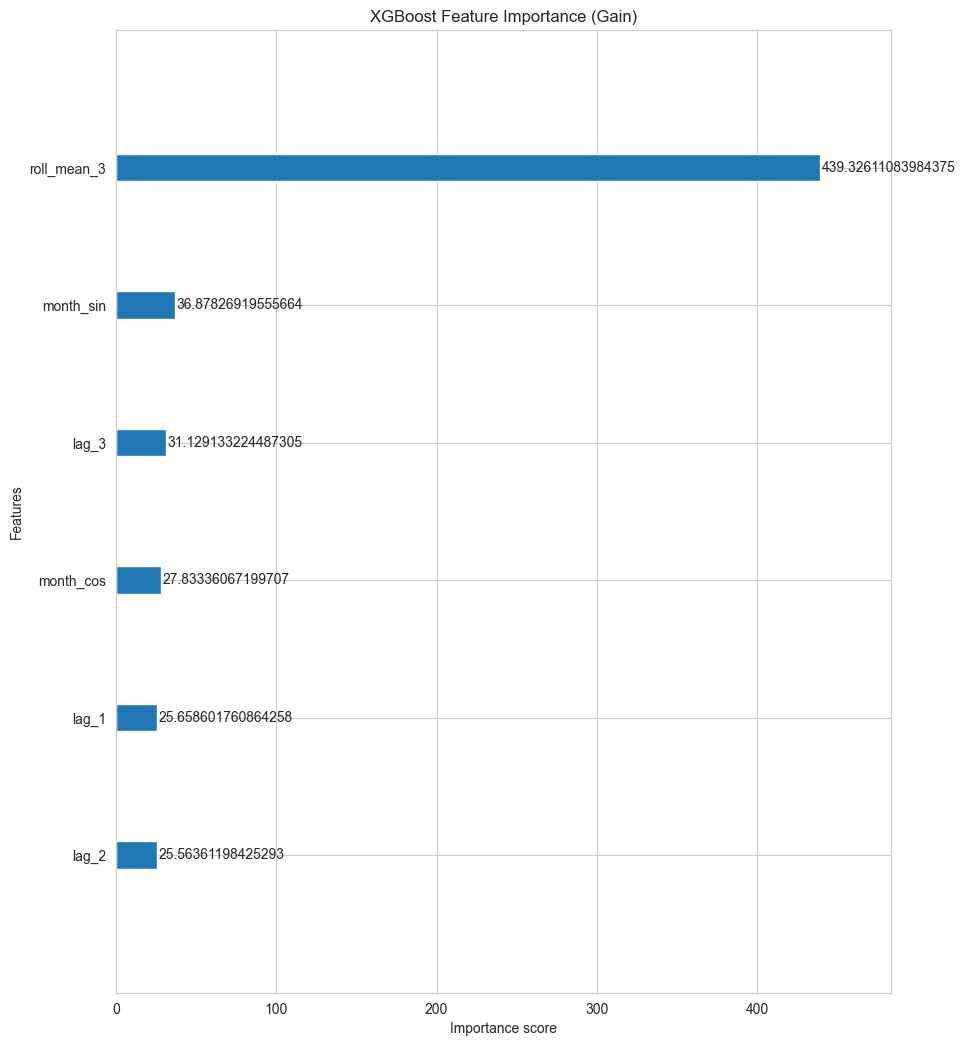


HORIZON 3

▶ Initial CV with all features:

▶ Skipping tuning — evaluating with time series CV:
⚠️ Detected search space in param_dist. Using XGBoost defaults instead.

▶ Pruning features using method: topk
Pruned 1 features, retained top 5 by gain.
Selected 5 features


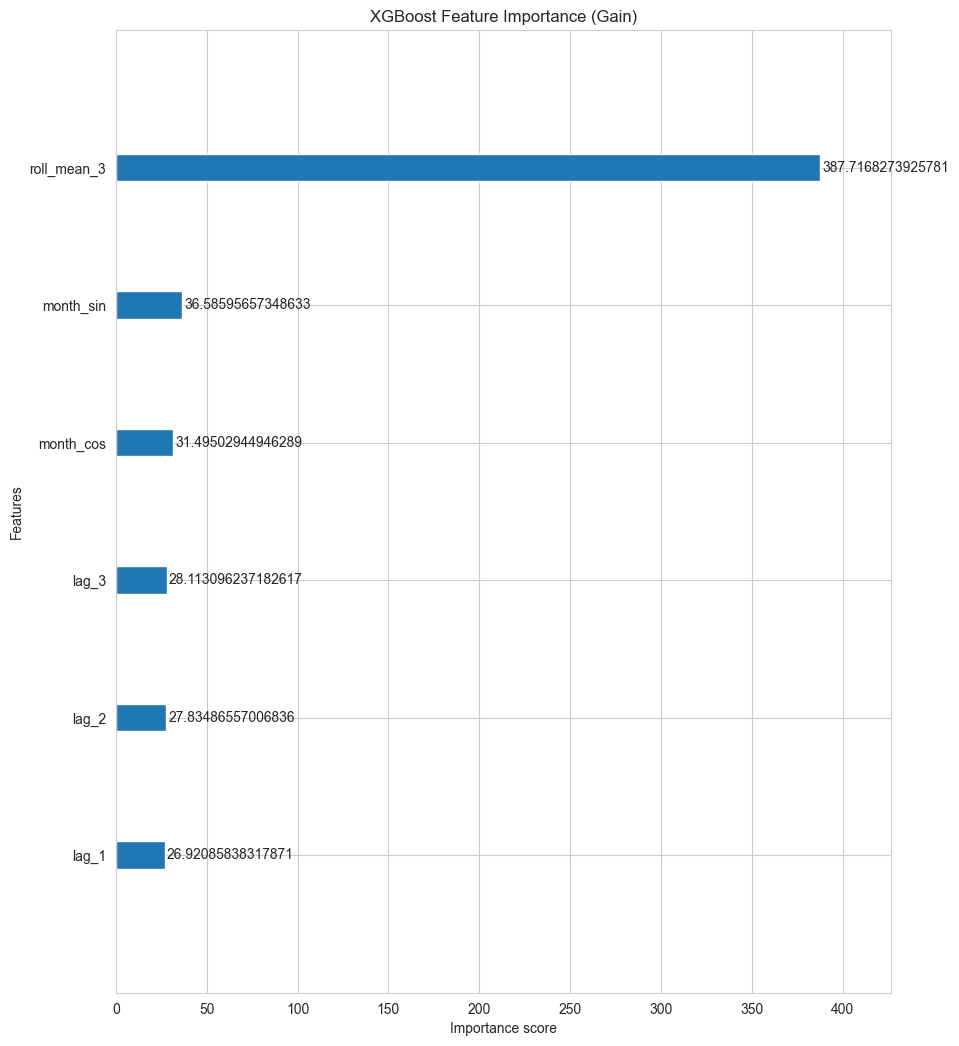


HORIZON 4

▶ Initial CV with all features:

▶ Skipping tuning — evaluating with time series CV:
⚠️ Detected search space in param_dist. Using XGBoost defaults instead.

▶ Pruning features using method: topk
Pruned 1 features, retained top 5 by gain.
Selected 5 features


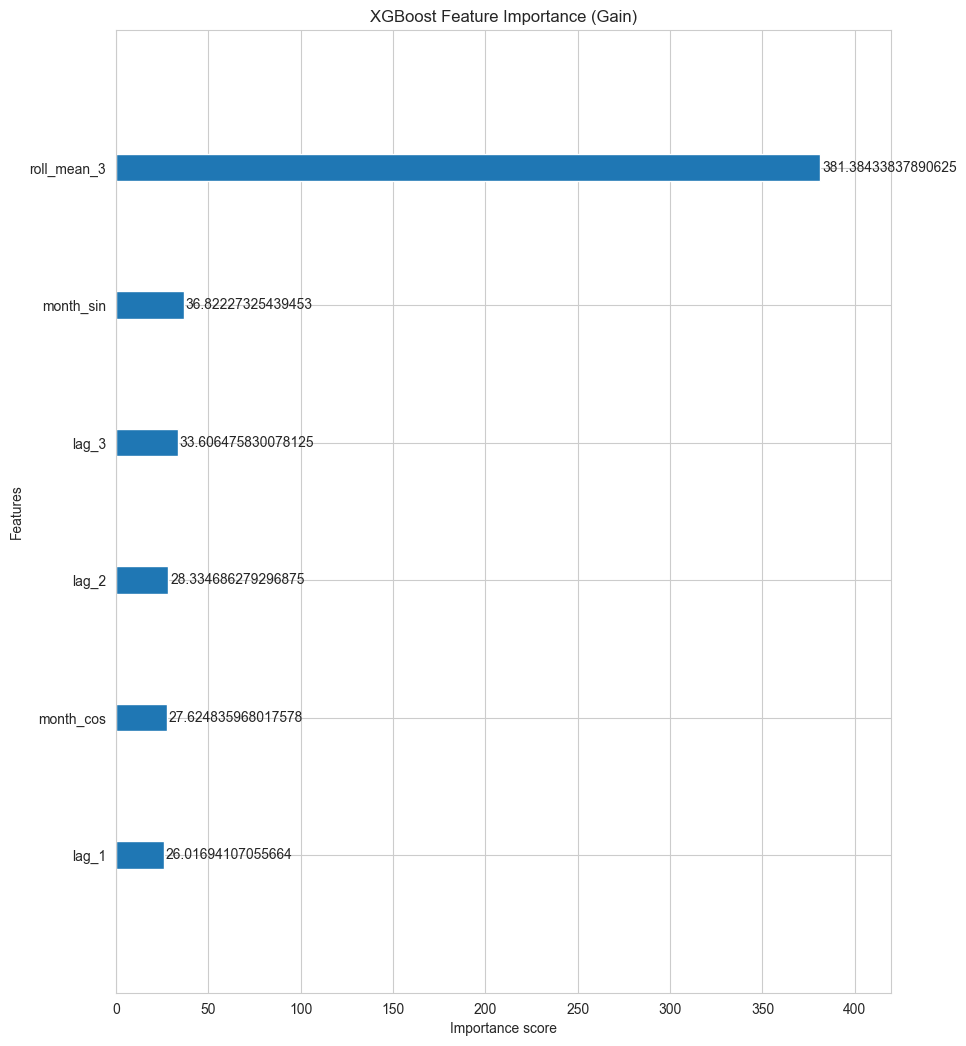


HORIZON 0

▶ Initial CV with all features:

▶ Skipping tuning — evaluating with time series CV:
⚠️ Detected search space in param_dist. Using XGBoost defaults instead.

HORIZON 1

▶ Initial CV with all features:

▶ Skipping tuning — evaluating with time series CV:
⚠️ Detected search space in param_dist. Using XGBoost defaults instead.

HORIZON 2

▶ Initial CV with all features:

▶ Skipping tuning — evaluating with time series CV:
⚠️ Detected search space in param_dist. Using XGBoost defaults instead.

HORIZON 3

▶ Initial CV with all features:

▶ Skipping tuning — evaluating with time series CV:
⚠️ Detected search space in param_dist. Using XGBoost defaults instead.

HORIZON 4

▶ Initial CV with all features:

▶ Skipping tuning — evaluating with time series CV:
⚠️ Detected search space in param_dist. Using XGBoost defaults instead.

HORIZON 0

▶ Initial CV with all features:

▶ Skipping tuning — evaluating with time series CV:
⚠️ Detected search space in param_dist. Using XGBoost defa

In [162]:
from itertools import product
import pandas as pd

# Reset or initialize experiments_df
experiments_df = pd.DataFrame(columns=['horizon', 'include_static', 'tuned', 'pruned', 'pruning_method', 'n_features', 'rmse'])

# Define option grid
tune_options = [True, False]
prune_options = [True, False]
static_options = [True, False]
pruning_methods = ['threshold', 'topk']  # only used if prune=True

# Loop over all combinations
for tune, prune, include_static in product(tune_options, prune_options, static_options):
    method_list = pruning_methods if prune else [None]  # dummy value when pruning is off

    for pruning_method in method_list:
        for i in range(5):  # horizons 0 to 4
            df_train_i = splits[i]['train']

            feature_cols_all = [col for col in df_train_i.columns if col.startswith(("lag_", "roll_", "month_"))]
            if include_static:
                feature_cols_all += list(df_static_selected.columns)

            full_pipeline_per_horizon(
                df_train=df_train_i,
                horizon_label=i,
                feature_cols_all=feature_cols_all,
                target_col=f'target_t+{i}' if i > 0 else 'target_t',
                param_dist=param_dist,
                n_splits=N_SPLITS,
                tuning_iter_initial=N_ITER_INITIAL,
                tuning_iter_final=N_ITER_FINAL,
                test_size=N_TEST_SIZE,
                tune=tune,
                prune=prune,
                pruning_method=pruning_method,
                pruning_threshold=0.1 if pruning_method == 'threshold' else 5,  # top_k is handled using same var
                experiments_df=experiments_df,
                include_static=include_static,
                verbose=False  # suppress printing
            )

# Save all experiment results to CSV
experiments_df.to_csv("experiments_summary.csv", index=False)
print("Saved experiments to 'experiments_summary.csv'")


In [204]:
experiments_df = pd.read_csv('experiments_summary.csv')
experiments_df
# Fill all NaNs with 'none'
experiments_df = experiments_df.fillna('none')

# Group by config and compute mean RMSE
experiments_df.groupby(['tuned', 'pruned', 'pruning_method', 'include_static'])['rmse'].mean().sort_values()




tuned  pruned  pruning_method  include_static
True   False   none            True              3.385965
       True    topk            True              3.395929
               threshold       True              3.414424
False  True    threshold       True              3.473635
True   True    topk            False             3.658776
       False   none            False             3.659629
       True    threshold       False             3.679268
False  True    threshold       False             3.732092
               topk            True              3.790485
                               False             3.890065
       False   none            False             3.896936
                               True              3.964338
Name: rmse, dtype: float64

In [223]:

# FINAL RUN 
include_static = False 

for i in range(5):  # horizons 0 to 4
    df_train_i = splits[i]['train']

    # Collect time series features
    feature_cols_all = [col for col in df_train_i.columns if col.startswith(("lag_", "roll_", "month_"))]

    # Optionally add static features
    if include_static:
        feature_cols_all += list(df_static_selected.columns)

    full_pipeline_per_horizon(
        df_train=df_train_i,
        horizon_label=i,
        feature_cols_all=feature_cols_all,
        target_col=f'target_t+{i}' if i > 0 else 'target_t',
        param_dist=param_dist,
        n_splits=N_SPLITS,
        tuning_iter_initial=N_ITER_INITIAL,
        tuning_iter_final=N_ITER_FINAL,
        test_size=N_TEST_SIZE,
        tune=False,    
        prune=False,    
        pruning_method='topk', 
        pruning_threshold=3,
        experiments_df=experiments_df, 
        include_static = include_static
    )




HORIZON 0

▶ Initial CV with all features:

Model parameters:
Default

Feature columns:
['lag_1', 'lag_2', 'lag_3', 'roll_mean_3', 'month_sin', 'month_cos']
Fold 1: MAE=2.9364, RMSE=3.8899
Fold 2: MAE=2.7431, RMSE=3.7750
Fold 3: MAE=2.7195, RMSE=3.7540
Fold 4: MAE=2.6673, RMSE=3.6022
Fold 5: MAE=2.7398, RMSE=3.6492

Average CV Performance:
Mean MAE:  2.7612
Mean RMSE: 3.7341

▶ Skipping tuning — evaluating with time series CV:
⚠️ Detected search space in param_dist. Using XGBoost defaults instead.

Model parameters:
Default

Feature columns:
['lag_1', 'lag_2', 'lag_3', 'roll_mean_3', 'month_sin', 'month_cos']
Fold 1: MAE=2.9364, RMSE=3.8899
Fold 2: MAE=2.7431, RMSE=3.7750
Fold 3: MAE=2.7195, RMSE=3.7540
Fold 4: MAE=2.6673, RMSE=3.6022
Fold 5: MAE=2.7398, RMSE=3.6492

Average CV Performance:
Mean MAE:  2.7612
Mean RMSE: 3.7341

HORIZON 1

▶ Initial CV with all features:

Model parameters:
Default

Feature columns:
['lag_1', 'lag_2', 'lag_3', 'roll_mean_3', 'month_sin', 'month_cos']
Fol

In [224]:
forecast_models_summary

{0: {'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=True, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=None, num_parallel_tree=None, ...),
  'params': {},
  'rmse': 3.7340818881988525,
  'features': ['lag_1',
   'lag_2',
   'lag_3',
   'roll_mean_3',
   'month_sin',
   'month_cos']},
 1: {'model': XGBRegressor(base_score=None, booster=None, callbacks=No

**PER-HORIZON EVALUATION**

In [225]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

def evaluate_on_test(forecast_models_summary, splits):
    results = {}

    for i in range(0, 5):  # i = 0 to 4
        target_col = f"target_t+{i}" if i > 0 else "target_t"

        model = forecast_models_summary[i]['model']
        features = forecast_models_summary[i]['features']
        test_df = splits[i]["test"]

        y_true = test_df[target_col]
        y_pred = model.predict(test_df[features])

        mae = mean_absolute_error(y_true, y_pred)
        rmse = root_mean_squared_error(y_true, y_pred)

        results[i] = {"mae": mae, "rmse": rmse}

    return results


In [226]:
evaluate_on_test(forecast_models_summary, splits)

{0: {'mae': 2.7067432403564453, 'rmse': 3.5199317932128906},
 1: {'mae': 2.8217884220182894, 'rmse': 3.743077973384863},
 2: {'mae': 2.8637606525245833, 'rmse': 3.724188756102371},
 3: {'mae': 2.9071187285377698, 'rmse': 3.7976525656834843},
 4: {'mae': 2.978435966241009, 'rmse': 3.9466710907397773}}

In [227]:
import numpy as np
import pandas as pd

def predict_test_set(splits, forecast_models_summary):
    """
    Applies trained models to their respective test sets and returns predictions
    with both:
    - feature_datetime: the time the features are based on
    - target_datetime: the actual month being predicted (shifted forward by horizon)

    Also includes:
    - y_pred_rounded: rounded-up prediction to reflect discrete crime counts.
    """
    results = {}

    for horizon, split in splits.items():
        model = forecast_models_summary[horizon]['model']
        features = forecast_models_summary[horizon]['features']
        test = split['test'].copy()
        
        # Feature datetime = when features are constructed
        test['feature_datetime'] = test['Month']

        # Target datetime = when the crime count is predicted for
        test['target_datetime'] = test['Month'] + pd.DateOffset(months=horizon)

        X_test = test[features]
        y_test = test[f'target_t+{horizon}' if horizon > 0 else 'target_t']
        y_pred = model.predict(X_test)
        
        # Round up predictions to reflect discrete count nature
        y_pred_rounded = np.ceil(y_pred).astype(int)

        results[horizon] = pd.DataFrame({
            'ward': test['Ward code'],
            'feature_datetime': test['feature_datetime'],
            'target_datetime': test['target_datetime'],
            'y_true': y_test,
            'y_pred': y_pred,
            'y_pred_rounded': y_pred_rounded
        })

    return results


In [228]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import numpy as np

def compute_metrics(predictions_by_horizon):
    """
    Computes MAE and RMSE for each forecast horizon.
    """
    metrics = {}
    for horizon, df in predictions_by_horizon.items():
        mae = mean_absolute_error(df['y_true'], df['y_pred'])
        rmse = root_mean_squared_error(df['y_true'], df['y_pred'])
        metrics[horizon] = {'mae': mae, 'rmse': rmse}
    return metrics


In [229]:
def plot_predictions_vs_actual(horizon, ward, df):
    """
    Plots predicted vs actual crime counts for a single ward and forecast horizon.
    Y-axis starts at 0 and upper bound is padded dynamically based on data.
    """
    ward_df = df[df['ward'] == ward].sort_values('target_datetime')

    plt.figure(figsize=(10, 5))
    plt.plot(ward_df['target_datetime'], ward_df['y_true'], label='Actual', marker='o')
    plt.plot(ward_df['target_datetime'], ward_df['y_pred_rounded'], label='Predicted', marker='x')

    max_val = max(ward_df['y_true'].max(), ward_df['y_pred_rounded'].max())
    plt.ylim(bottom=0, top=max_val * 1.2)  # pad 20% above highest value

    plt.title(f'Ward {ward} – Horizon {horizon}')
    plt.xlabel('Month (Prediction Target)')
    plt.ylabel('Crime Count')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [230]:
def plot_ward_timeline(ward, splits, predictions_by_horizon):
    """
    Plots the full timeline of crime counts for a ward, including training data
    and actual/predicted counts across all forecast horizons.
    """
    plt.figure(figsize=(12, 6))

    # Combine training sets across all horizons
    train_concat = pd.concat([v['train'] for v in splits.values()])
    train_ward = train_concat[train_concat['Ward code'] == ward]
    train_grouped = train_ward.groupby('Month')['target_t'].mean().reset_index()
    plt.plot(train_grouped['Month'], train_grouped['target_t'], label='Training (Actual)', color='black')

    # Overlay predictions from each horizon
    for horizon, df in predictions_by_horizon.items():
        ward_df = df[df['ward'] == ward].sort_values('target_datetime')
        if ward_df.empty:
            continue
        plt.plot(ward_df['target_datetime'], ward_df['y_pred_rounded'], label=f'Predicted H{horizon}')
        plt.plot(ward_df['target_datetime'], ward_df['y_true'], '--', label=f'Actual H{horizon}')

    plt.title(f'Ward {ward} – Forecasts Across Horizons')
    plt.xlabel('Month (Prediction Target)')
    plt.ylabel('Crime Count')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [231]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import matplotlib.cm as cm
import numpy as np

def plot_deployment_timeline_for_ward(ward, splits, forecast_models_summary, predictions_dict, max_horizon=4):
    """
    Plots the actual training data (black line), in-sample fitted values (dotted lines),
    and future predictions (scatter) across forecast horizons for a single ward.
    """
    plt.figure(figsize=(14, 6))

    # 1. Actual training data (from horizon 0 only)
    train_df = splits[0]['train']
    ward_train = train_df[train_df['Ward code'] == ward].copy()
    actual_dates = ward_train['Month']
    actual_values = ward_train['target_t']
    plt.plot(actual_dates, actual_values, color='black', label='Actual (training)', linewidth=2)

    # Create a consistent color per horizon
    horizon_colors = ['red', 'orange', 'green', 'blue', 'purple']

    # 2. In-sample fitted values (for each horizon)
    for h in range(0, max_horizon + 1):
        model = forecast_models_summary[h]['model']
        features = forecast_models_summary[h]['features']
        train_h = splits[h]['train']
        ward_train_h = train_h[train_h['Ward code'] == ward].copy()
        if ward_train_h.empty:
            continue
        X_train_h = ward_train_h[features]
        y_fitted = model.predict(X_train_h)
        fitted_dates = ward_train_h['Month'] + pd.DateOffset(months=h)
        plt.plot(
            fitted_dates, y_fitted,
            linestyle='--',
            label=f'In-sample fit h={h}',
            alpha=0.6,
            color=horizon_colors[h]
        )

    # 3. Determine the latest training cutoff point across horizons
    cutoff = max(
        splits[h]['train'][splits[h]['train']['Ward code'] == ward]['Month'].max() + pd.DateOffset(months=h)
        for h in range(0, max_horizon + 1)
    )

    # 4. Forecast scatter points
    for h in range(0, max_horizon + 1):
        pred_df = predictions_dict[h]
        ward_preds = pred_df[pred_df['ward'] == ward].copy()
        forecast_month = cutoff + pd.DateOffset(months=h)
        point = ward_preds[ward_preds['target_datetime'] == forecast_month]

        if not point.empty:
            y_true = point['y_true'].mean()
            y_pred = point['y_pred'].mean()

            # Black actual future value (only once in legend)
            plt.scatter(forecast_month, y_true, color='black', marker='o', label='Actual (future)' if h == 0 else None)
            # Colored predicted value for this horizon
            plt.scatter(forecast_month, y_pred, color=horizon_colors[h], marker='x', label=f'Predicted t+{h}')

    plt.title(f'Deployment-style timeline for Ward {ward}')
    plt.xlabel('Month')
    plt.ylabel('Crime Count')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [232]:
predictions_by_horizon = predict_test_set(splits, forecast_models_summary)
predictions_by_horizon

{0:            ward feature_datetime target_datetime  y_true     y_pred  \
 0     E05009317       2024-12-01      2024-12-01      22  15.932627   
 1     E05009318       2024-12-01      2024-12-01      16  10.054473   
 2     E05009319       2024-12-01      2024-12-01      11  14.428235   
 3     E05009320       2024-12-01      2024-12-01       5   7.654511   
 4     E05009321       2024-12-01      2024-12-01      12   6.894934   
 ...         ...              ...             ...     ...        ...   
 2715  E05014116       2025-03-01      2025-03-01       3   3.960660   
 2716  E05014117       2025-03-01      2025-03-01       7   5.506483   
 2717  E05014118       2025-03-01      2025-03-01      18  17.799646   
 2718  E05014119       2025-03-01      2025-03-01       3   4.571232   
 2719  E09000001       2025-03-01      2025-03-01      29  23.286274   
 
       y_pred_rounded  
 0                 16  
 1                 11  
 2                 15  
 3                  8  
 4         

In [233]:
compute_metrics(predictions_by_horizon)

{0: {'mae': 2.7067432403564453, 'rmse': 3.5199317932128906},
 1: {'mae': 2.8217884220182894, 'rmse': 3.743077973384863},
 2: {'mae': 2.8637606525245833, 'rmse': 3.724188756102371},
 3: {'mae': 2.9071187285377698, 'rmse': 3.7976525656834843},
 4: {'mae': 2.978435966241009, 'rmse': 3.9466710907397773}}

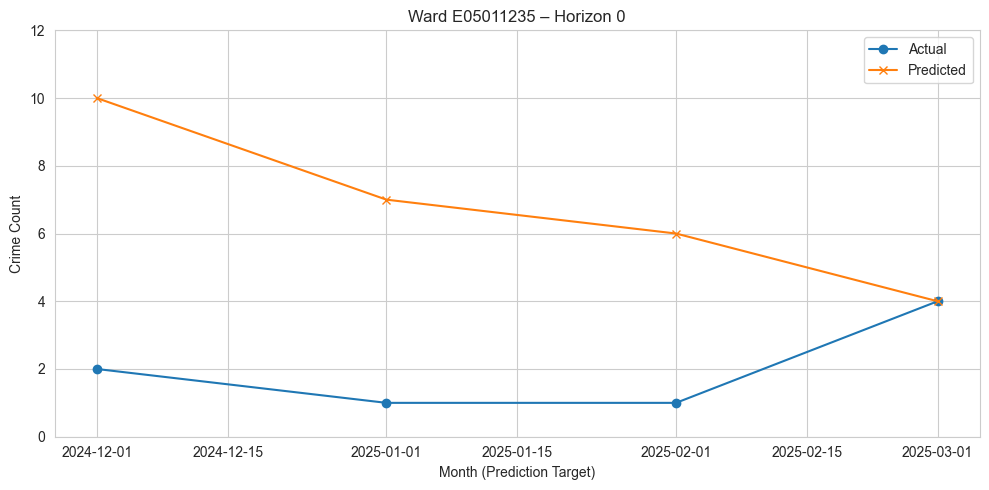

In [234]:
ward_to_plot = df_burglaries["Ward code"].unique()[100]
plot_predictions_vs_actual(horizon=0, ward=ward_to_plot, df=predictions_by_horizon[0])

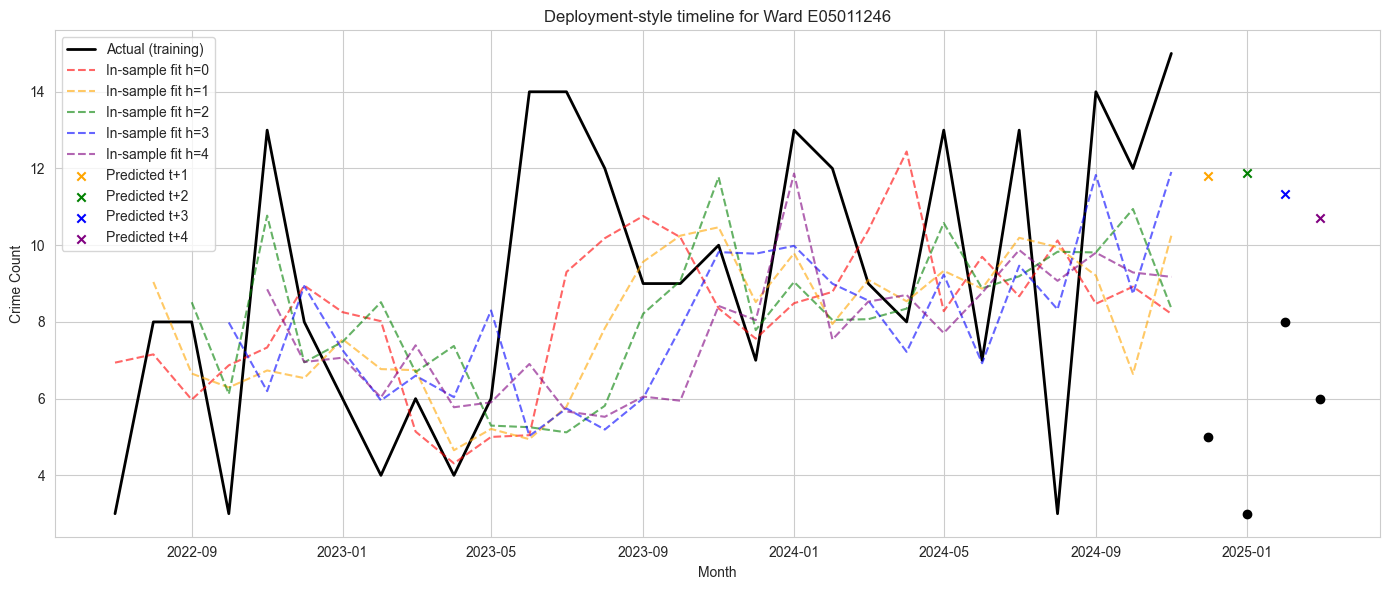

In [235]:
ward_to_plot = df_burglaries["Ward code"].unique()[111]

plot_deployment_timeline_for_ward(
    ward=ward_to_plot,  # or any other ward code
    splits=splits,
    forecast_models_summary=forecast_models_summary,
    predictions_dict=predictions_by_horizon,
)


**DEPLOYMENT: COMBINE FORECASTS FOR FINAL USE**

In [220]:
import numpy as np
import pandas as pd

def create_latest_feature_snapshot(df_burglaries, df_static, lags=[1, 2, 3], rolling_windows=[2, 4, 6]):
    """
    Prepares the latest available feature snapshot per ward for inference.
    Returns a DataFrame with features only (no target).
    """
    df = df_burglaries.copy()
    df['Month'] = pd.to_datetime(df['Month'])
    df = df.sort_values(['Ward code', 'Month'])

    all_months = pd.date_range(start=df['Month'].min(), end=df['Month'].max(), freq='MS')
    features = []

    for ward, group in df.groupby('Ward code'):
        group = group.set_index('Month').sort_index()
        group = group.reindex(all_months, fill_value=0)
        group['Ward code'] = ward

        for lag in lags:
            group[f'lag_{lag}'] = group['Crime count'].shift(lag)
        for window in rolling_windows:
            group[f'roll_mean_{window}'] = group['Crime count'].shift(1).rolling(window=window).mean()

        group = group.reset_index().rename(columns={'index': 'Month'})
        features.append(group)

    df_features = pd.concat(features)
    df_features['month'] = df_features['Month'].dt.month
    df_features['month_sin'] = np.sin(2 * np.pi * df_features['month'] / 12)
    df_features['month_cos'] = np.cos(2 * np.pi * df_features['month'] / 12)
    df_features = df_features.drop(columns=['month'])

    df_features = df_features.merge(df_static, on='Ward code', how='left')

    # For each ward, take the latest available row (i.e. max Month)
    latest_df = (
        df_features.sort_values("Month")
        .groupby("Ward code")
        .tail(1)
        .reset_index(drop=True)
    )

    latest_df['Ward code'] = latest_df['Ward code'].astype('category')

    return latest_df


In [221]:
def create_combined_forecasts(df_burglaries, df_static, forecast_models_summary, lags=[1, 2, 3], rolling_windows=[2, 4, 6], max_horizon=4):
    """
    For the latest available data, create features snapshot and generate predictions
    across horizons 0 to max_horizon using provided forecast_models_summary.
    Returns a DataFrame with:
     - Month (time of prediction)
     - Ward code
     - Predictions for each horizon (pred_h0, pred_h1, ...)
    """
    latest_features = create_latest_feature_snapshot(df_burglaries, df_static, lags=lags, rolling_windows=rolling_windows)

    # Time of prediction is the Month of the latest snapshot rows (same for all wards)
    prediction_month = latest_features['Month'].max()

    results = pd.DataFrame({
        'Month': prediction_month,
        'Ward code': latest_features['Ward code']
    })

    # Predict for each horizon
    for h in range(max_horizon + 1):
        model = forecast_models_summary[h]['model']
        features = forecast_models_summary[h]['features']

        # Select features for prediction
        X_pred = latest_features[features]

        # Predict and add to results
        preds = model.predict(X_pred)
        results[f'pred_h{h}'] = preds

    # Ensure Ward code stays categorical if needed
    results['Ward code'] = results['Ward code'].astype('category')

    return results


In [222]:
forecasts = create_combined_forecasts(df_burglaries, df_static_selected, forecast_models_summary, lags=[1, 2, 3], rolling_windows=[3])
forecasts

,Month,Ward code,pred_h0,pred_h1,pred_h2,pred_h3,pred_h4
0,2025-03-01,E05014110,5.506336,5.956790,2.748479,5.011363,4.478272
1,2025-03-01,E05014102,14.918288,16.229429,13.676991,14.755419,12.826069
2,2025-03-01,E05014114,4.418190,4.536913,4.076187,4.609097,6.869570
3,2025-03-01,E05014103,4.874835,2.053246,3.352799,2.738591,2.956541
4,2025-03-01,E05014107,5.909963,3.477098,8.627050,5.032194,4.826085
...,...,...,...,...,...,...,...
675,2025-03-01,E05013785,7.093882,4.329216,5.042235,4.294899,5.391297
676,2025-03-01,E05013784,7.093091,6.045361,6.123260,6.040339,5.695652
677,2025-03-01,E05013783,8.024480,4.252710,6.169930,6.485826,7.304346
678,2025-03-01,E05013781,7.773942,3.552760,3.543131,2.758246,4.695652
